In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import statistics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import math
import glob
from itertools import combinations
from matplotlib import pyplot as plt
from Bio import Phylo
import biotite
from pca_plot import *
from vst_function import *
from stattools.resampling import PermutationTest
from scipy import stats
from pyranges import PyRanges
import seaborn as sns

In [2]:
## Read and merge files 
anotation = pd.read_csv('../data/SGDP_anotation.csv', sep=',', encoding='latin-1')

ids_hg19 = pd.DataFrame()
ids_hg19['Sample'] = anotation['3-Illumina_ID']
ids_hg19['Region'] = anotation['10-Region']


In [3]:
data = pd.read_csv('t2tchm13_cnvs.csv')
data = data[~data['Chromosome'].isin(['MT', 'X', 'Y'])]
data

#chm13 = pd.read_csv('../data/chm13_gene_regions.csv', index_col=0)


/var/folders/05/4pfxtbrs5459ytz3j1jhcgt00000gn/T/ipykernel_69475/4197760163.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('t2tchm13_cnvs.csv')


Unnamed: 0 Chromosome      Start        End  LP6005441-DNA_A01  \
47804         47804         22          0      20541               28.0   
47805         47805         22      20541      22327               28.0   
47806         47806         22      22327      23327               26.0   
47807         47807         22      23327      25569               20.0   
47808         47808         22      25569      26687               13.0   
...             ...        ...        ...        ...                ...   
1004612     1004612          1  248364795  248366351               23.0   
1004613     1004613          1  248366351  248367622               27.0   
1004614     1004614          1  248367622  248368745               23.0   
1004615     1004615          1  248368745  248370339               35.0   
1004616     1004616          1  248370339  248387328               37.0   

         LP6005441-DNA_A03  LP6005441-DNA_A04  LP6005441-DNA_A05  \
47804                 30.0               32.0               35.0   
47805                 31.0               32.0               35.0   
47806                 29.0               31.0               32.0   
47807                 21.0               23.0               25.0   
47808                 13.0               15.0               17.0   
...                    ...                ...                ...   
1004612               26.0               27.0               29.0   
1004613               31.0               29.0               29.0   
1004614               27.0               27.0               29.0   
1004615               41.0               39.0               43.0   
1004616               41.0               38.0               43.0   

         LP6005441-DNA_A06  LP6005441-DNA_A08  ...  LP6005677-DNA_D03  \
47804                 32.0               29.0  ...               30.0   
47805                 32.0               28.0  ...               30.0   
47806                 29.0               26.0  ...               27.0   
47807                 23.0               20.0  ...               21.0   
47808                 14.0               13.0  ...               14.0   
...                    ...                ...  ...                ...   
1004612               26.0               23.0  ...               25.0   
1004613               29.0               27.0  ...               28.0   
1004614               26.0               24.0  ...               25.0   
1004615               41.0               37.0  ...               39.0   
1004616               39.0               38.0  ...               36.0   

         LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
47804                 33.0               33.0               37.0   
47805                 33.0               34.0               35.0   
47806                 29.0               30.0               31.0   
47807                 22.0               23.0               24.0   
47808                 14.0               14.0               14.0   
...                    ...                ...                ...   
1004612               25.0               26.0               28.0   
1004613               28.0               26.0               33.0   
1004614               25.0               27.0               29.0   
1004615               42.0               41.0               48.0   
1004616               39.0               39.0               42.0   

         LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  \
47804                 34.0               38.0       30.0       32.0   
47805                 34.0               38.0       31.0       32.0   
47806                 30.0               32.0       24.0       28.0   
47807                 22.0               24.0       18.0       21.0   
47808                 14.0               15.0       10.0       13.0   
...                    ...                ...        ...        ...   
1004612               28.0               32.0       25.0       26.0   
1004613               31.0   

<h3> removing black list regions

In [4]:
black_header = ['Chromosome','Start', 'End', 'Type', 'Extra1', 'Extra2']
blacklist = pd.read_table('/Users/luciabazan/Downloads/T2T.excluderanges.bed', names=black_header)
blacklist['Chromosome'] = blacklist['Chromosome'].str.replace('chr', '')
blacklist = blacklist.drop(columns=['Extra1', 'Extra2'])
blacklist_ranges = PyRanges(blacklist)

/opt/anaconda3/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [5]:
final_cnv_ranges = PyRanges(data)
final_cnv = final_cnv_ranges.overlap(blacklist_ranges, invert=True)
final_cnv = final_cnv.as_df()
#final_cnv.to_csv('../data/T2TCHM13_cnvs.csv.zip', compression="zip")
final_cnv = final_cnv[(final_cnv[final_cnv.columns[4:]]<5).all(axis=1)]
final_cnv['Chromosome'] = 'chr' + final_cnv['Chromosome'].astype(str)
final_cnv 

/opt/anaconda3/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


Unnamed: 0 Chromosome     Start       End  LP6005441-DNA_A01  \
33          930488       chr1    328816    331989                2.0   
34          930489       chr1    331989    334176                2.0   
35          930490       chr1    334176    336807                2.0   
36          930491       chr1    336807    340171                2.0   
37          930492       chr1    340171    341171                2.0   
...            ...        ...       ...       ...                ...   
920276       63898      chr22  51251832  51252832                2.0   
920277       63899      chr22  51252832  51253832                2.0   
920279       63901      chr22  51256206  51257702                3.0   
920280       63902      chr22  51257702  51259256                3.0   
920285       63909      chr22  51286137  51288688                3.0   

        LP6005441-DNA_A03  LP6005441-DNA_A04  LP6005441-DNA_A05  \
33                    2.0                2.0                2.0   
34                    2.0                2.0                2.0   
35                    1.0                1.0                1.0   
36                    1.0                2.0                2.0   
37                    2.0                2.0                2.0   
...                   ...                ...                ...   
920276                2.0                2.0                2.0   
920277                2.0                2.0                2.0   
920279                4.0                4.0                4.0   
920280                3.0                4.0                3.0   
920285                4.0                4.0                3.0   

        LP6005441-DNA_A06  LP6005441-DNA_A08  ...  LP6005677-DNA_D03  \
33                    2.0                2.0  ...                2.0   
34                    2.0                2.0  ...                2.0   
35                    2.0                1.0  ...                1.0   
36                    2.0                1.0  ...                1.0   
37                    2.0                2.0  ...                2.0   
...                   ...                ...  ...                ...   
920276                2.0                2.0  ...                2.0   
920277                2.0                2.0  ...                2.0   
920279                4.0                4.0  ...                4.0   
920280                4.0                3.0  ...                3.0   
920285                4.0                4.0  ...                4.0   

        LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
33                    2.0                2.0                2.0   
34                    2.0                2.0                2.0   
35                    1.0                1.0                2.0   
36                    1.0                1.0                1.0   
37                    2.0                2.0                2.0   
...                   ...                ...                ...   
920276                2.0                2.0                2.0   
920277                2.0                2.0                2.0   
920279                4.0                3.0                3.0   
920280                4.0                3.0                3.0   
920285                4.0                4.0                4.0   

        LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  SS6004478  \
33                    2.0                2.0        2.0        2.0        2.0   
34                    2.0                2.0        2.0        2.0        2.0   
35                    1.0                1.0        1.0        1.0        1.0   
36                    1.0                1.0        1.0        1.0        1.0   
37                    2.0                2.0        2.0        2.0        2.0   
...                   ...                ...        ...        ...        ...   
920276                2.0                2.0        2.0        2.0        2.0   
920277              

In [6]:
d = final_cnv
#d['Chromosome'] = 'chr' + d['Chromosome'].astype(str)
d = d[(d[d.columns[4:]]<5).all(axis=1)]
d

Unnamed: 0 Chromosome     Start       End  LP6005441-DNA_A01  \
33          930488       chr1    328816    331989                2.0   
34          930489       chr1    331989    334176                2.0   
35          930490       chr1    334176    336807                2.0   
36          930491       chr1    336807    340171                2.0   
37          930492       chr1    340171    341171                2.0   
...            ...        ...       ...       ...                ...   
920276       63898      chr22  51251832  51252832                2.0   
920277       63899      chr22  51252832  51253832                2.0   
920279       63901      chr22  51256206  51257702                3.0   
920280       63902      chr22  51257702  51259256                3.0   
920285       63909      chr22  51286137  51288688                3.0   

        LP6005441-DNA_A03  LP6005441-DNA_A04  LP6005441-DNA_A05  \
33                    2.0                2.0                2.0   
34                    2.0                2.0                2.0   
35                    1.0                1.0                1.0   
36                    1.0                2.0                2.0   
37                    2.0                2.0                2.0   
...                   ...                ...                ...   
920276                2.0                2.0                2.0   
920277                2.0                2.0                2.0   
920279                4.0                4.0                4.0   
920280                3.0                4.0                3.0   
920285                4.0                4.0                3.0   

        LP6005441-DNA_A06  LP6005441-DNA_A08  ...  LP6005677-DNA_D03  \
33                    2.0                2.0  ...                2.0   
34                    2.0                2.0  ...                2.0   
35                    2.0                1.0  ...                1.0   
36                    2.0                1.0  ...                1.0   
37                    2.0                2.0  ...                2.0   
...                   ...                ...  ...                ...   
920276                2.0                2.0  ...                2.0   
920277                2.0                2.0  ...                2.0   
920279                4.0                4.0  ...                4.0   
920280                4.0                3.0  ...                3.0   
920285                4.0                4.0  ...                4.0   

        LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
33                    2.0                2.0                2.0   
34                    2.0                2.0                2.0   
35                    1.0                1.0                2.0   
36                    1.0                1.0                1.0   
37                    2.0                2.0                2.0   
...                   ...                ...                ...   
920276                2.0                2.0                2.0   
920277                2.0                2.0                2.0   
920279                4.0                3.0                3.0   
920280                4.0                3.0                3.0   
920285                4.0                4.0                4.0   

        LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  SS6004478  \
33                    2.0                2.0        2.0        2.0        2.0   
34                    2.0                2.0        2.0        2.0        2.0   
35                    1.0                1.0        1.0        1.0        1.0   
36                    1.0                1.0        1.0        1.0        1.0   
37                    2.0                2.0        2.0        2.0        2.0   
...                   ...                ...        ...        ...        ...   
920276                2.0                2.0        2.0        2.0        2.0   
920277              

<h2> PCA

In [7]:
#final_cnv = final_cnv.iloc[new]
final = final_cnv.iloc[:,4:287]
counts = final
counts = counts.fillna(2)
counts = counts.T
counts = counts.sort_index()
counts

33      34      35      36      37      38      39      \
LP6005441-DNA_A01     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
LP6005441-DNA_A03     2.0     2.0     1.0     1.0     2.0     2.0     2.0   
LP6005441-DNA_A04     2.0     2.0     1.0     2.0     2.0     2.0     2.0   
LP6005441-DNA_A05     2.0     2.0     1.0     2.0     2.0     2.0     2.0   
LP6005441-DNA_A06     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
...                   ...     ...     ...     ...     ...     ...     ...   
LP6007069-DNA_A01     2.0     2.0     1.0     1.0     2.0     2.0     2.0   
SS6004471             2.0     2.0     1.0     1.0     2.0     2.0     2.0   
SS6004477             2.0     2.0     1.0     1.0     2.0     2.0     2.0   
SS6004478             2.0     2.0     1.0     1.0     2.0     2.0     2.0   
SS6004480             2.0     2.0     1.0     1.0     2.0     2.0     2.0   

                   40      41      42      ...  920271  920272  920273  \
LP6005441-DNA_A01     2.0     2.0     2.0  ...     2.0     2.0     2.0   
LP6005441-DNA_A03     2.0     2.0     2.0  ...     2.0     2.0     2.0   
LP6005441-DNA_A04     2.0     2.0     2.0  ...     2.0     2.0     2.0   
LP6005441-DNA_A05     2.0     2.0     2.0  ...     2.0     2.0     2.0   
LP6005441-DNA_A06     2.0     2.0     2.0  ...     2.0     2.0     2.0   
...                   ...     ...     ...  ...     ...     ...     ...   
LP6007069-DNA_A01     2.0     2.0     2.0  ...     1.0     2.0     2.0   
SS6004471             2.0     2.0     2.0  ...     2.0     2.0     2.0   
SS6004477             2.0     2.0     2.0  ...     2.0     2.0     2.0   
SS6004478             2.0     2.0     2.0  ...     2.0     2.0     2.0   
SS6004480             2.0     2.0     2.0  ...     2.0     2.0     2.0   

                   920274  920275  920276  920277  920279  920280  920285  
LP6005441-DNA_A01     2.0     2.0     2.0     2.0     3.0     3.0     3.0  
LP6005441-DNA_A03     2.0     2.0     2.0     2.0     4.0     3.0     4.0  
LP6005441-DNA_A04     2.0     2.0     2.0     2.0     4.0     4.0     4.0  
LP6005441-DNA_A05     2.0     2.0     2.0     2.0     4.0     3.0     3.0  
LP6005441-DNA_A06     2.0     2.0     2.0     2.0     4.0     4.0     4.0  
...                   ...     ...     ...     ...     ...     ...     ...  
LP6007069-DNA_A01     2.0     2.0     2.0     2.0     4.0     3.0     4.0  
SS6004471             2.0     2.0     2.0     2.0     4.0     3.0     4.0  
SS6004477             2.0     2.0     2.0     2.0     4.0     3.0     4.0  
SS6004478             2.0     2.0     2.0     2.0     4.0     3.0     4.0  
SS6004480             2.0     2.0     2.0     2.0     4.0     3.0     4.0  

[266 rows x 883092 columns]

<h3> population classification

In [8]:
features = ids_hg19.set_index('Sample').merge(counts, left_index=True, right_index=True)
features = features.loc[:,['Region']]
features = features.sort_index()
features 

Region
LP6005441-DNA_A01  WestEurasia
LP6005441-DNA_A03      Oceania
LP6005441-DNA_A04      America
LP6005441-DNA_A05  WestEurasia
LP6005441-DNA_A06  WestEurasia
...                        ...
LP6007069-DNA_A01  WestEurasia
SS6004471               Africa
SS6004477              Oceania
SS6004478              Oceania
SS6004480               Africa

[266 rows x 1 columns]

In [9]:
#PCA

pca = PCA(n_components=10)
pca_results = pca.fit_transform(counts)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3', 'component_4',
                                  'component_5',
                                  'component_6',
                                  'component_7',
                                  'component_8',
                                  'component_9',
                                   'component_10'
                                  ],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
df_pca

Region  component_1  component_2  component_3  \
LP6005441-DNA_A01  WestEurasia     3.828264     3.405704     0.749292   
LP6005441-DNA_A03      Oceania     5.280717     2.519148     2.208223   
LP6005441-DNA_A04      America     4.205402     3.918492     0.625415   
LP6005441-DNA_A05  WestEurasia     3.509388     4.839981    -0.356550   
LP6005441-DNA_A06  WestEurasia     3.915690     4.751669    -0.011755   
...                        ...          ...          ...          ...   
LP6007069-DNA_A01  WestEurasia     8.510471    -0.540662     0.441079   
SS6004471               Africa     8.565307    -7.657342    -0.368253   
SS6004477              Oceania     6.521067    -5.463338     0.524661   
SS6004478              Oceania     9.535439    -2.729787     0.064740   
SS6004480               Africa     4.980915     3.291142    -1.490695   

                   component_4  component_5  component_6  component_7  \
LP6005441-DNA_A01     7.484855    -7.471918    -1.097611     3.430021   
LP6005441-DNA_A03     5.061315    -3.106707    -3.286117     1.810248   
LP6005441-DNA_A04     5.437575   -12.099078    -2.850822     3.212871   
LP6005441-DNA_A05     7.456730    -8.749014     1.078540     3.752341   
LP6005441-DNA_A06     8.302880   -17.440267    -1.195093     5.615392   
...                        ...          ...          ...          ...   
LP6007069-DNA_A01  -146.018114    14.148546    12.650444   -11.374344   
SS6004471          -202.312254   -54.826193     8.374164    20.654065   
SS6004477          -113.531919    -8.840804     4.291316    -4.713291   
SS6004478          -150.003496    -9.114456     7.457219    -7.797439   
SS6004480          -119.997756    -9.645503    12.019983    -8.311059   

                   component_8  component_9  component_10  
LP6005441-DNA_A01     1.471949     1.919215      2.931965  
LP6005441-DNA_A03    -1.699207    -8.159121     -9.757030  
LP6005441-DNA_A04     1.514399    -2.681769     -3.194600  
LP6005441-DNA_A05     2.326212     8.954542      9.217355  
LP6005441-DNA_A06     1.860670     4.609319      6.093281  
...                        ...          ...           ...  
LP6007069-DNA_A01    65.464159     6.479819      5.573368  
SS6004471          -192.533720    14.088148     16.670243  
SS6004477            25.472795   -34.501888    -44.885755  
SS6004478            64.380673   -16.924369    -24.528534  
SS6004480            65.869963    22.080756     30.174011  

[266 rows x 11 columns]

In [20]:
pca.explained_variance_ratio_

array([0.18689672, 0.06632641, 0.03513834, 0.0300813 , 0.02264323,
       0.01957991, 0.01308799, 0.01242836, 0.00829034, 0.00793582])

             component_1  component_2  component_3  component_4  component_5  \
Region                                                                         
WestEurasia     3.828264     3.405704     0.749292     7.484854    -7.471866   
Oceania         5.280717     2.519148     2.208215     5.061319    -3.106648   
America         4.205402     3.918492     0.625409     5.437581   -12.099072   
WestEurasia     3.509388     4.839981    -0.356549     7.456730    -8.749001   
WestEurasia     3.915690     4.751669    -0.011754     8.302879   -17.440261   
...                  ...          ...          ...          ...          ...   
WestEurasia     8.510471    -0.540662     0.441064  -146.018172    14.148289   
Africa          8.565307    -7.657342    -0.368255  -202.312252   -54.826191   
Oceania         6.521067    -5.463338     0.524653  -113.531877    -8.840817   
Oceania         9.535439    -2.729787     0.064746  -150.003492    -9.113902   
Africa          4.980915     3.291142   

/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:85: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:102: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:85: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_

             component_1  component_2  component_3  component_4  component_5  \
Region                                                                         
WestEurasia     3.828264     3.405704     0.749292     7.484854    -7.471866   
Oceania         5.280717     2.519148     2.208215     5.061319    -3.106648   
America         4.205402     3.918492     0.625409     5.437581   -12.099072   
WestEurasia     3.509388     4.839981    -0.356549     7.456730    -8.749001   
WestEurasia     3.915690     4.751669    -0.011754     8.302879   -17.440261   
...                  ...          ...          ...          ...          ...   
WestEurasia     8.510471    -0.540662     0.441064  -146.018172    14.148289   
Africa          8.565307    -7.657342    -0.368255  -202.312252   -54.826191   
Oceania         6.521067    -5.463338     0.524653  -113.531877    -8.840817   
Oceania         9.535439    -2.729787     0.064746  -150.003492    -9.113902   
Africa          4.980915     3.291142   

/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:85: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:102: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:85: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_

             component_1  component_2  component_3  component_4  component_5  \
Region                                                                         
WestEurasia     3.828264     3.405704     0.749292     7.484854    -7.471866   
Oceania         5.280717     2.519148     2.208215     5.061319    -3.106648   
America         4.205402     3.918492     0.625409     5.437581   -12.099072   
WestEurasia     3.509388     4.839981    -0.356549     7.456730    -8.749001   
WestEurasia     3.915690     4.751669    -0.011754     8.302879   -17.440261   
...                  ...          ...          ...          ...          ...   
WestEurasia     8.510471    -0.540662     0.441064  -146.018172    14.148289   
Africa          8.565307    -7.657342    -0.368255  -202.312252   -54.826191   
Oceania         6.521067    -5.463338     0.524653  -113.531877    -8.840817   
Oceania         9.535439    -2.729787     0.064746  -150.003492    -9.113902   
Africa          4.980915     3.291142   

/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:85: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:102: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:85: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_

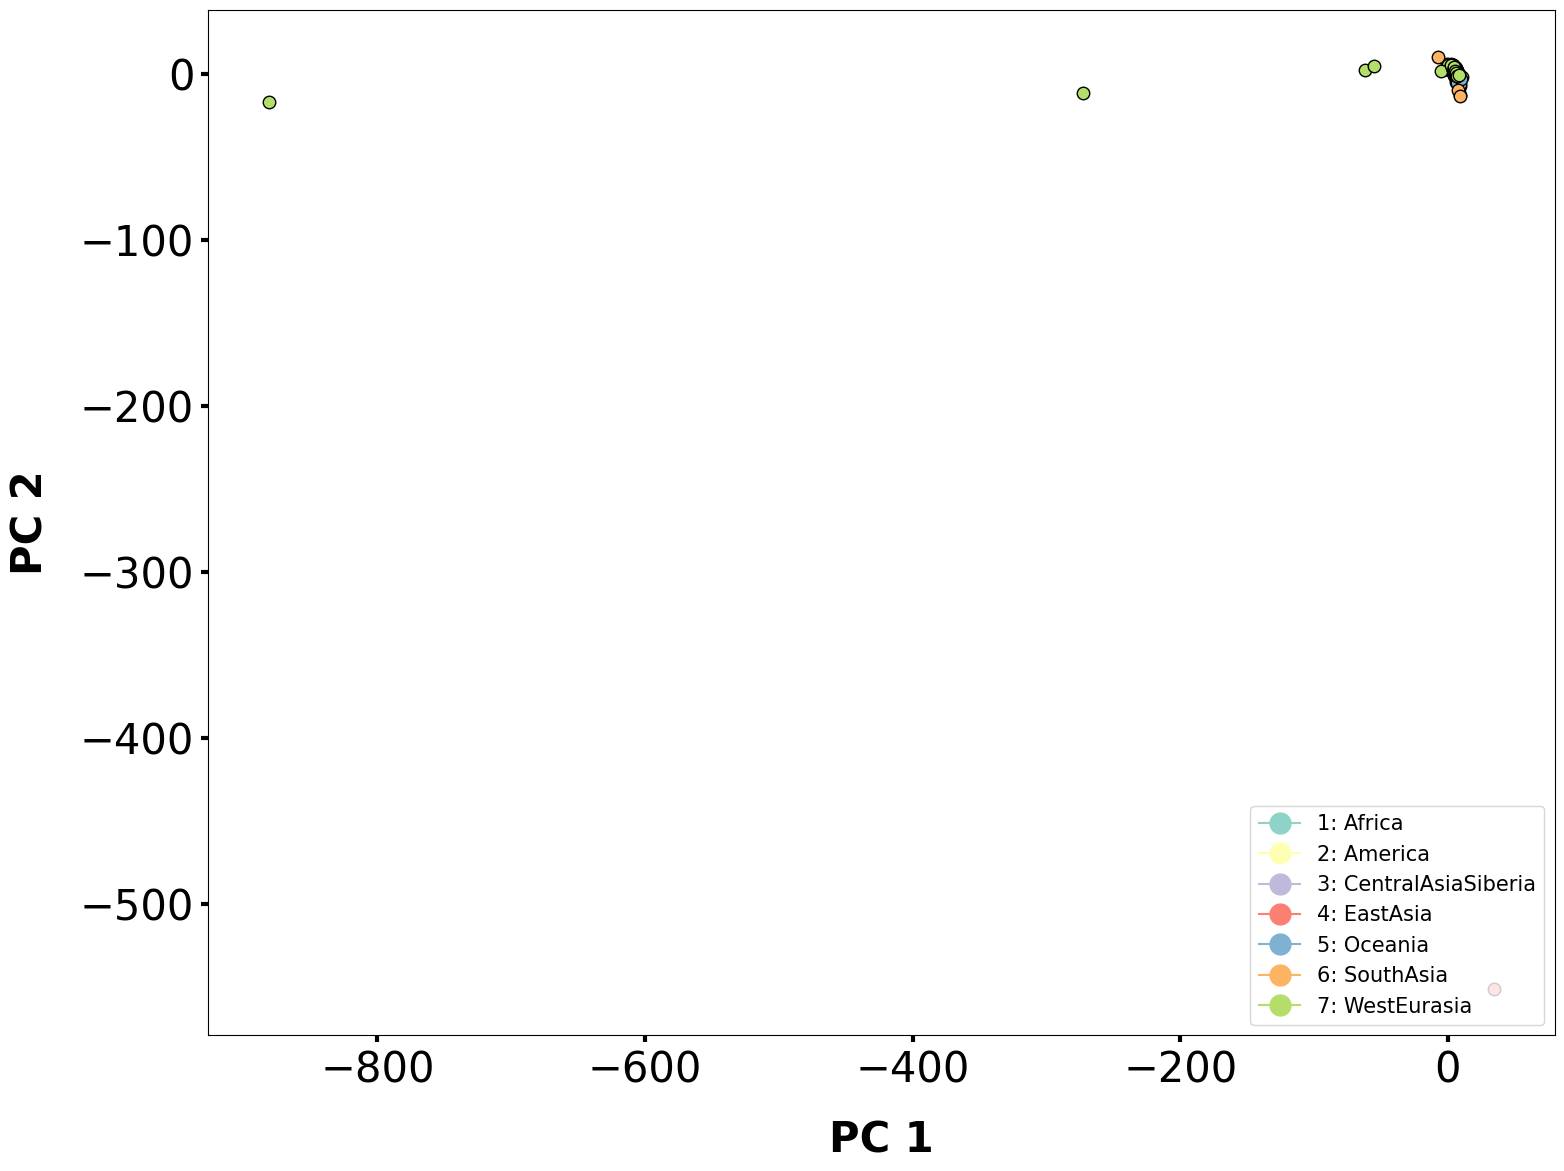

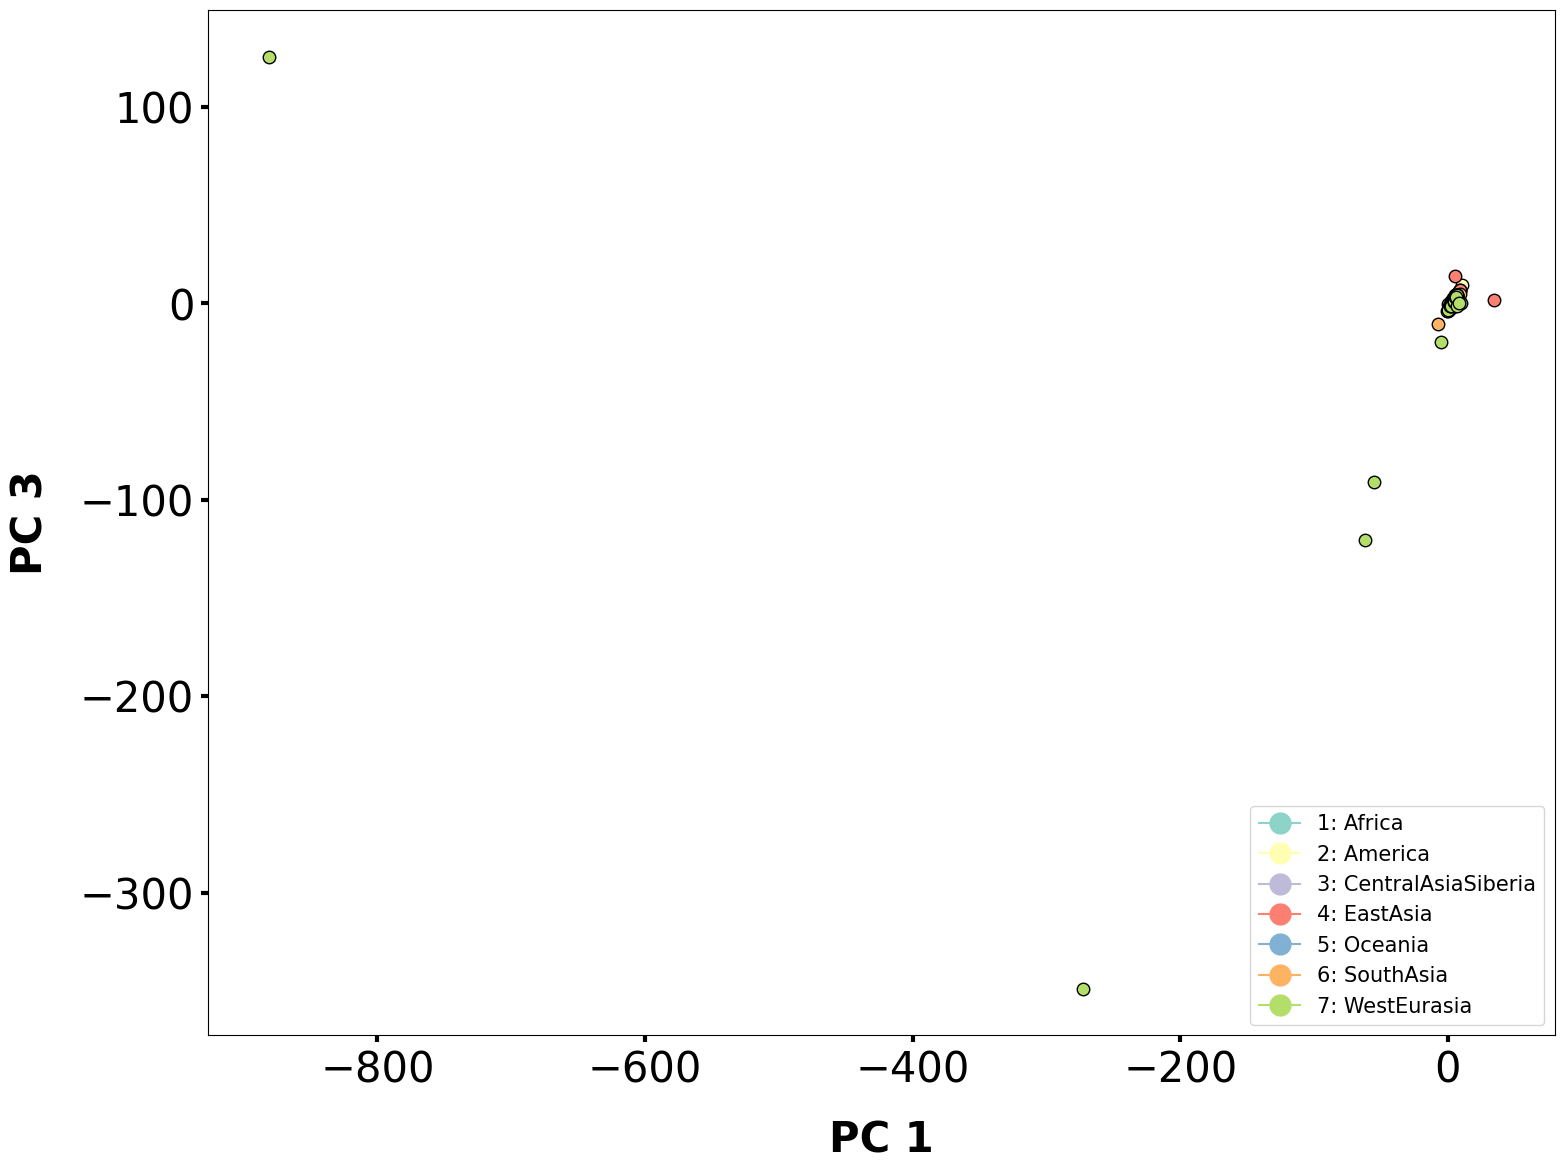

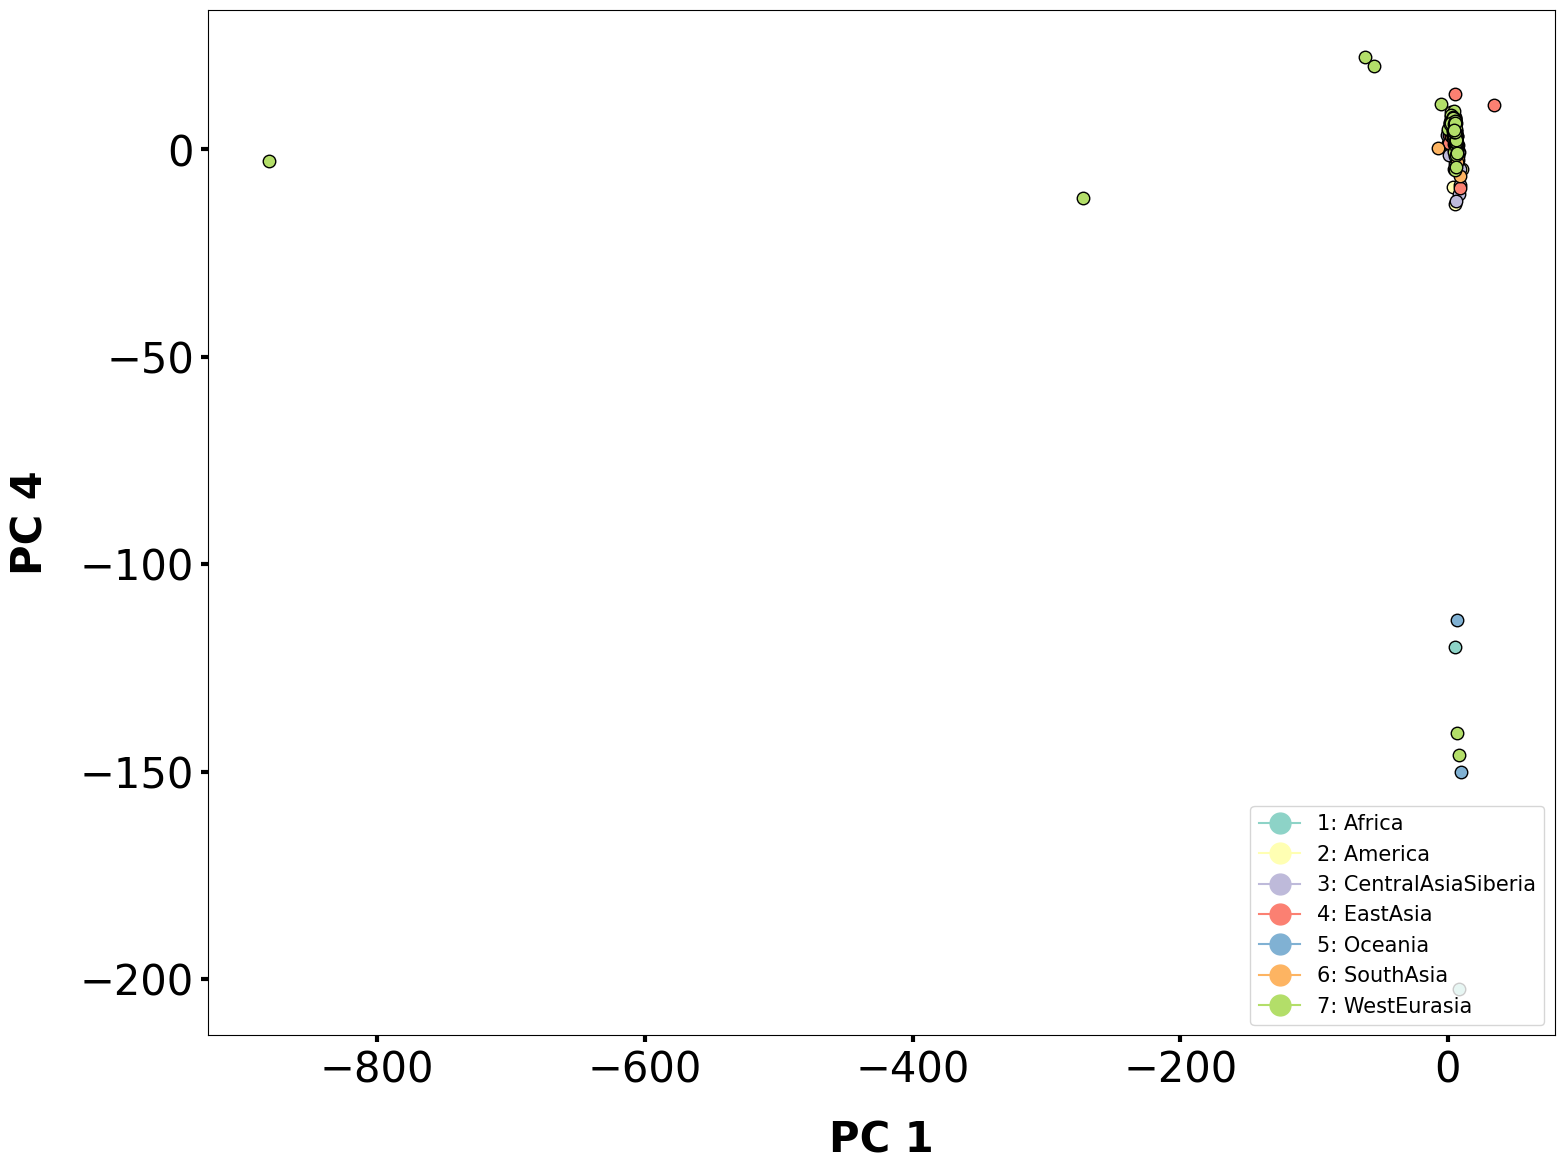

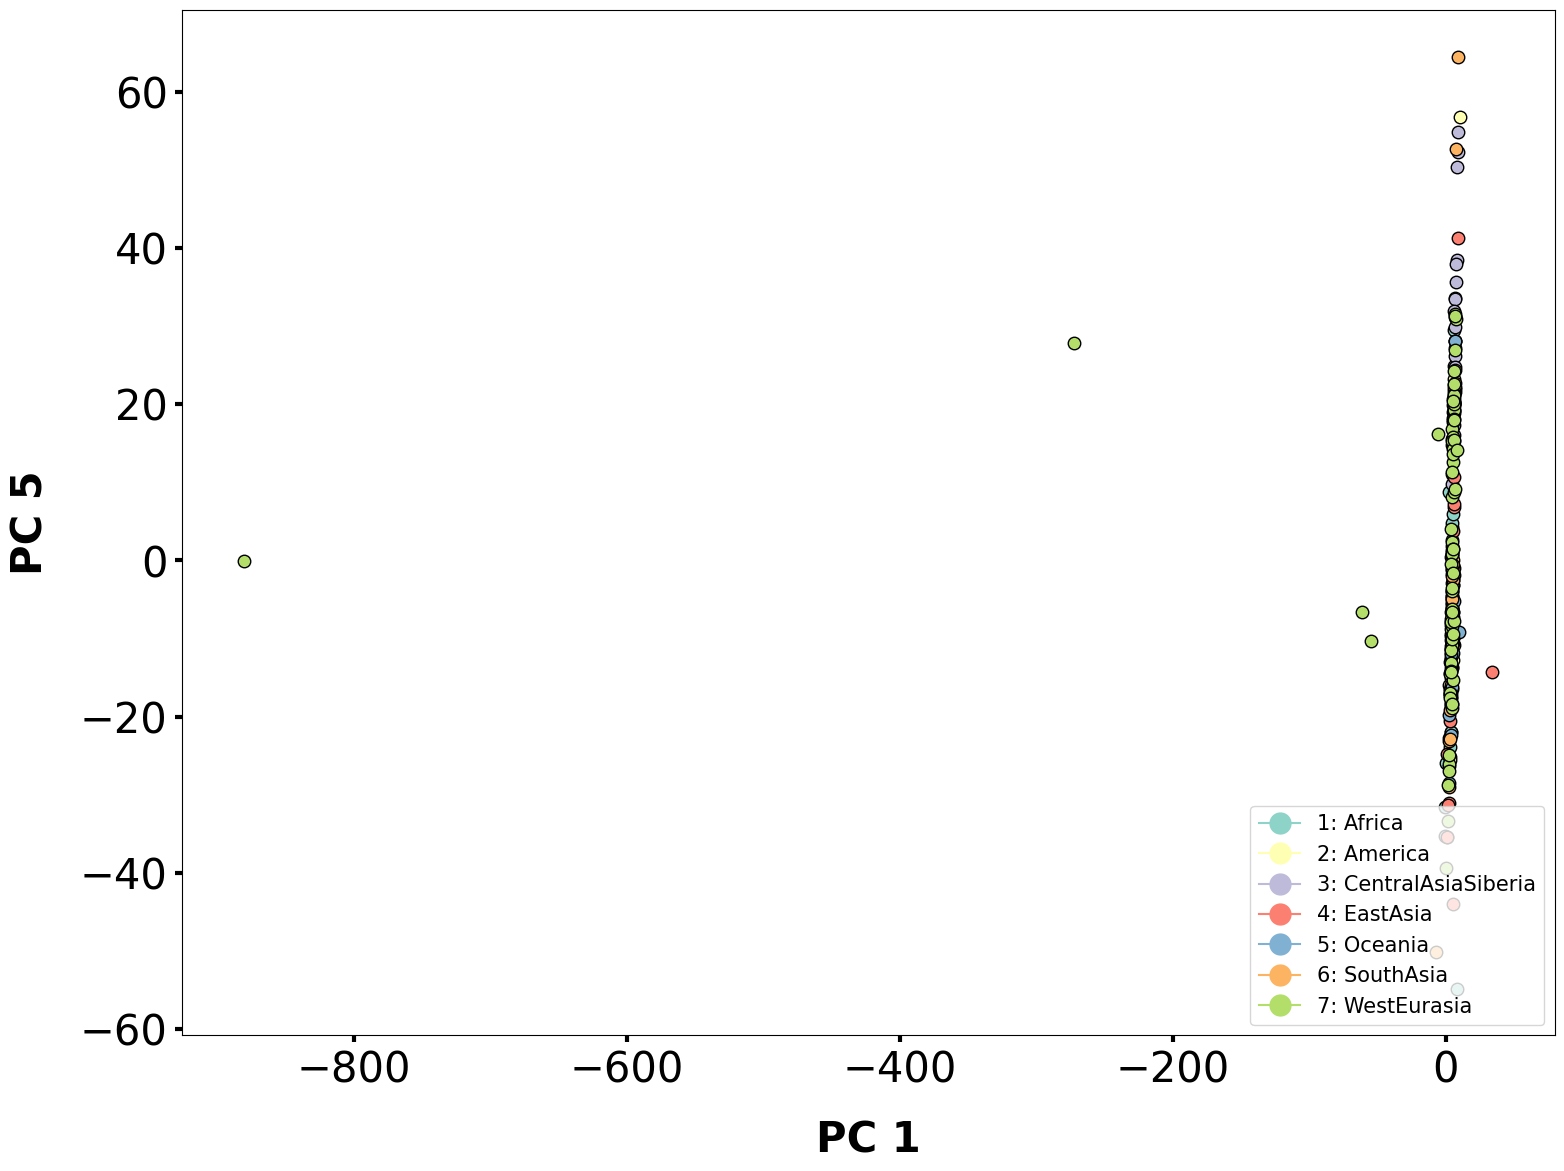

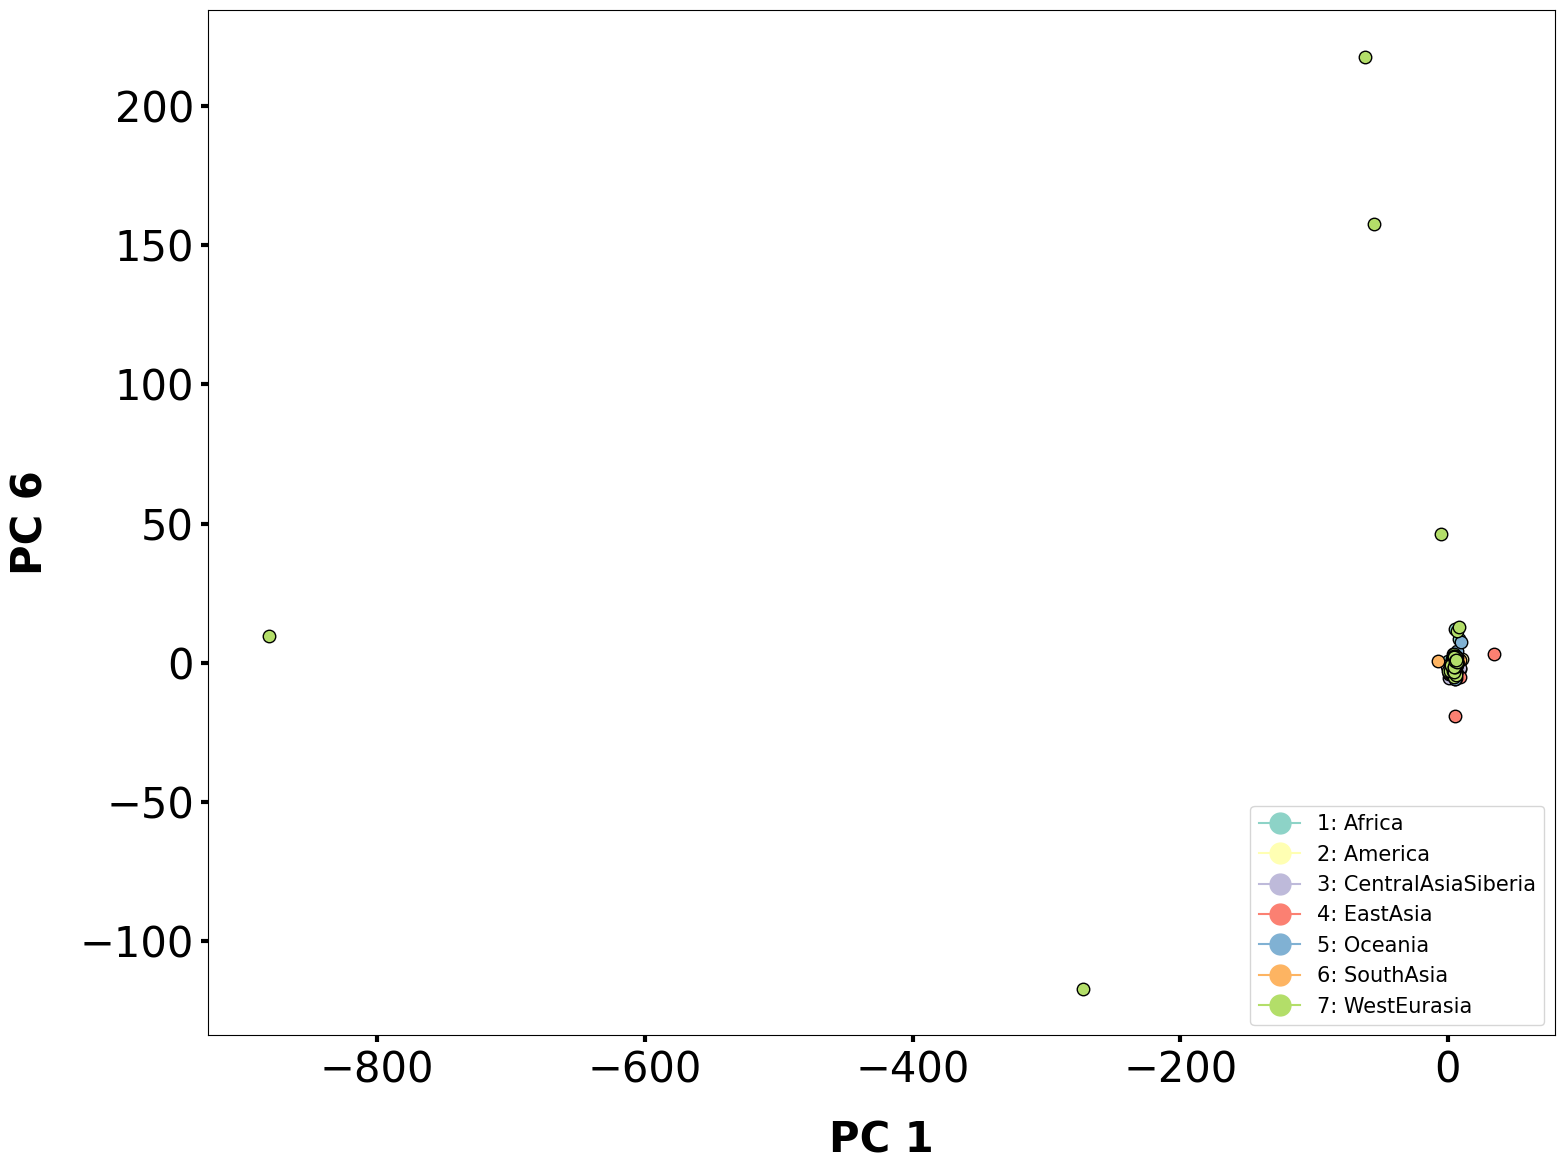

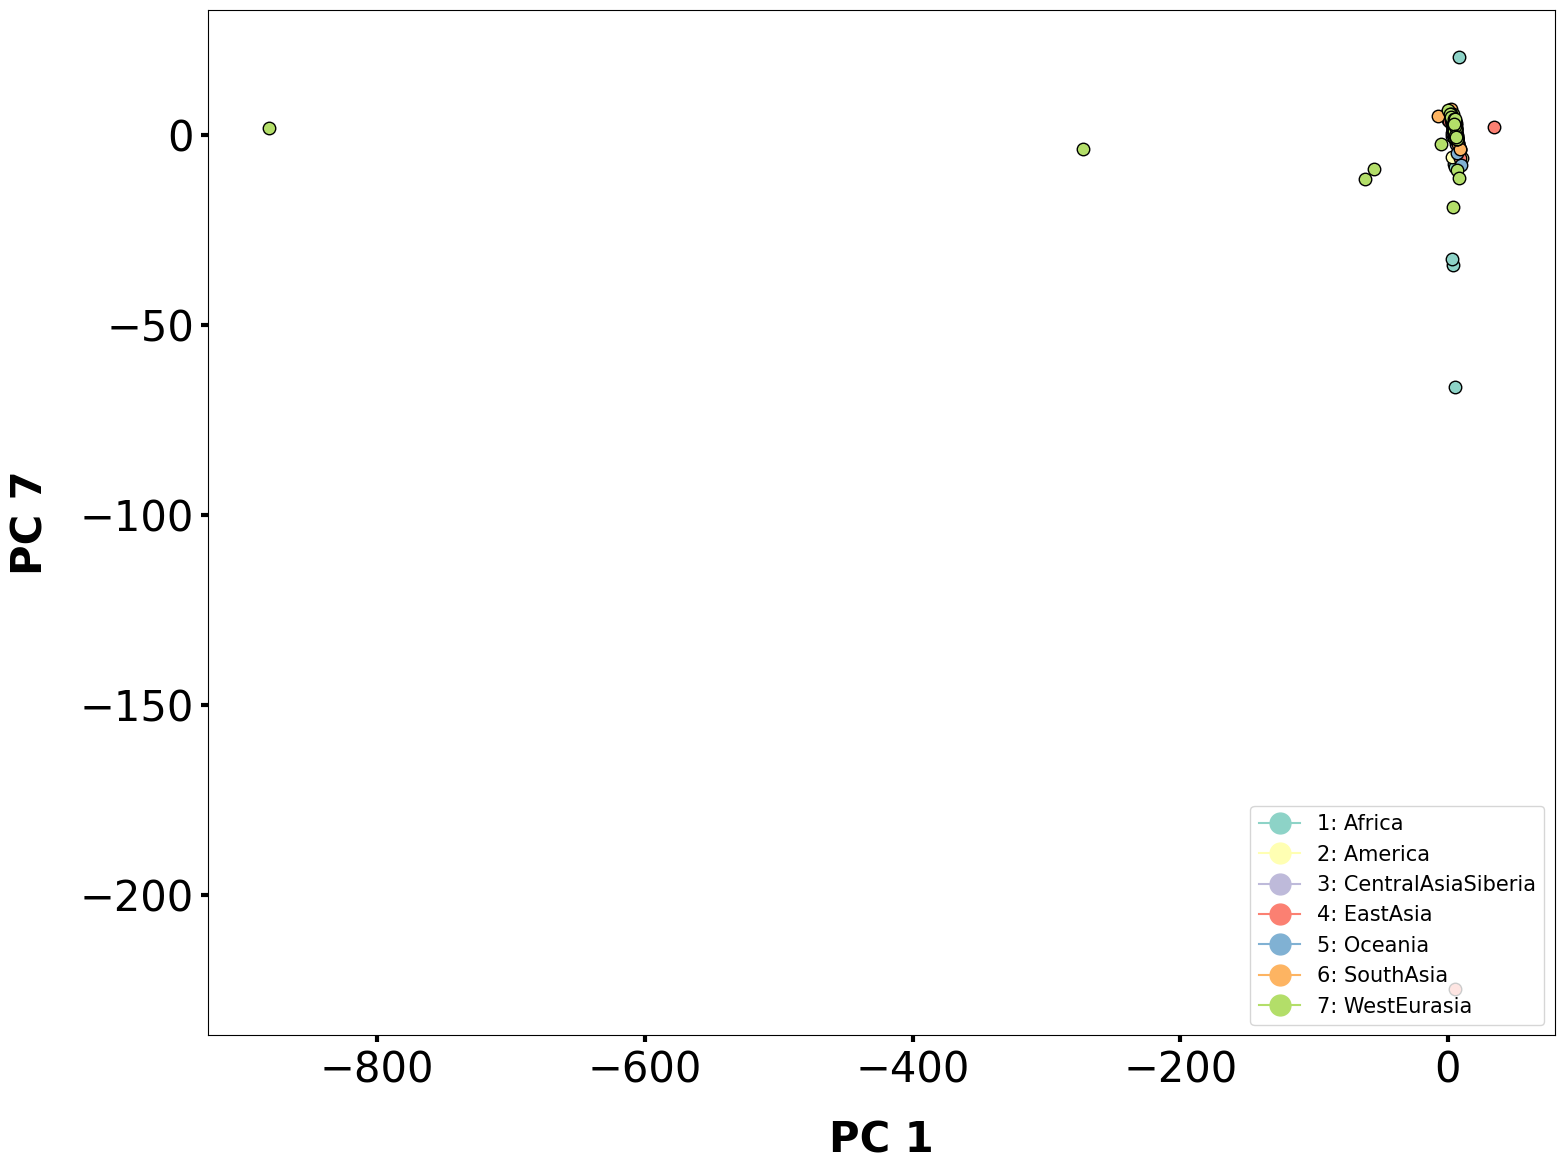

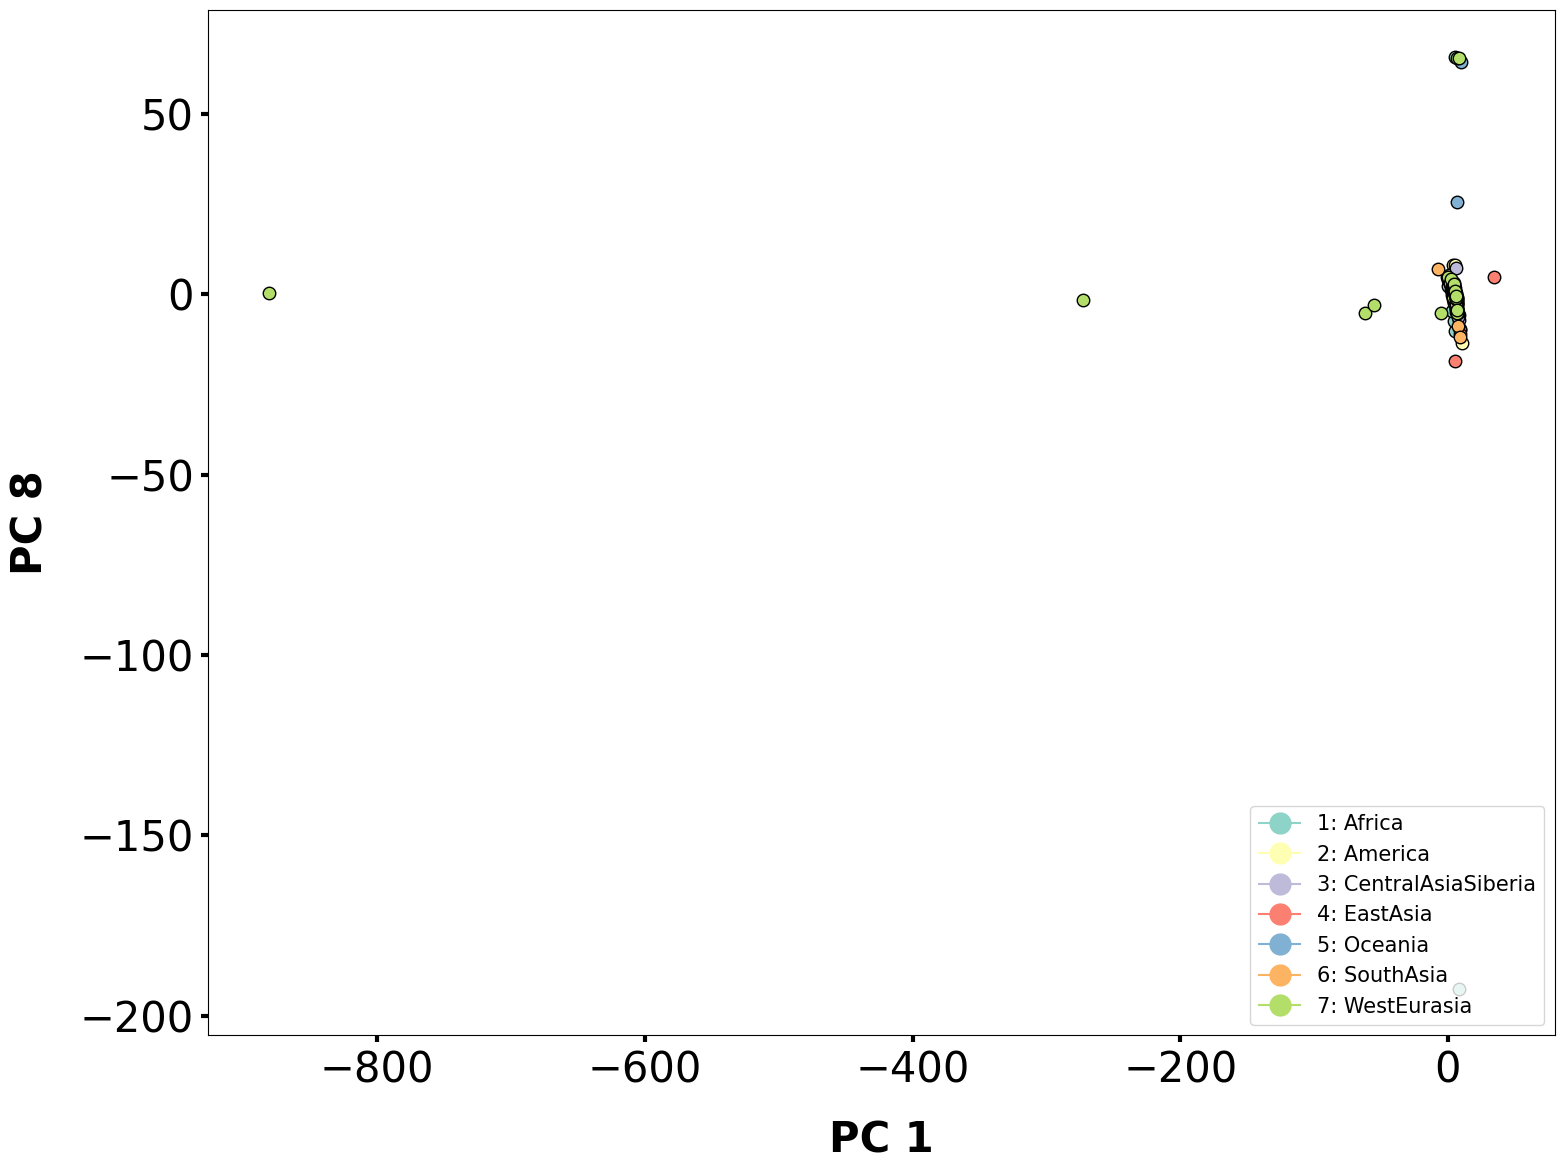

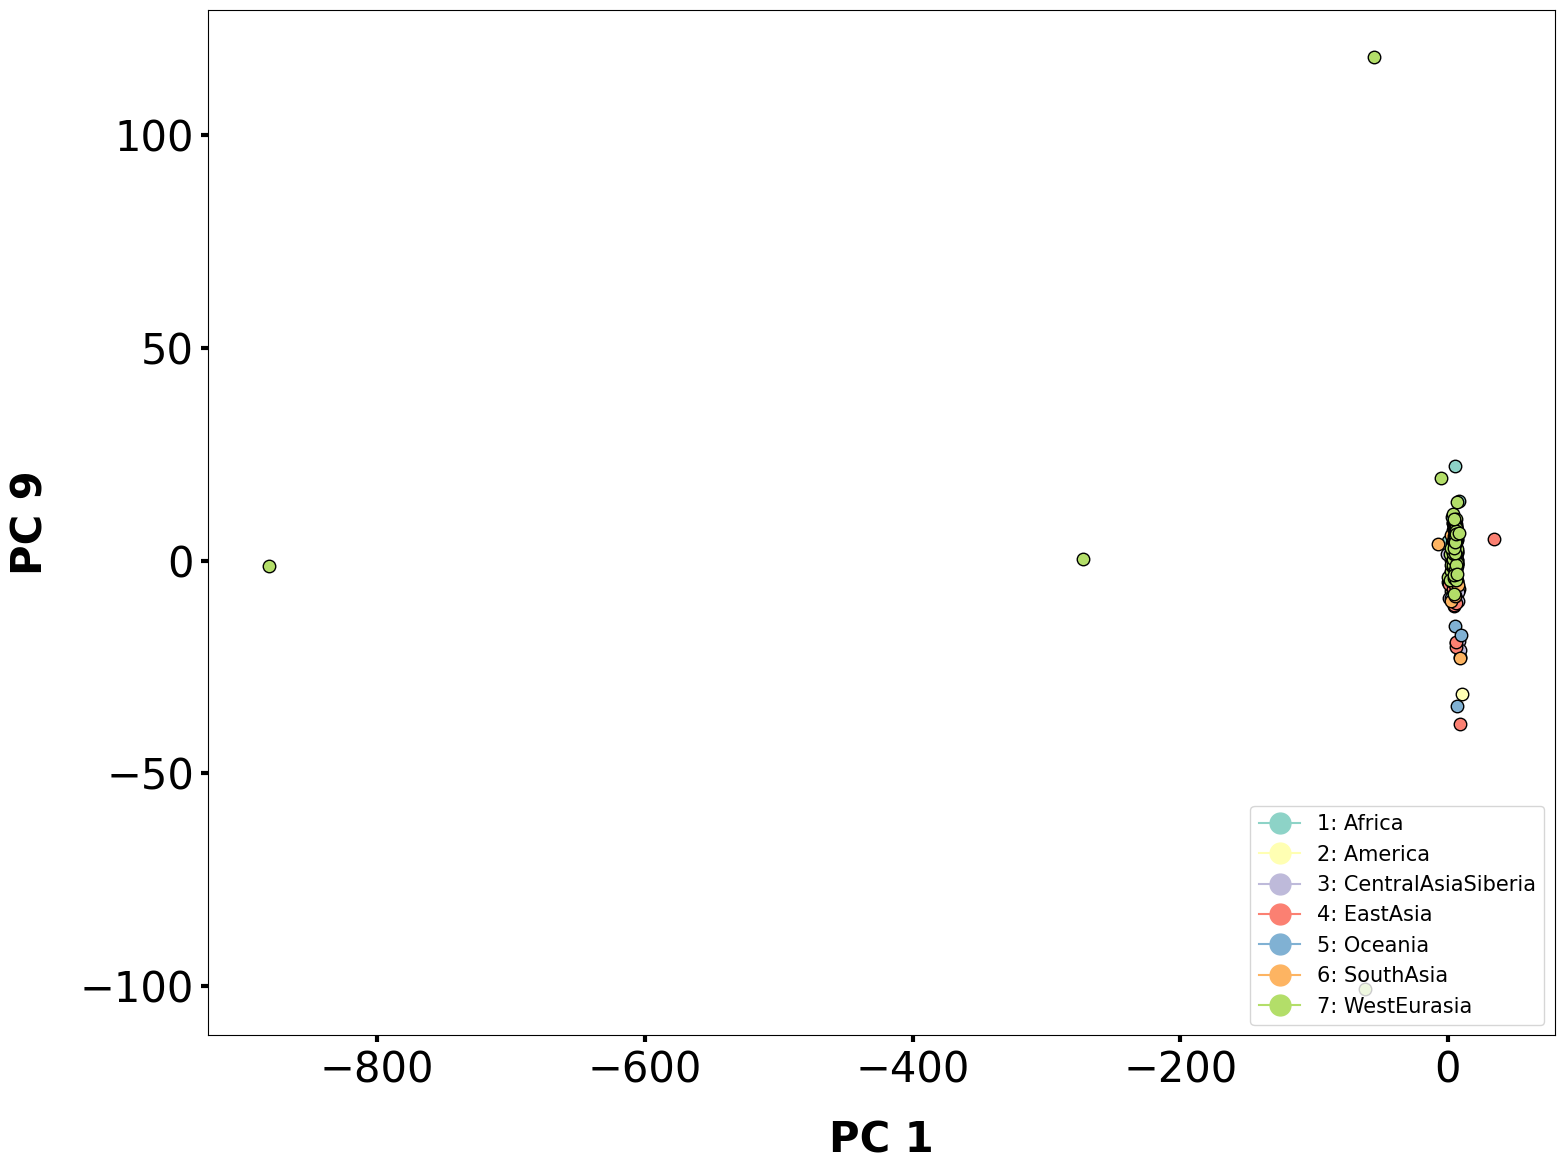

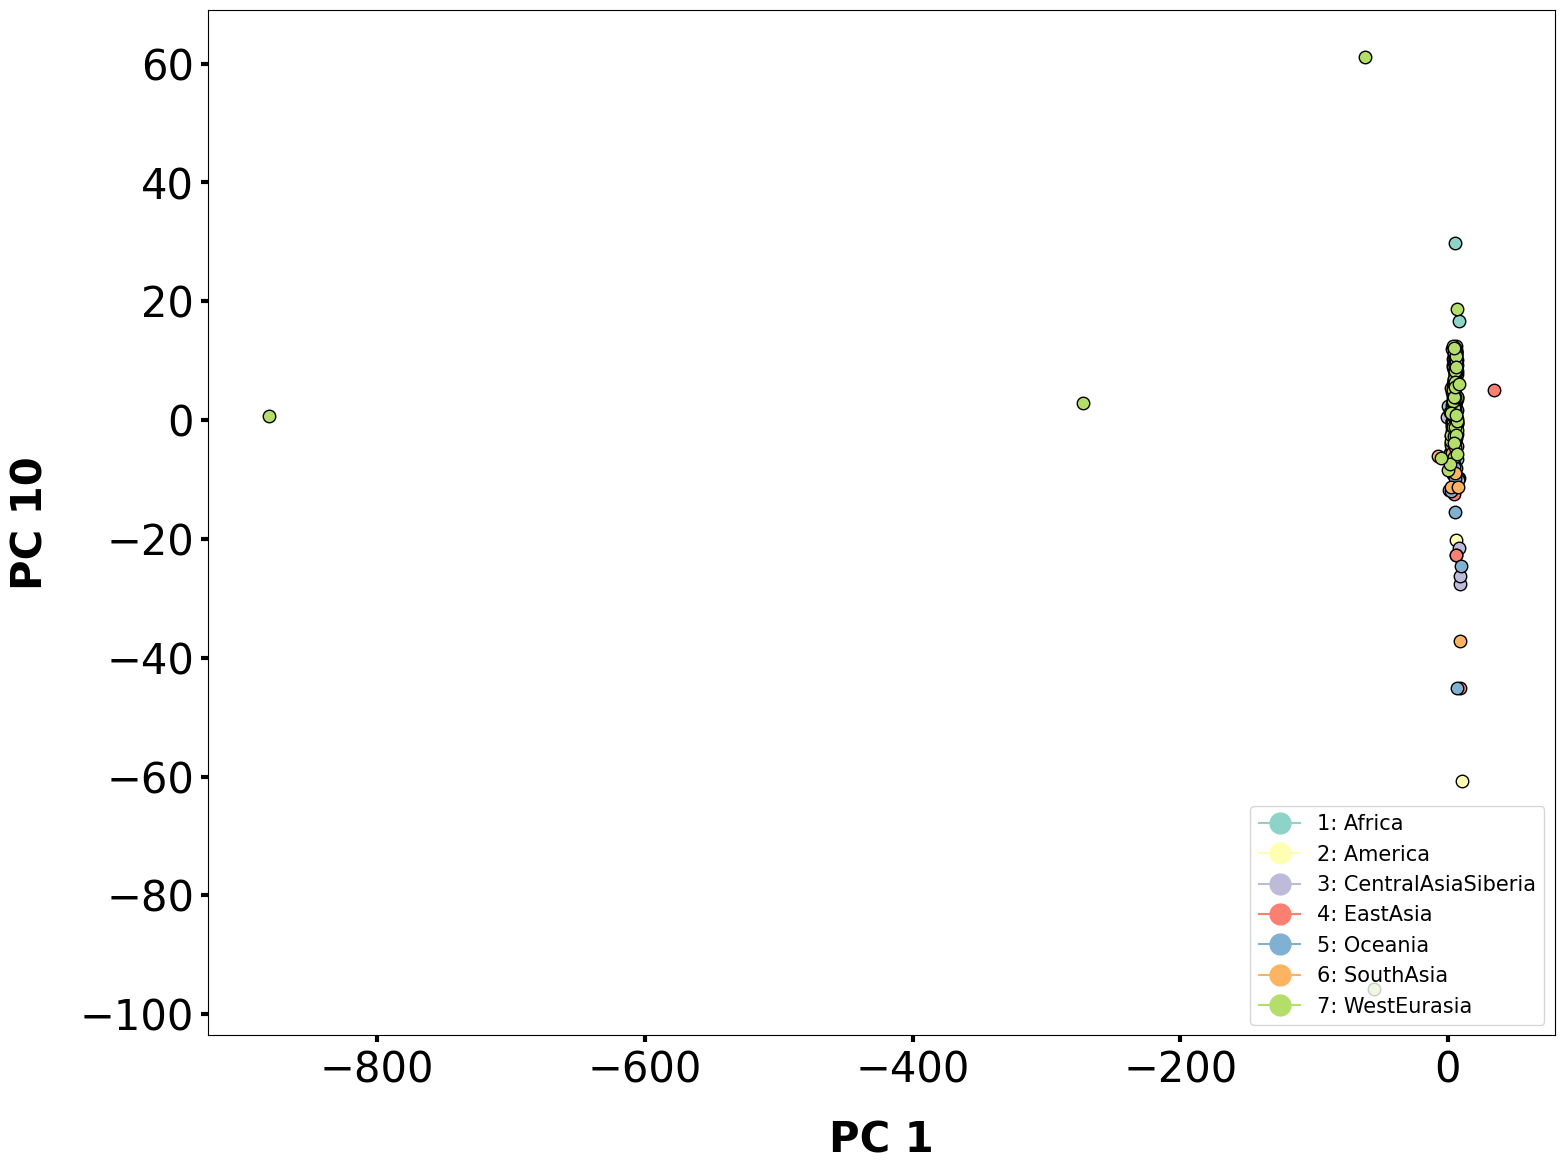

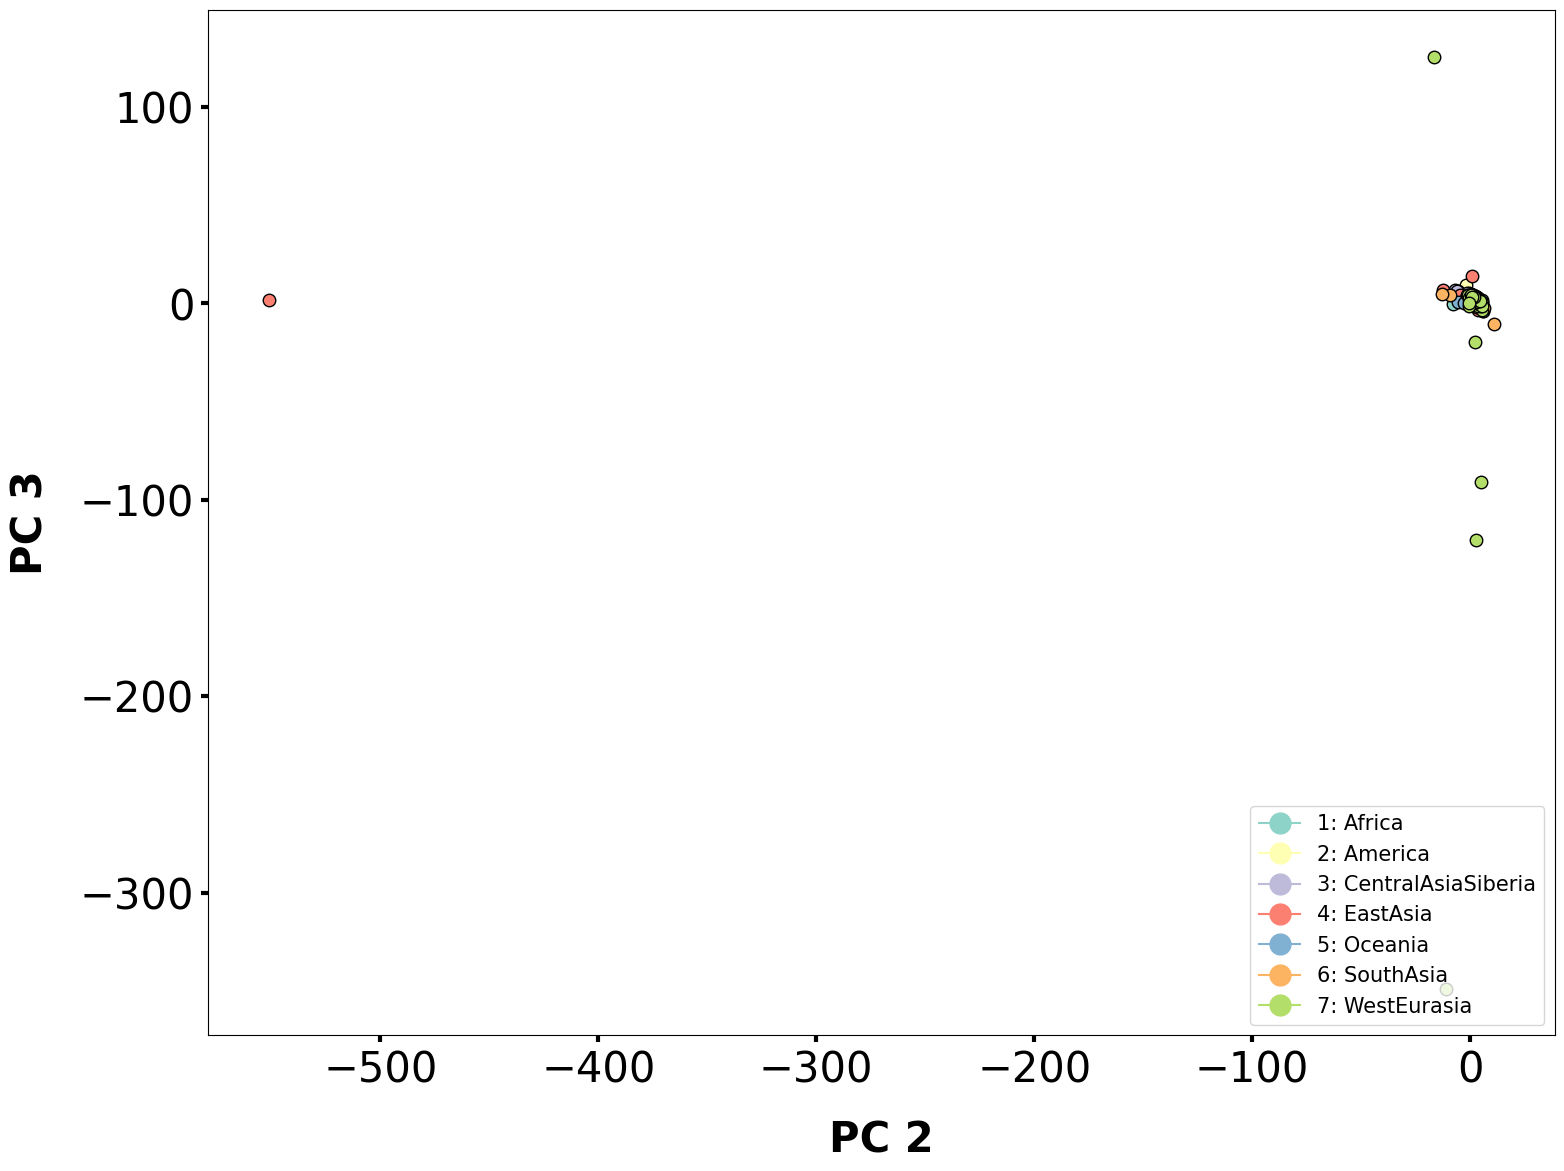

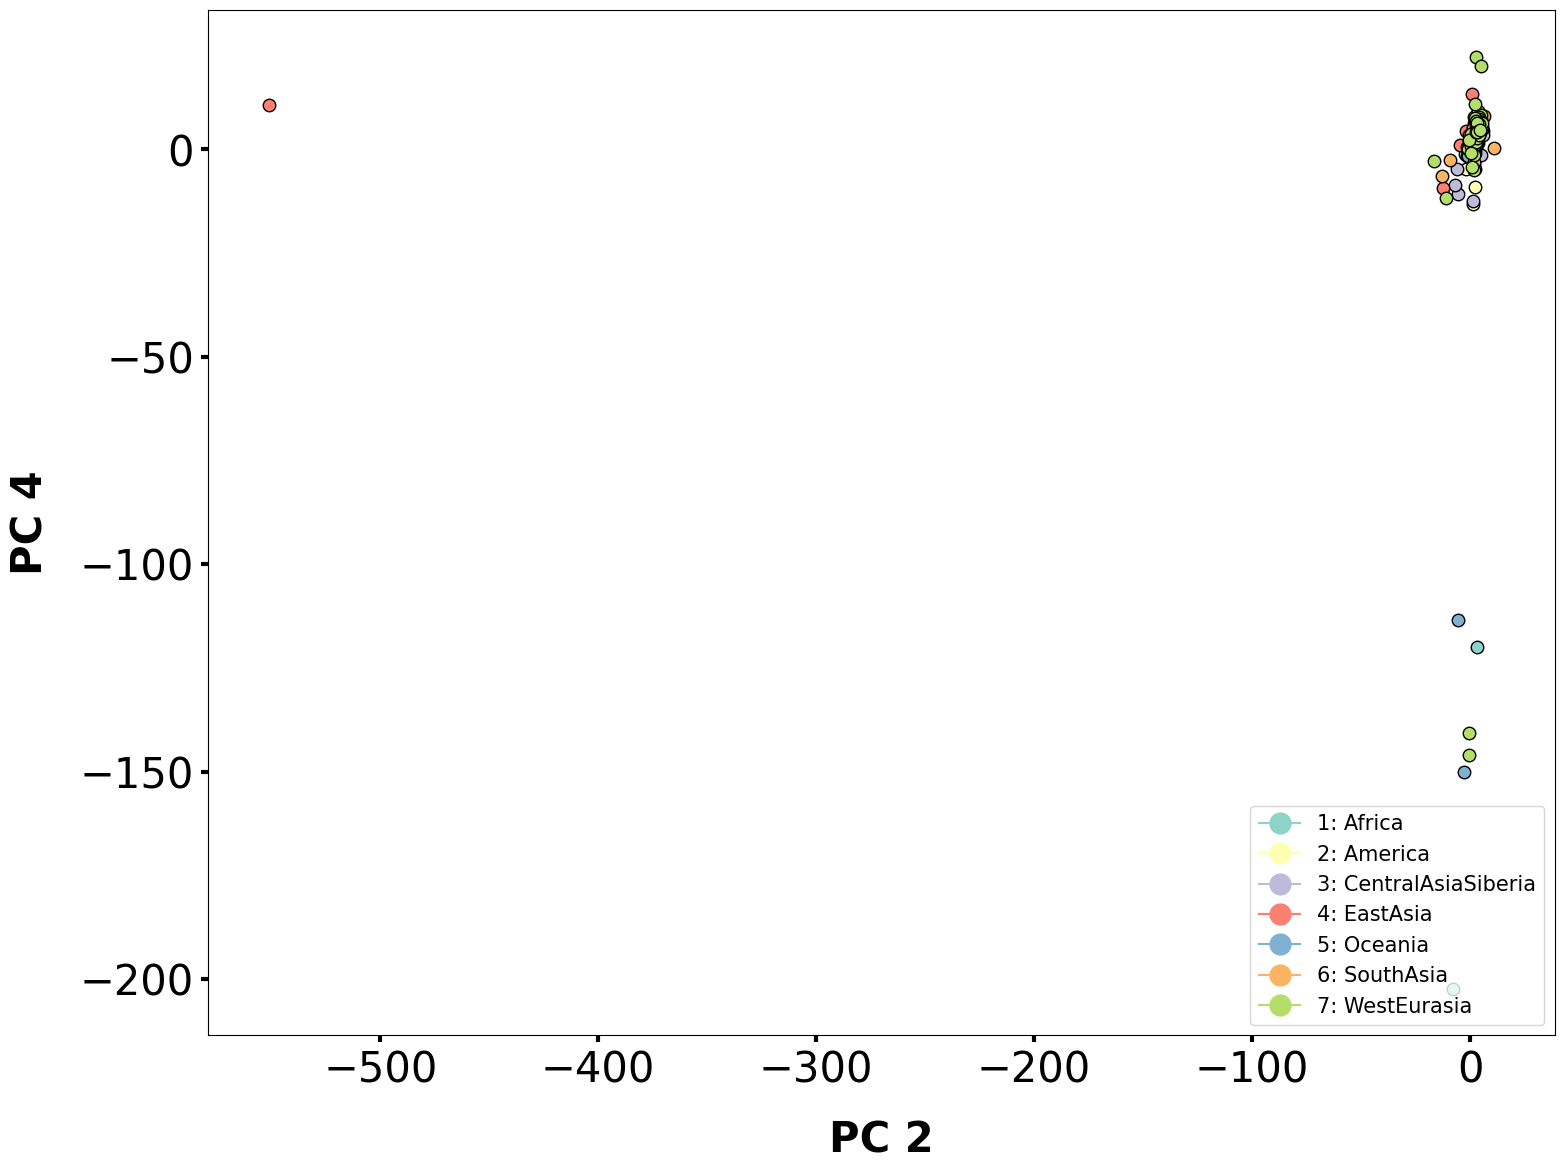

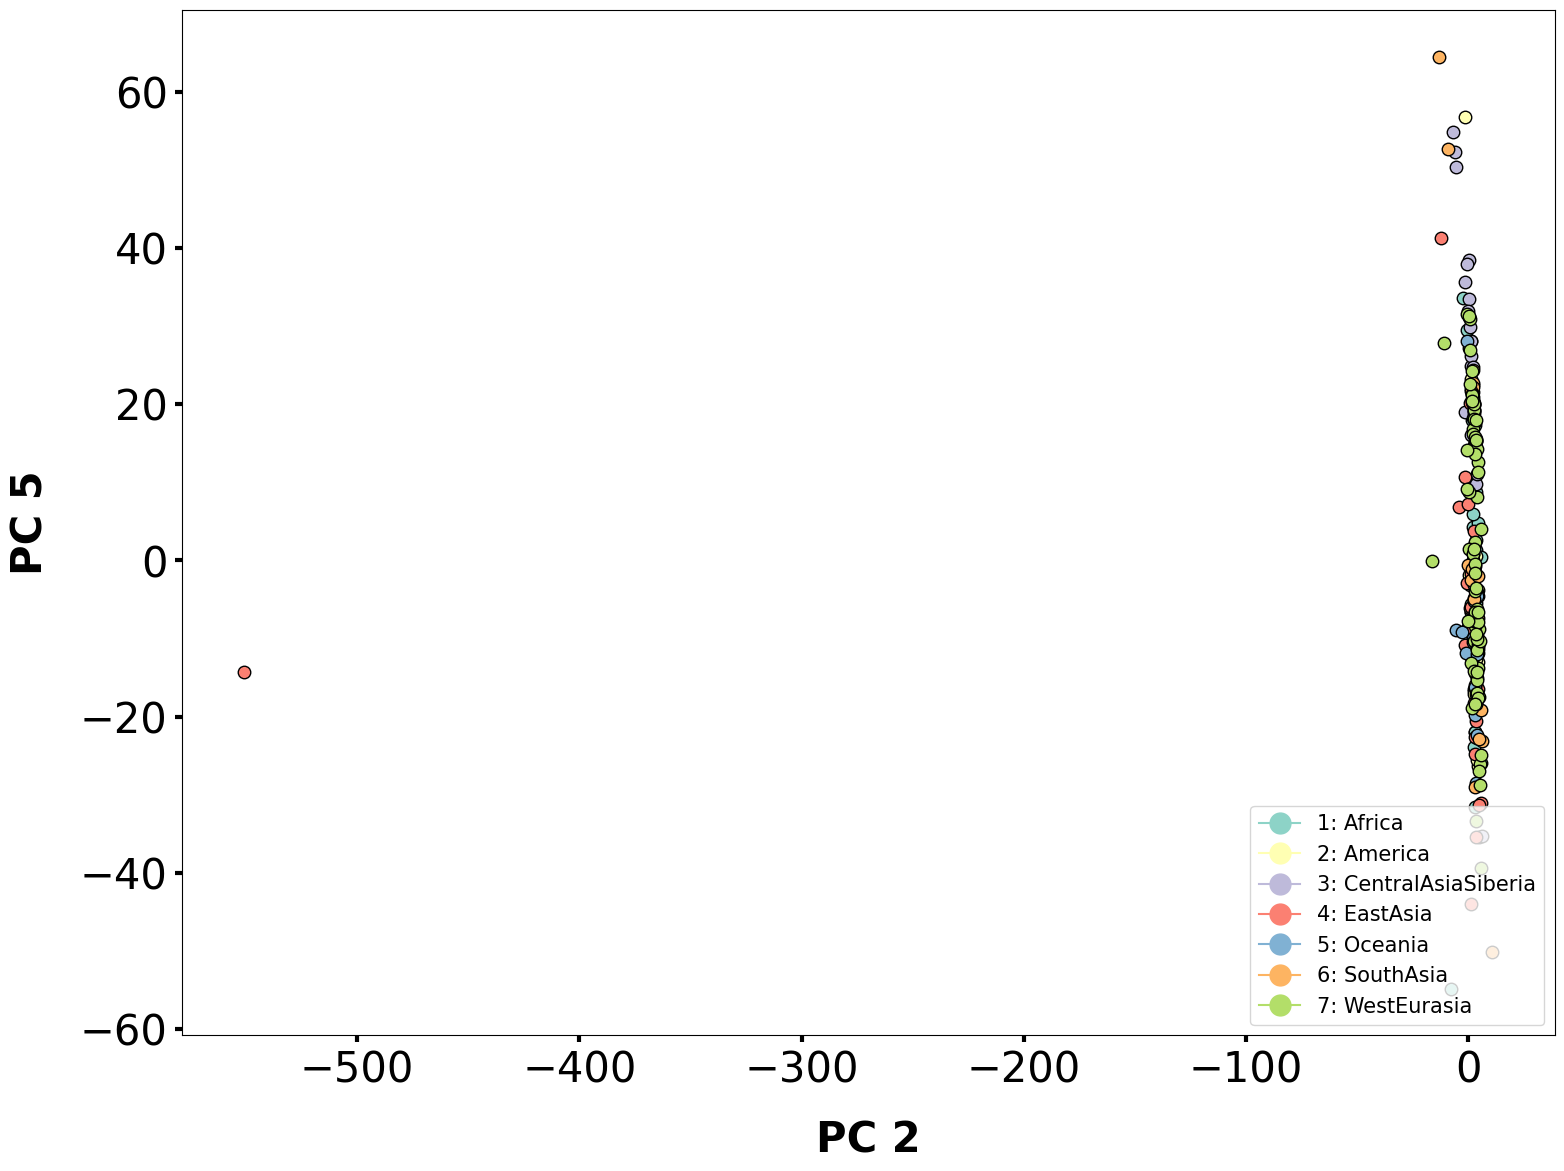

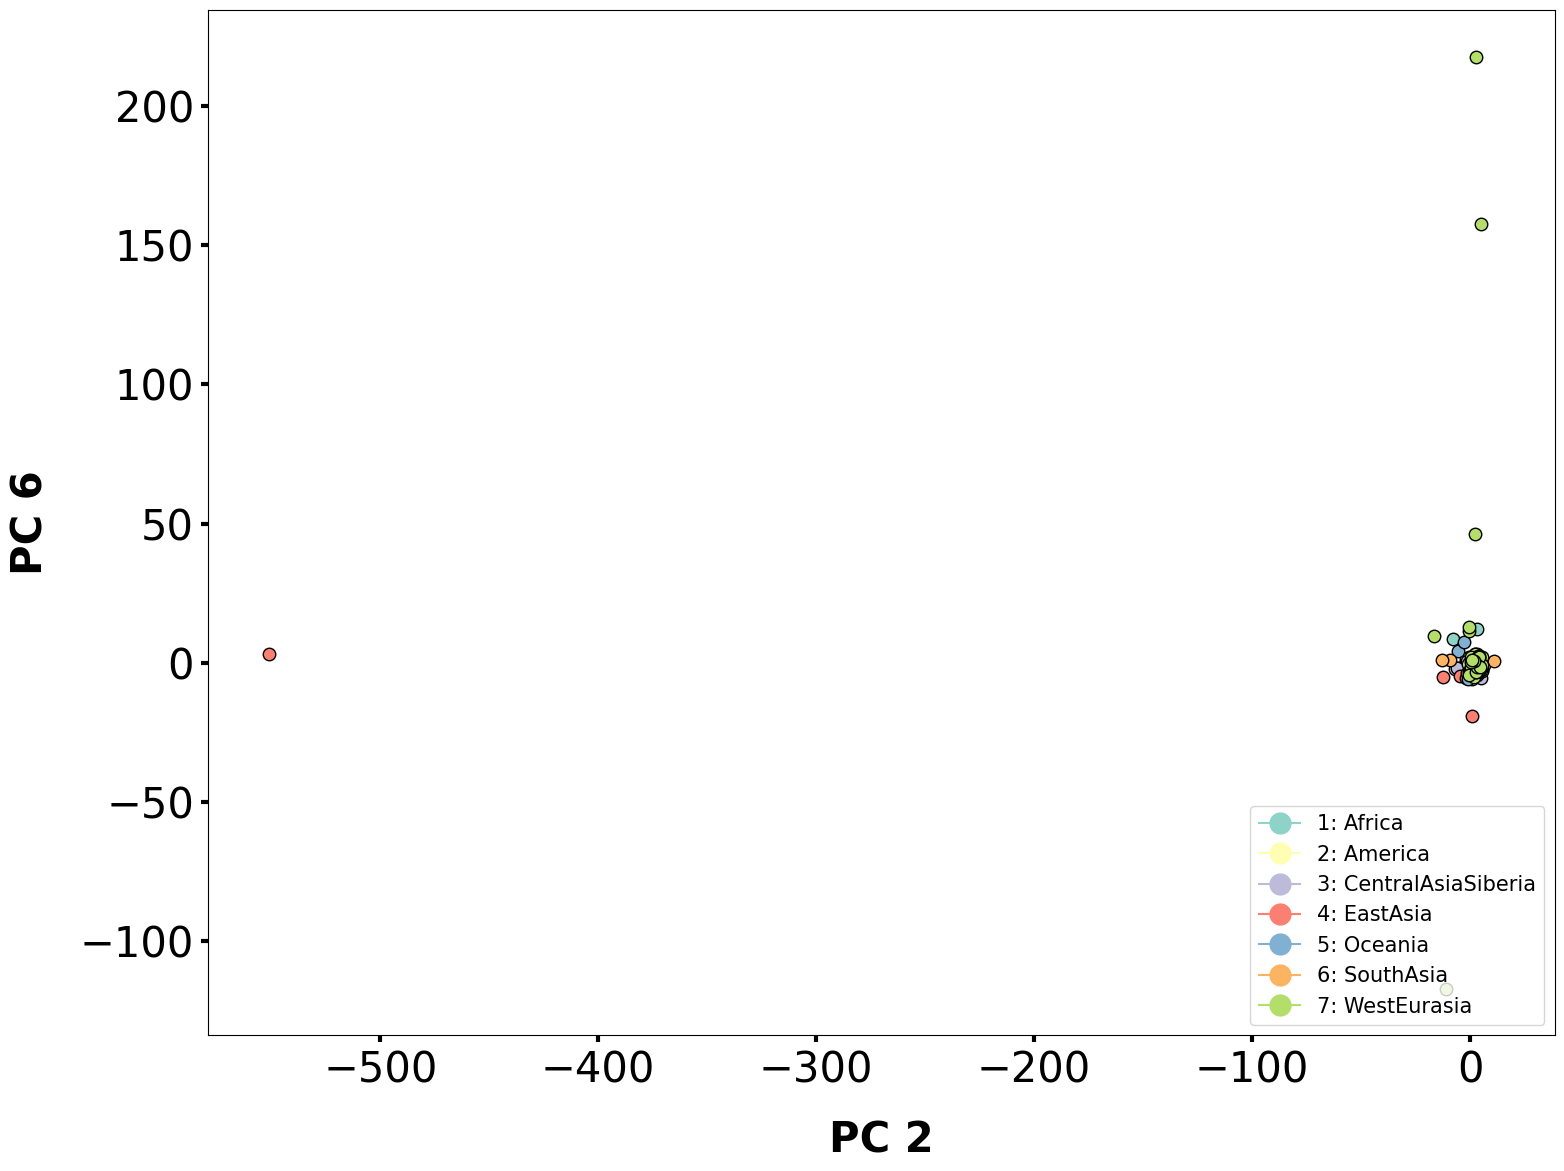

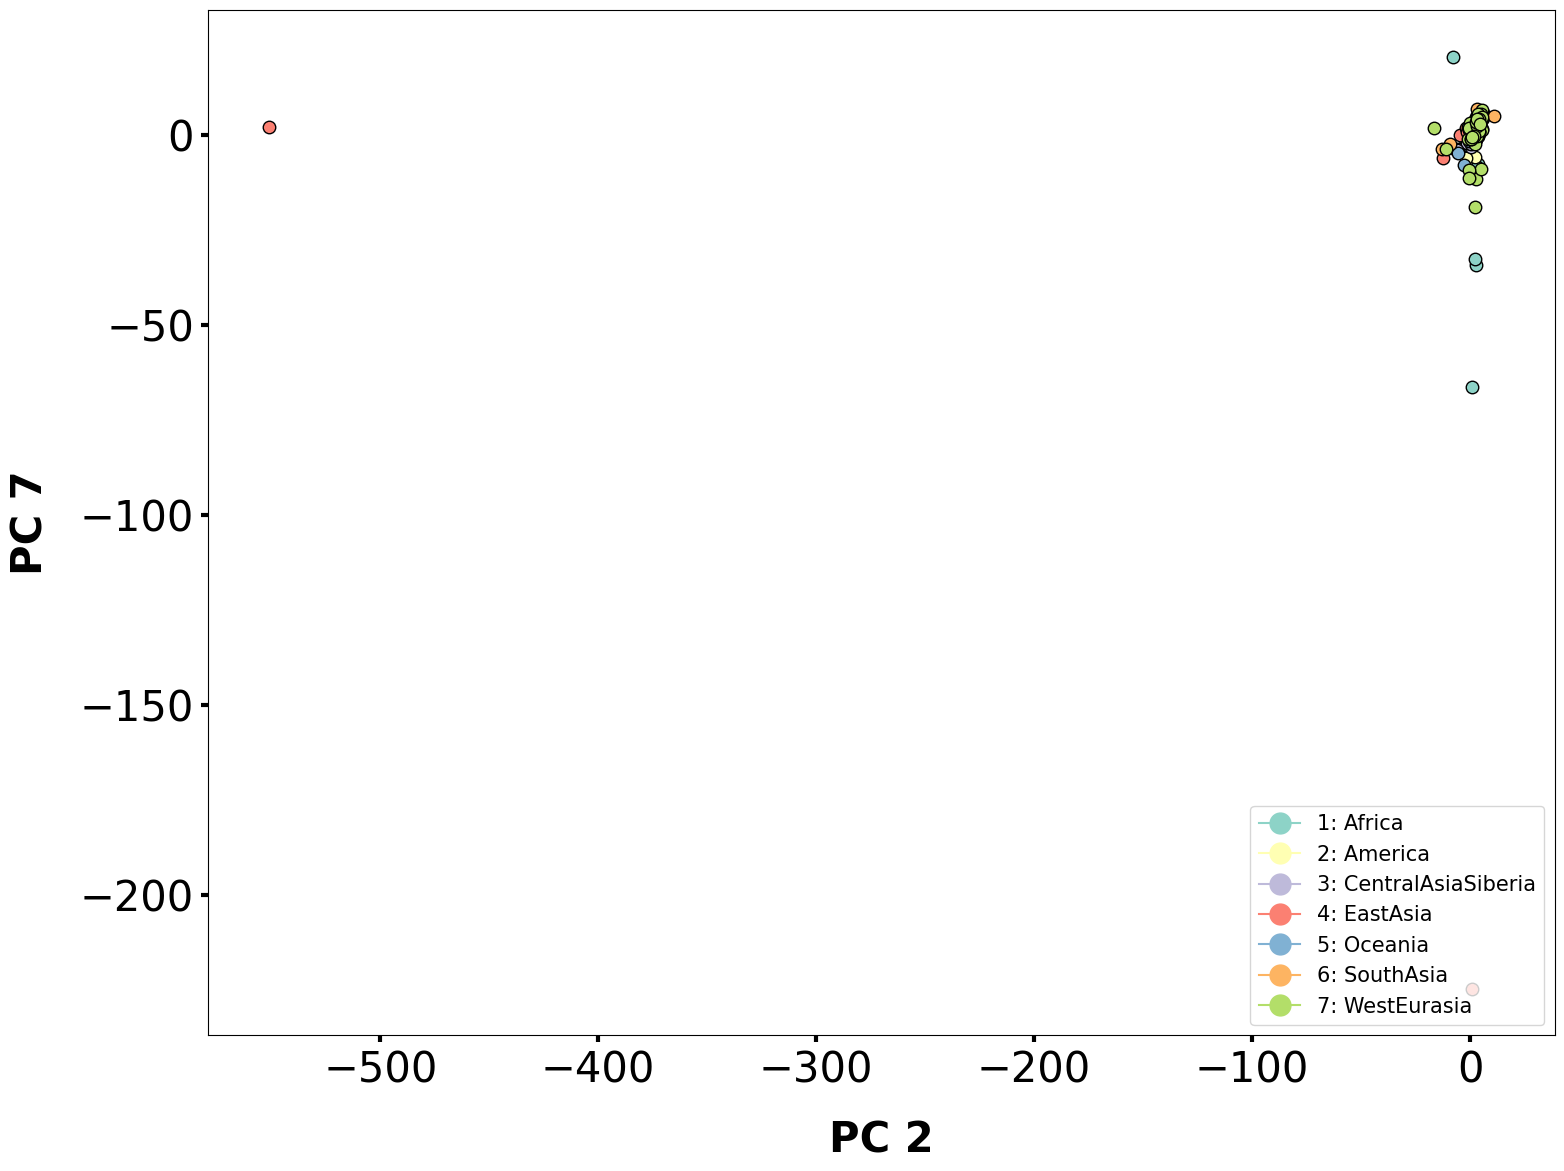

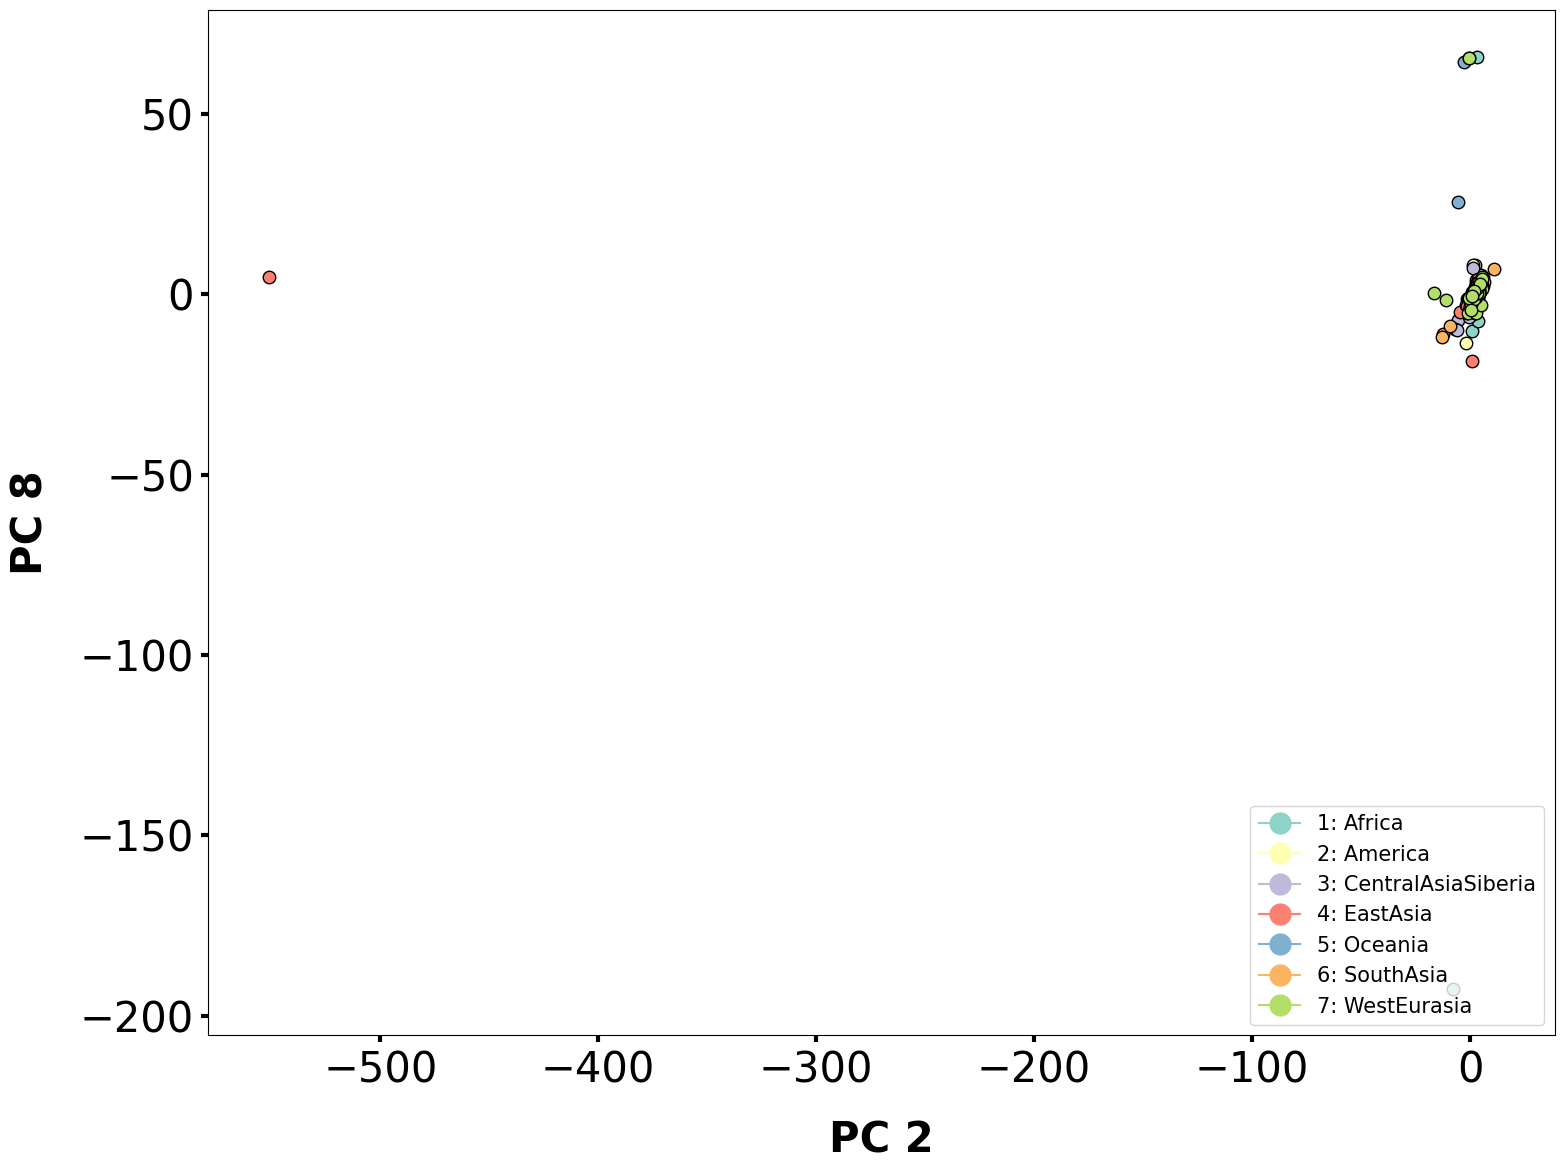

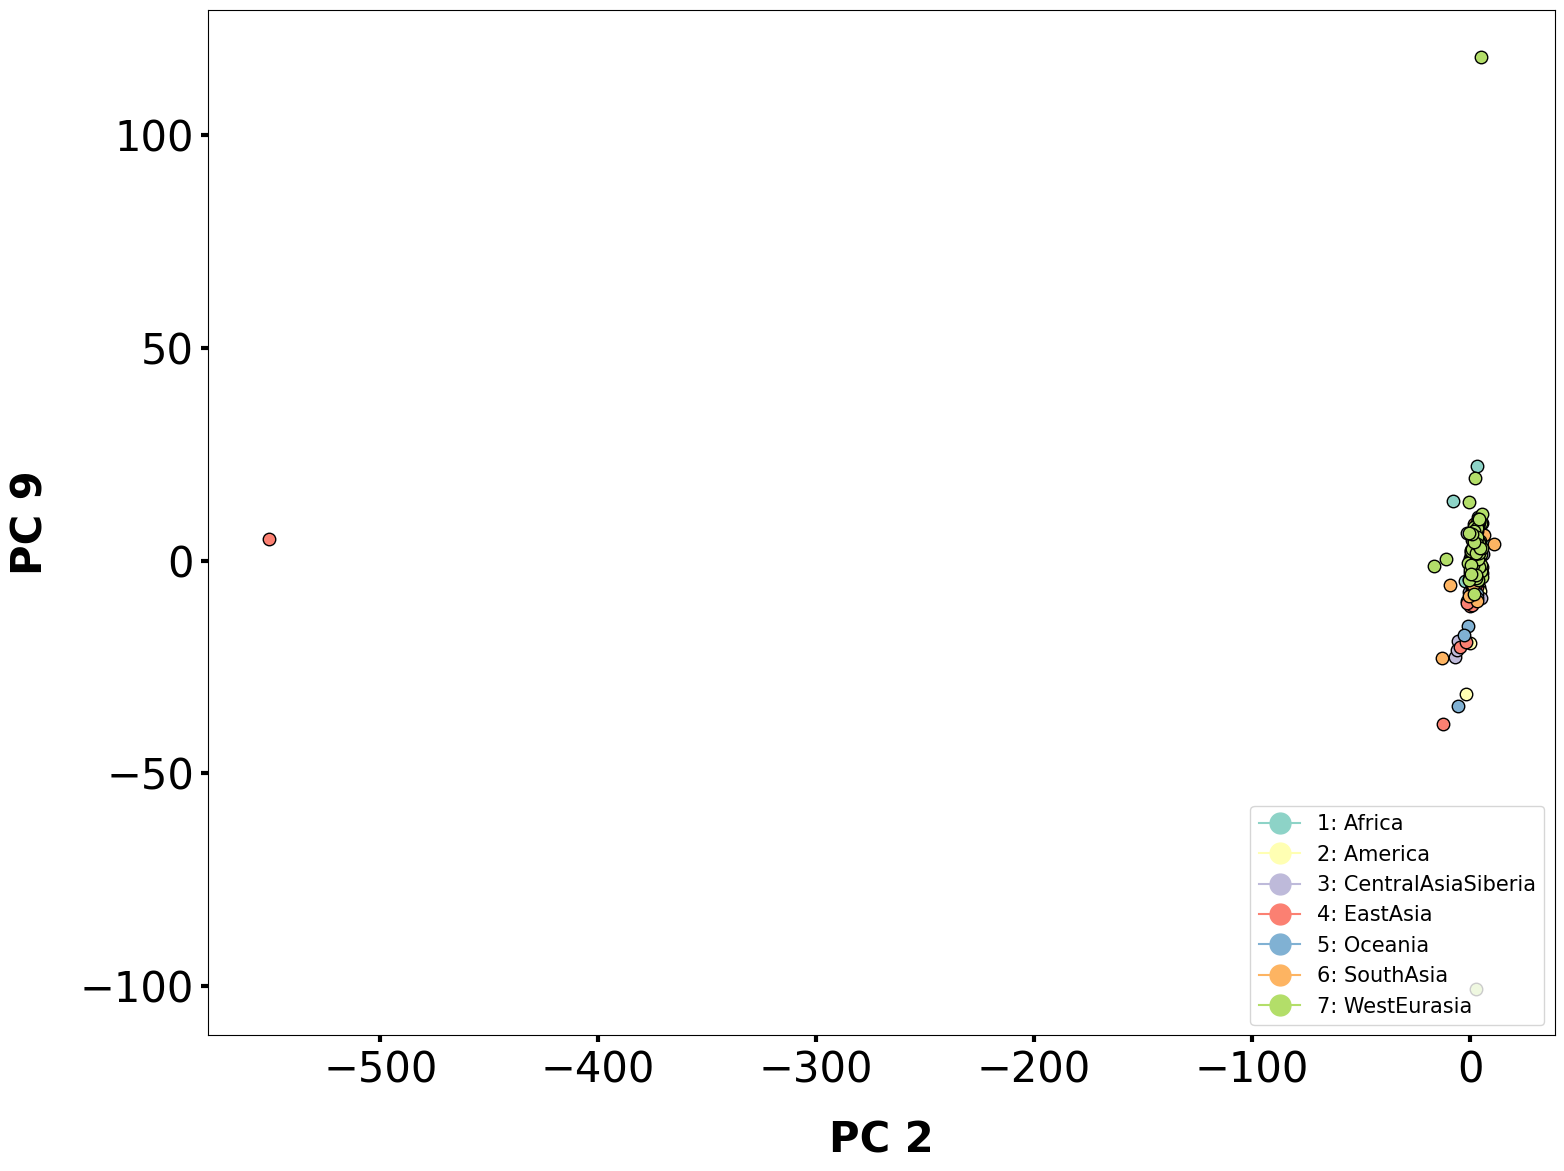

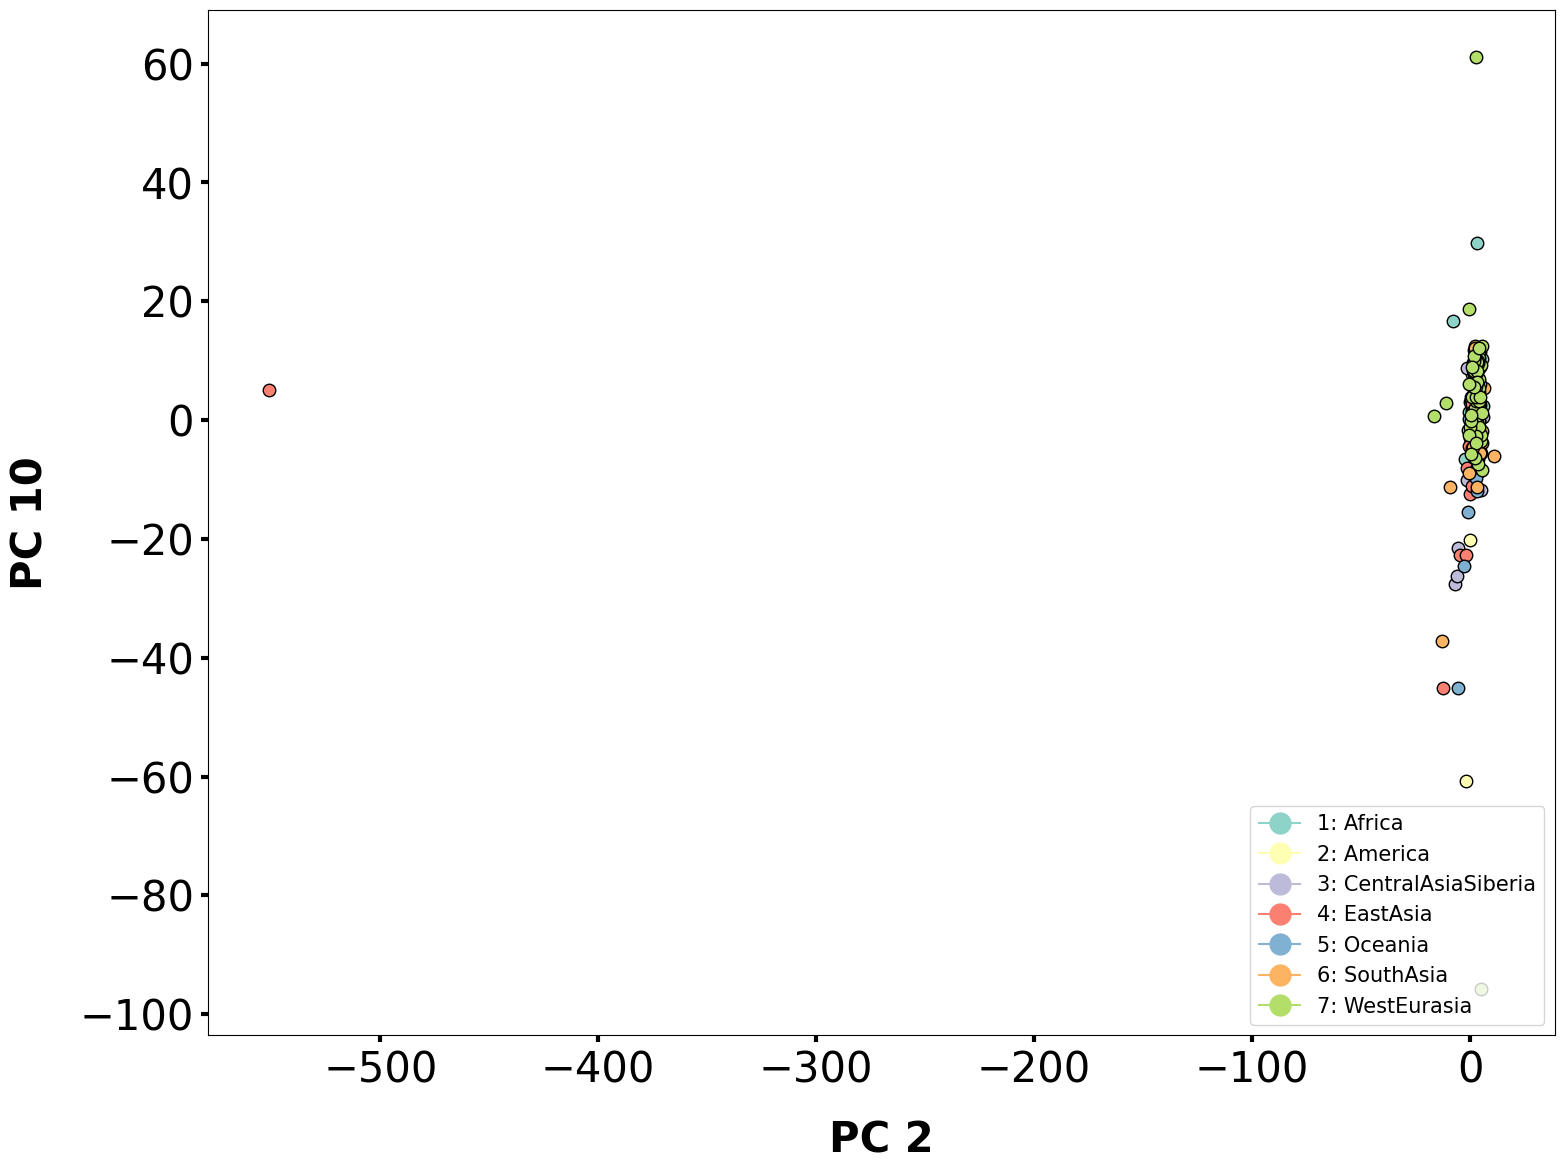

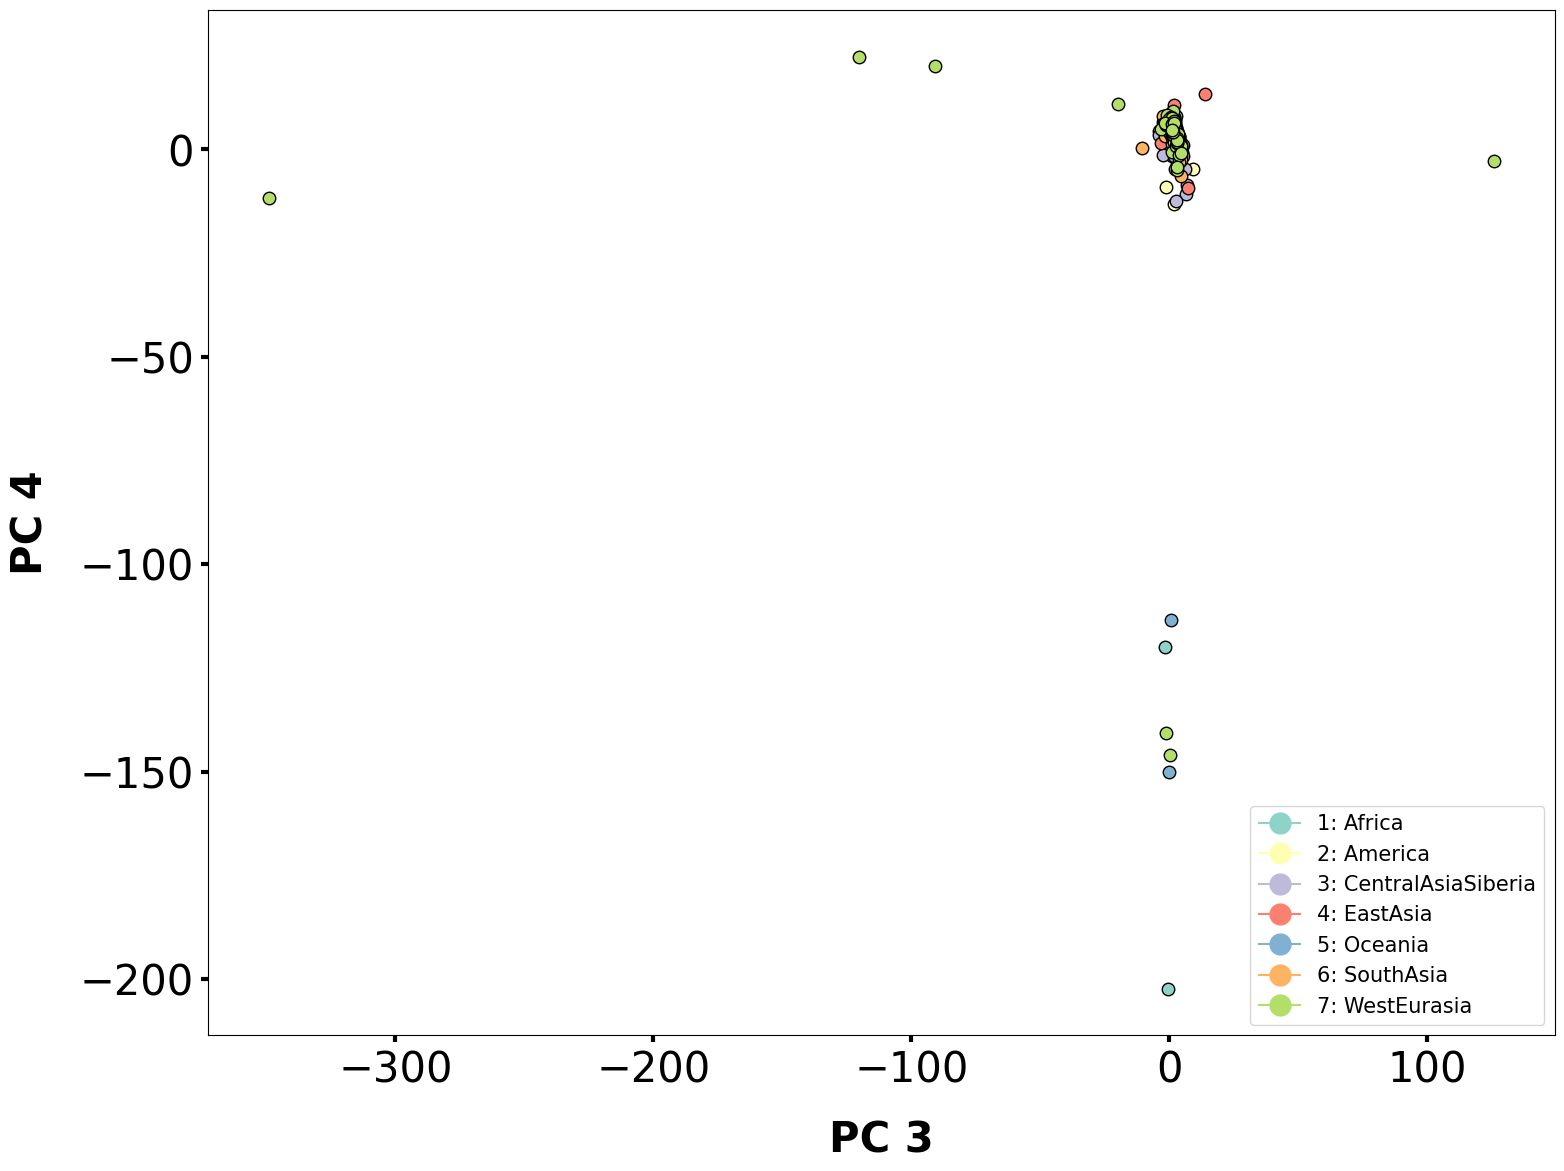

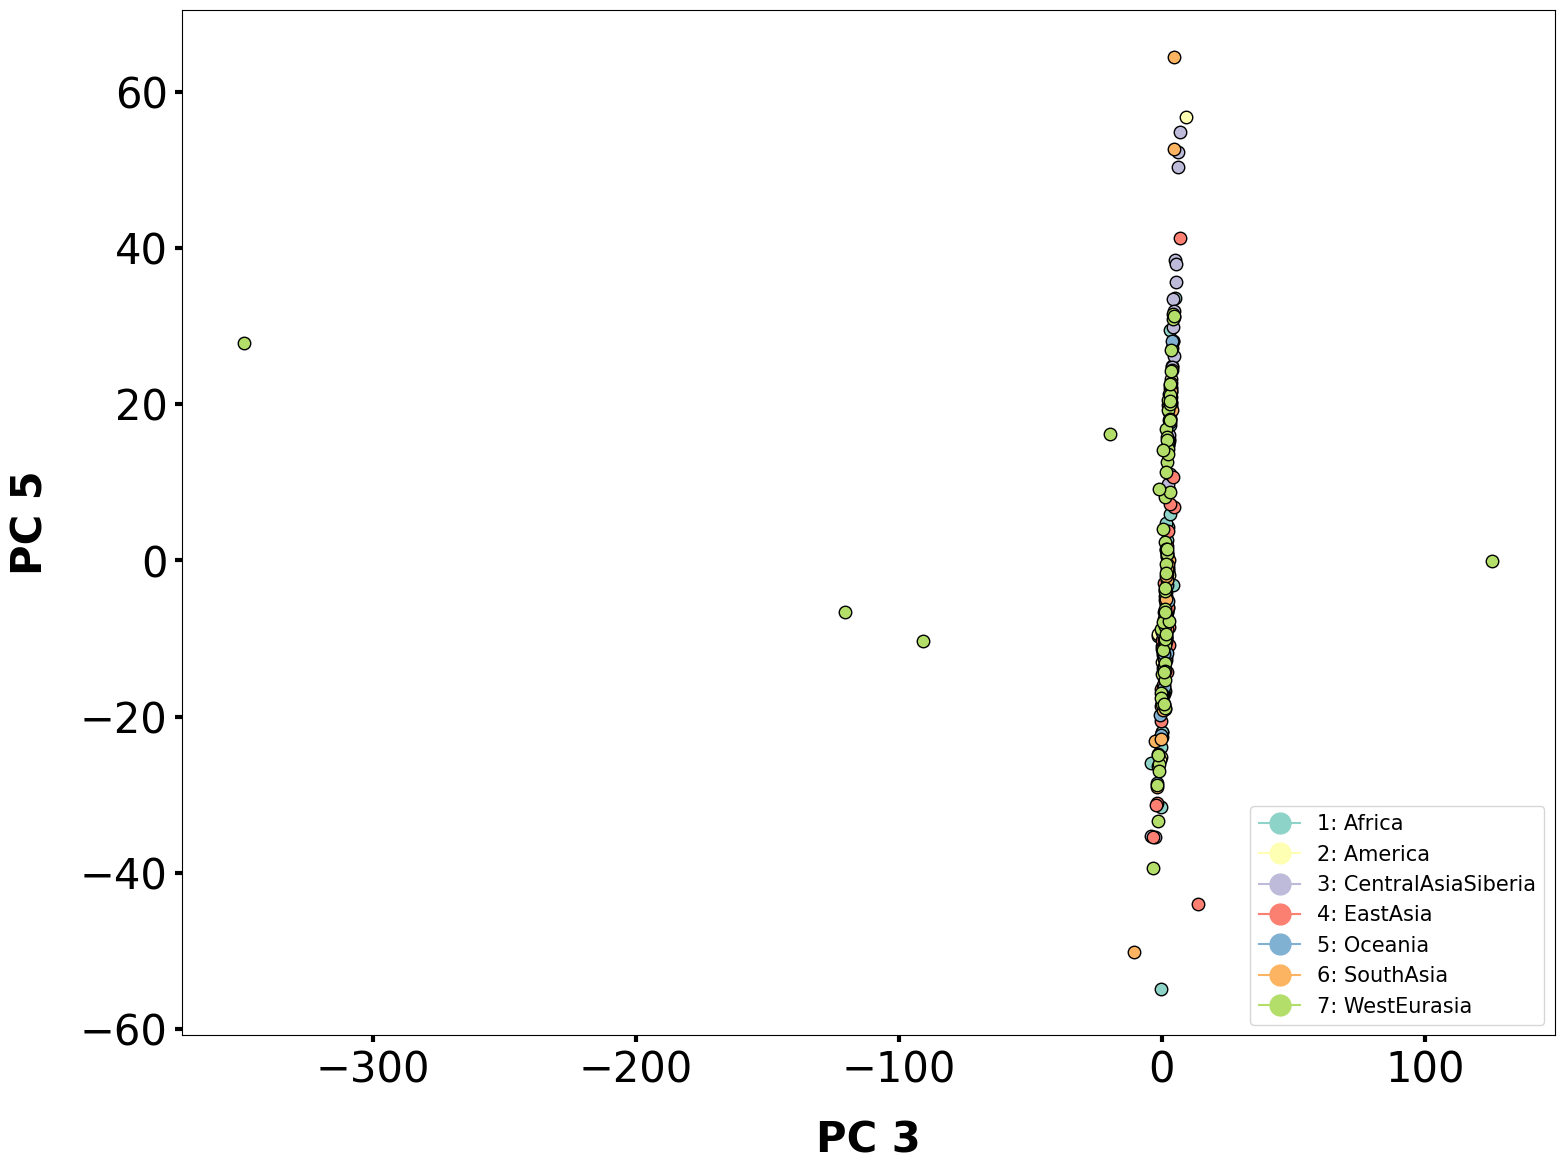

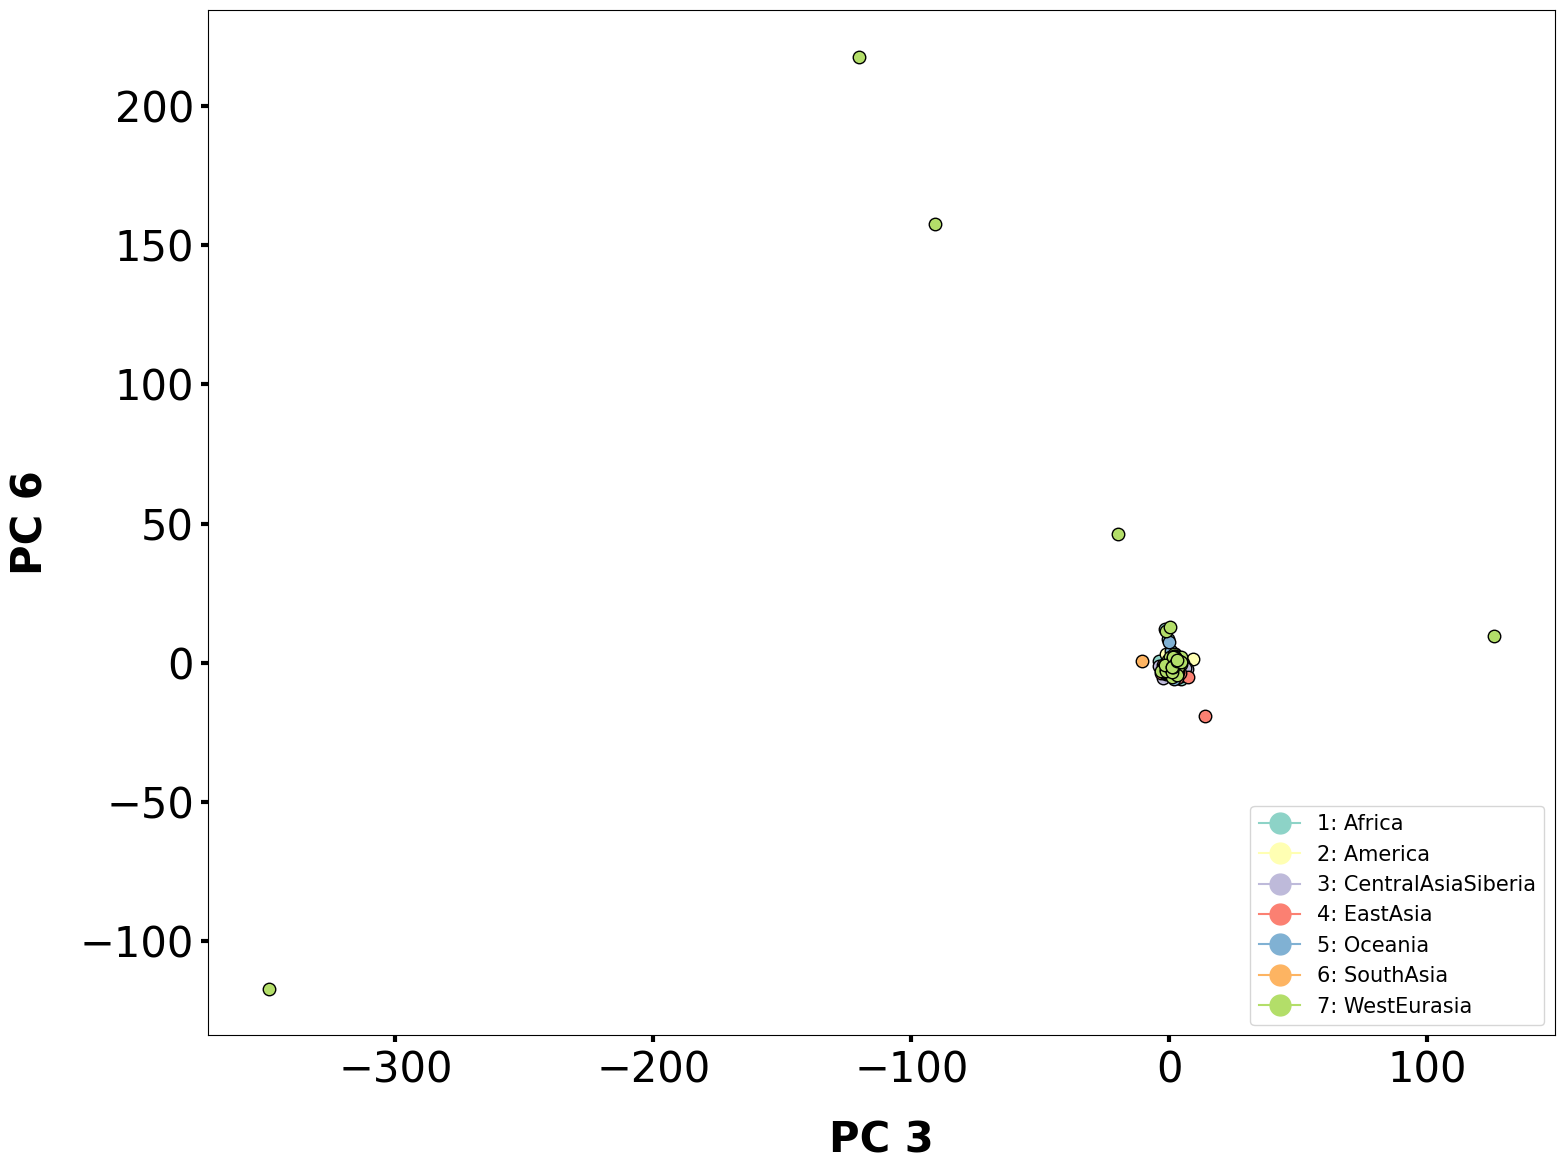

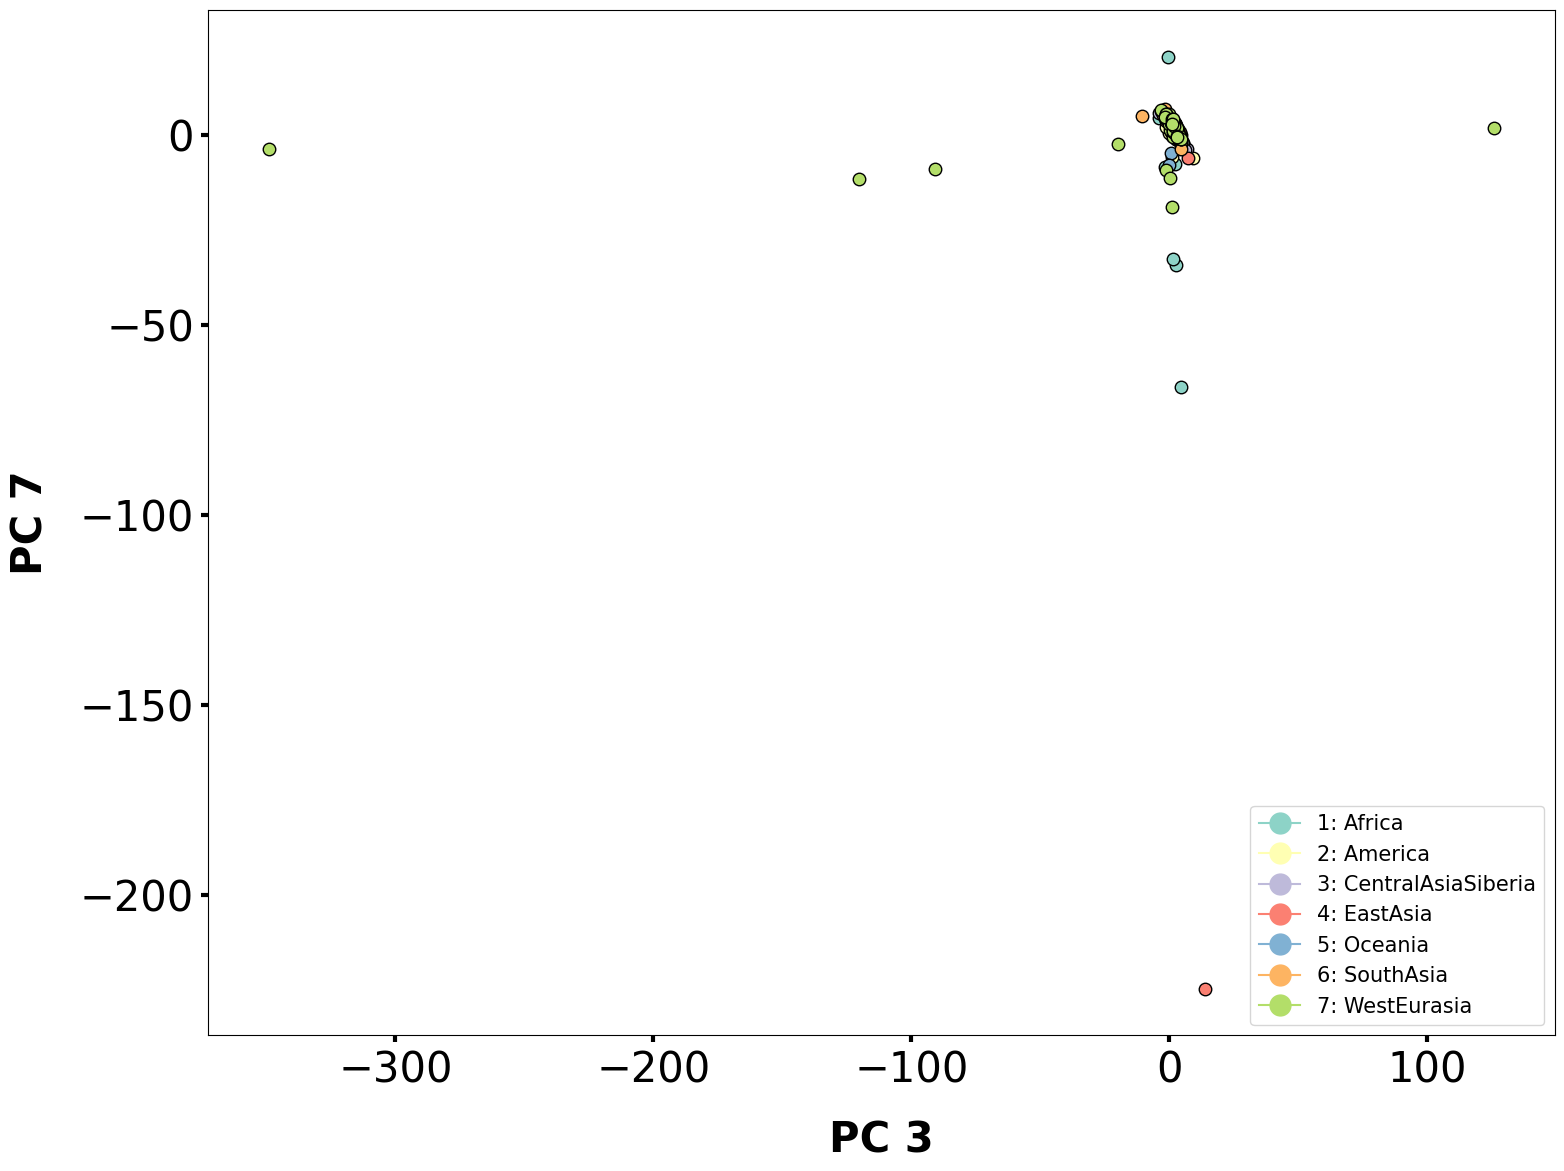

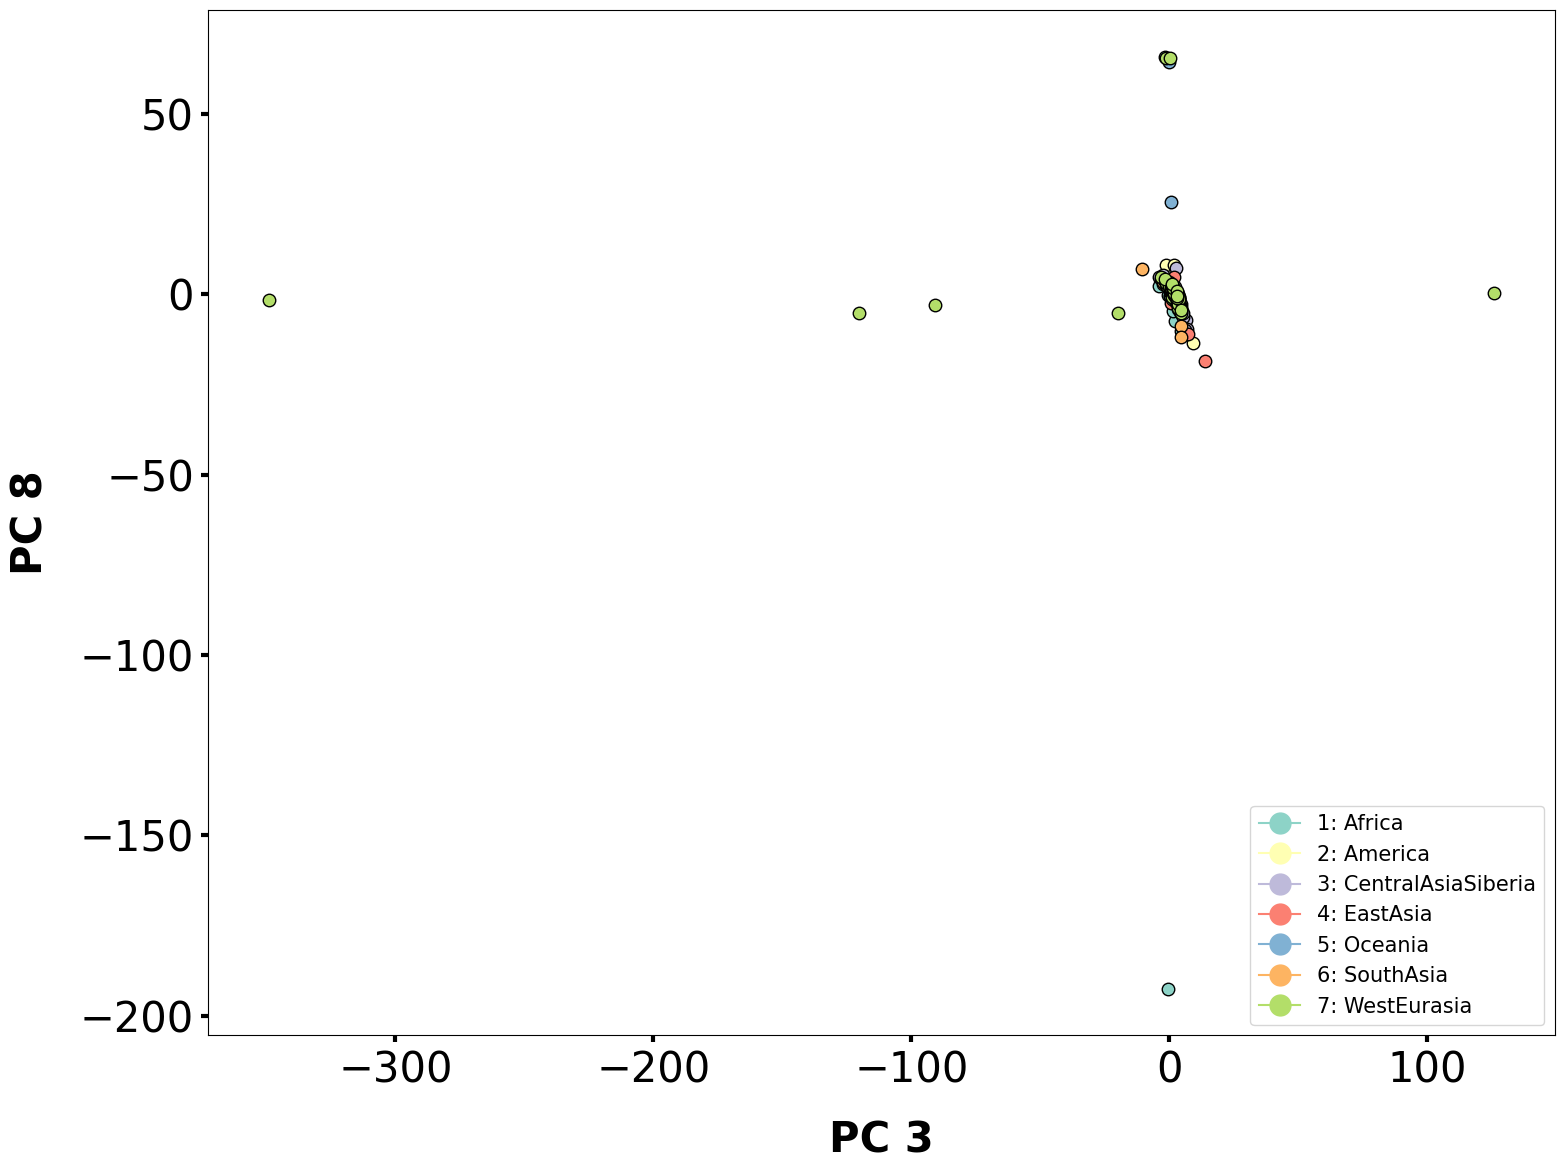

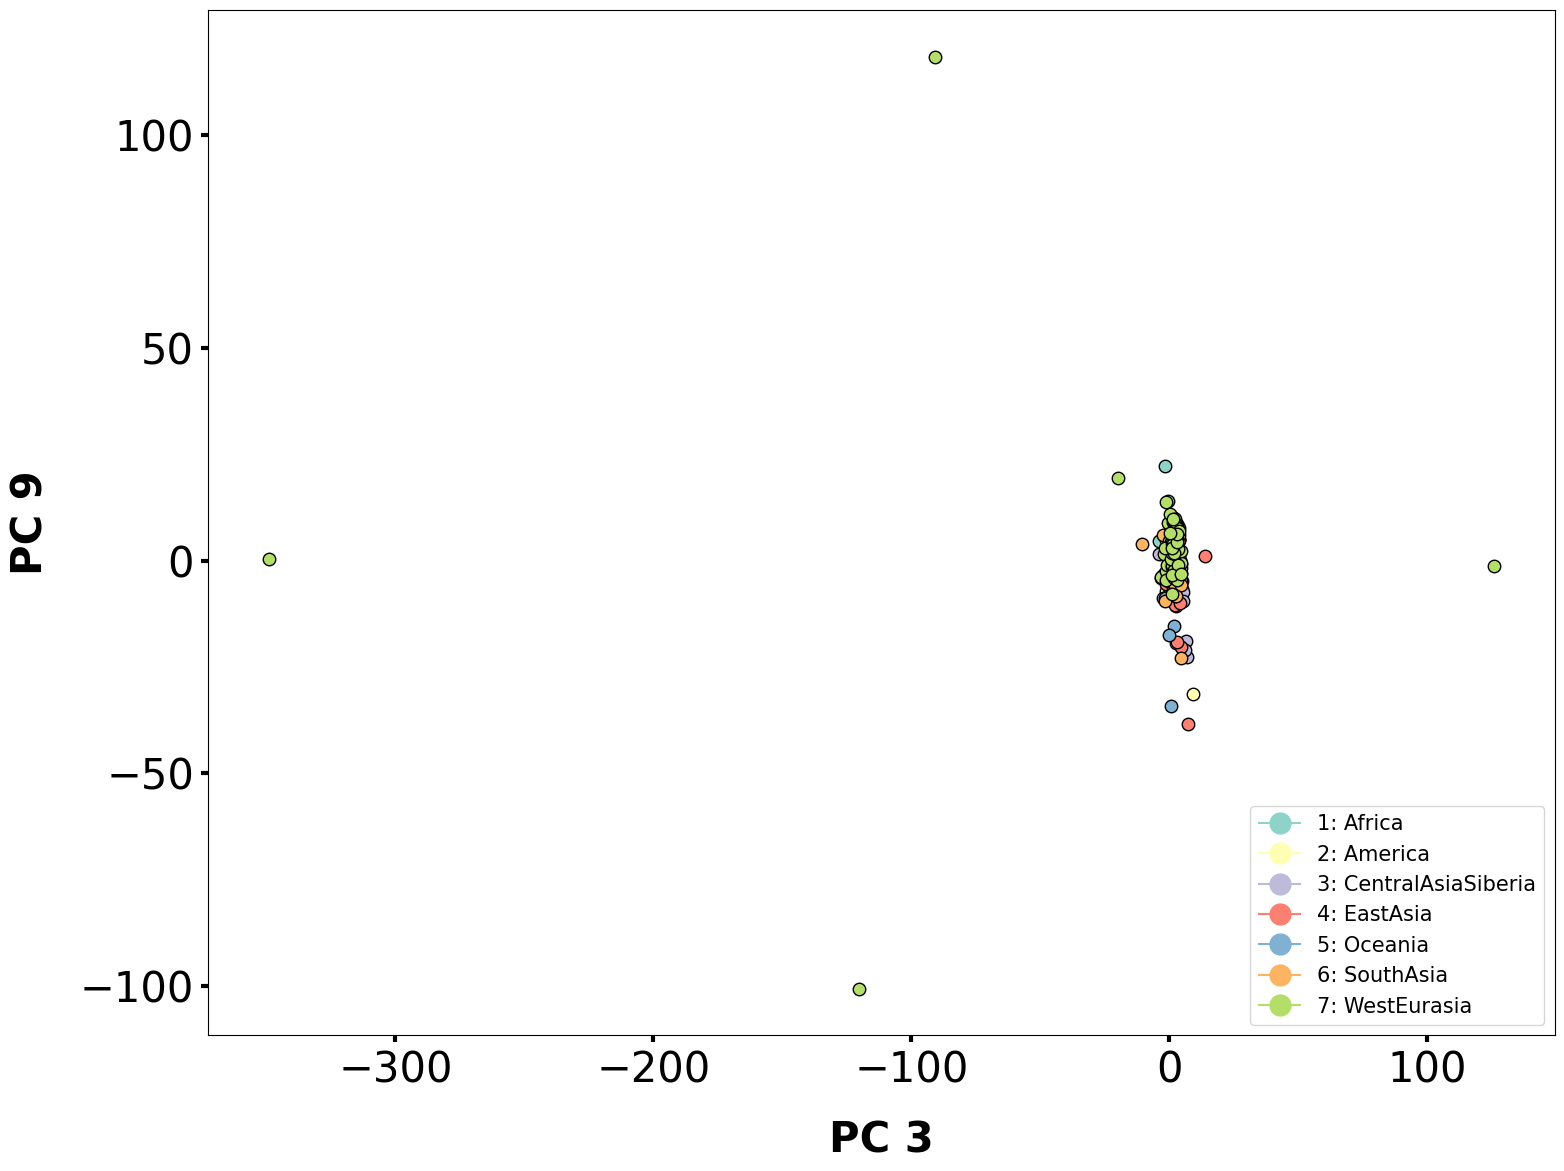

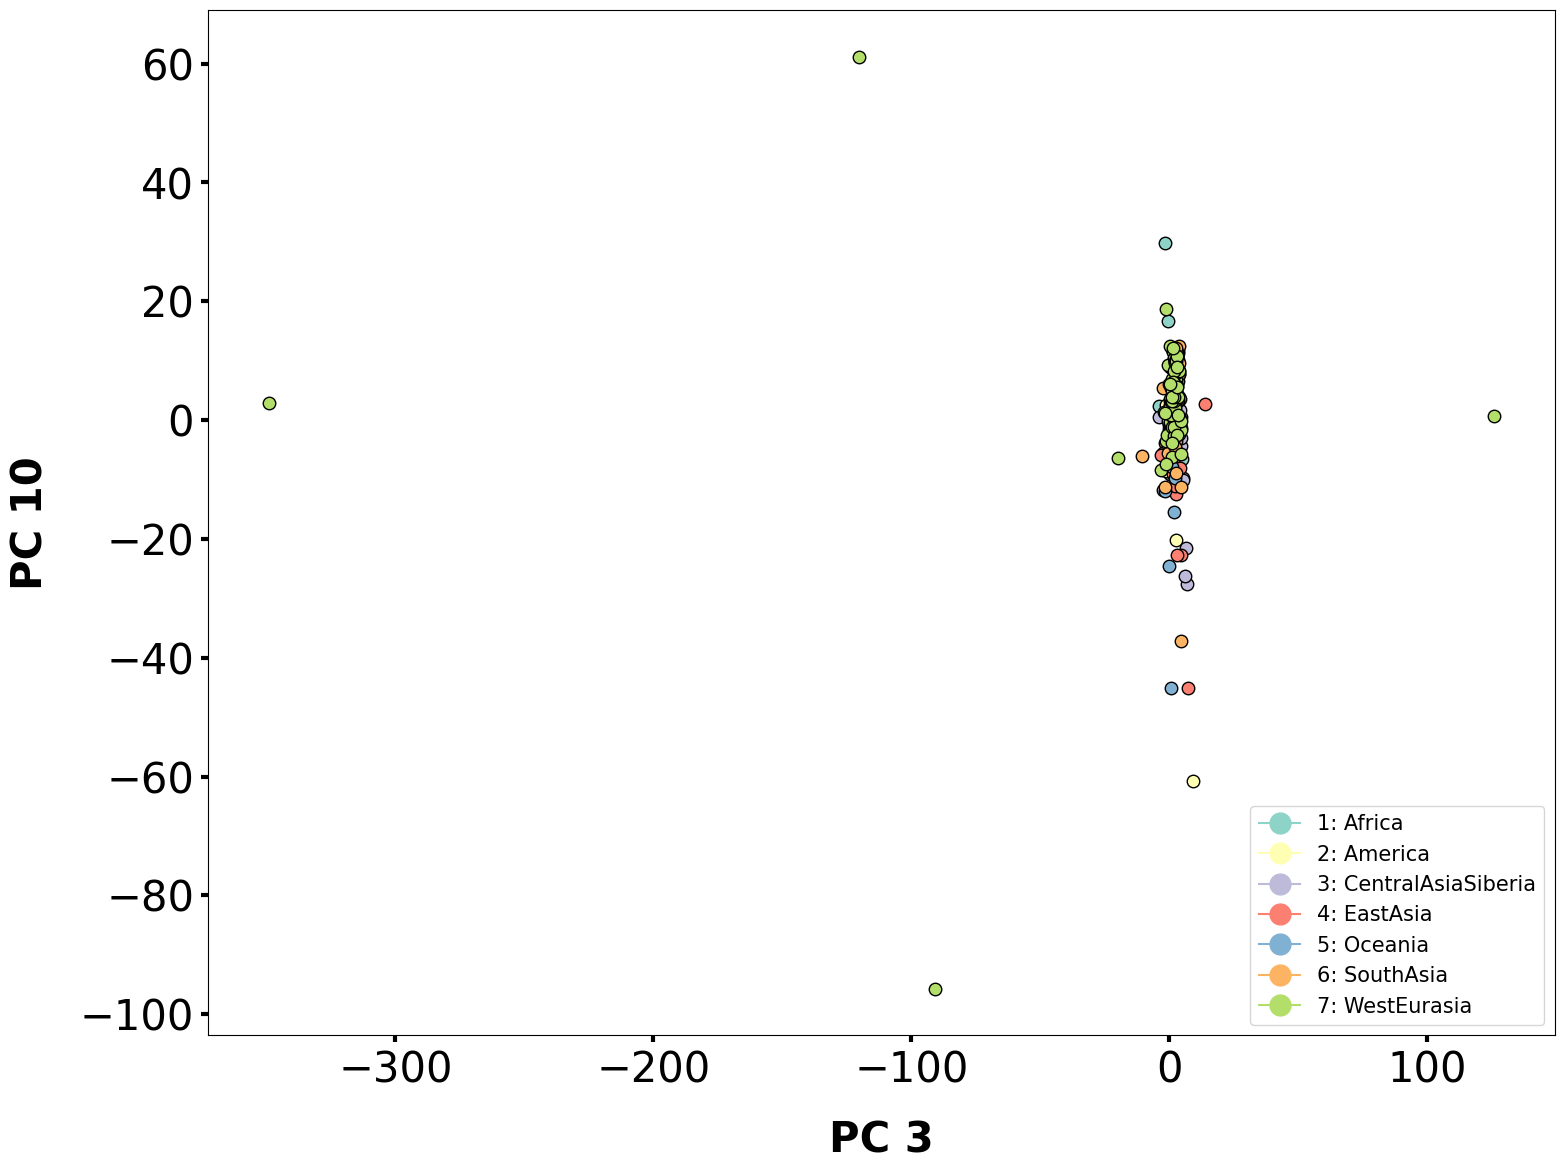

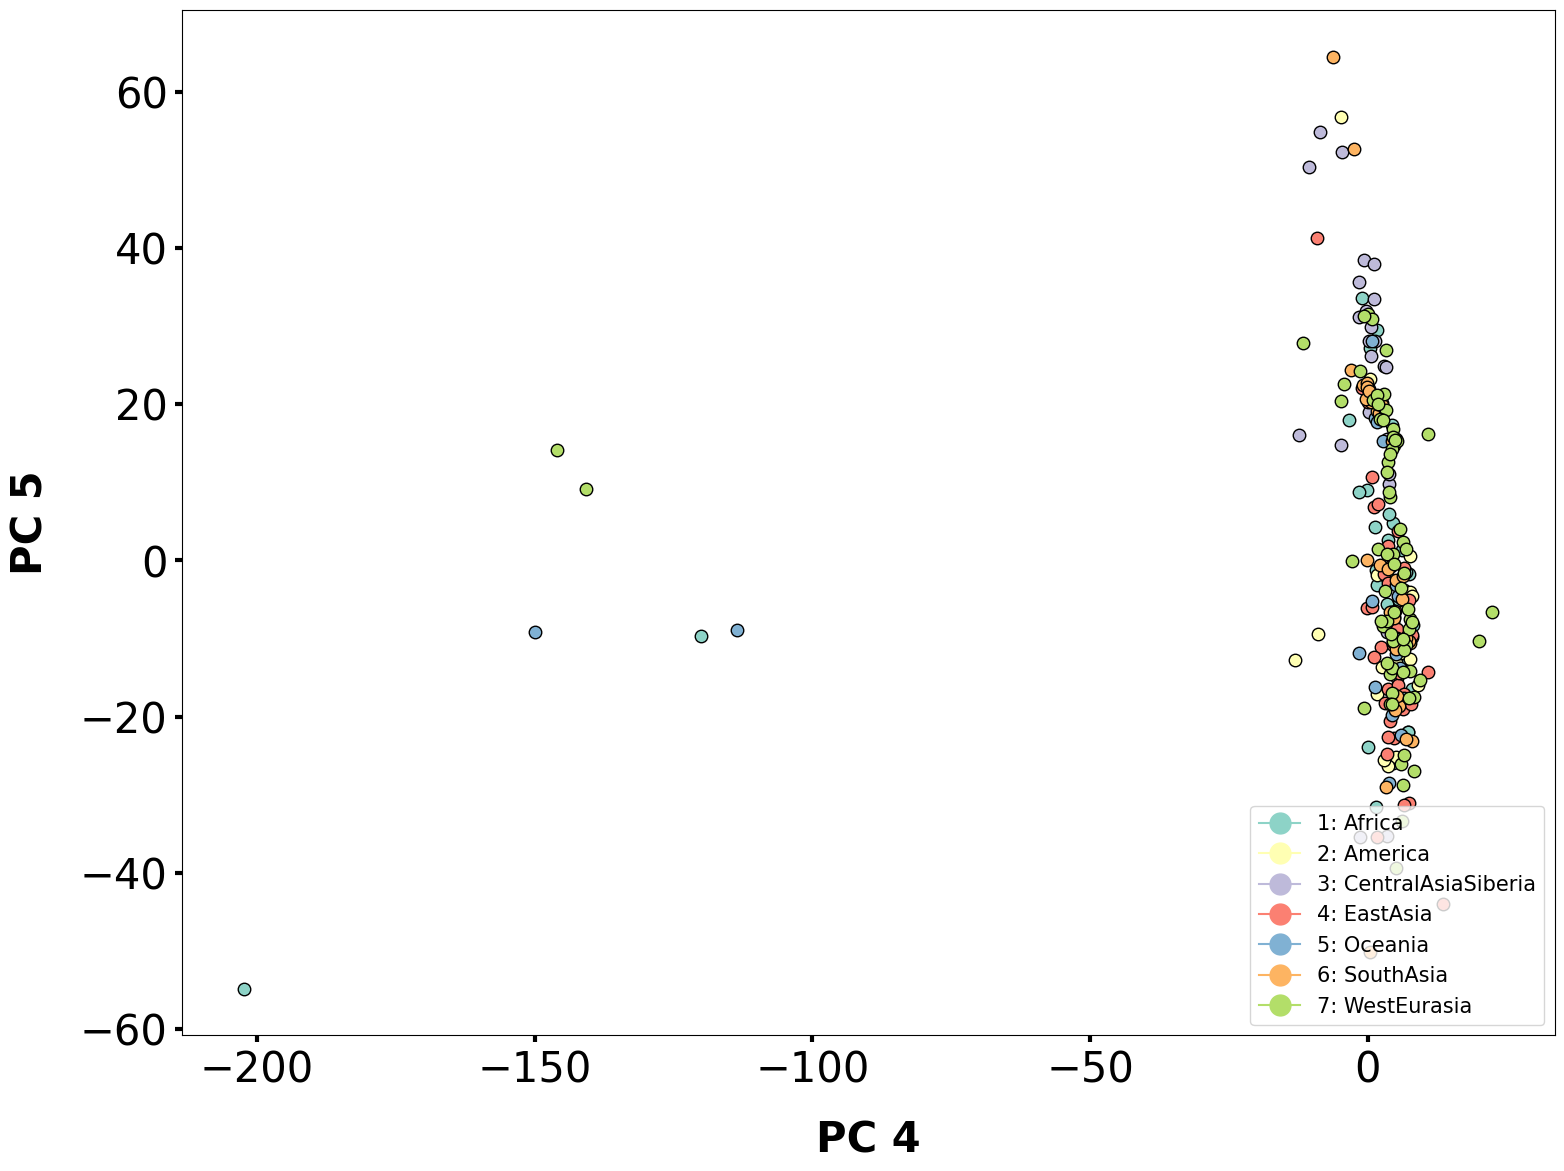

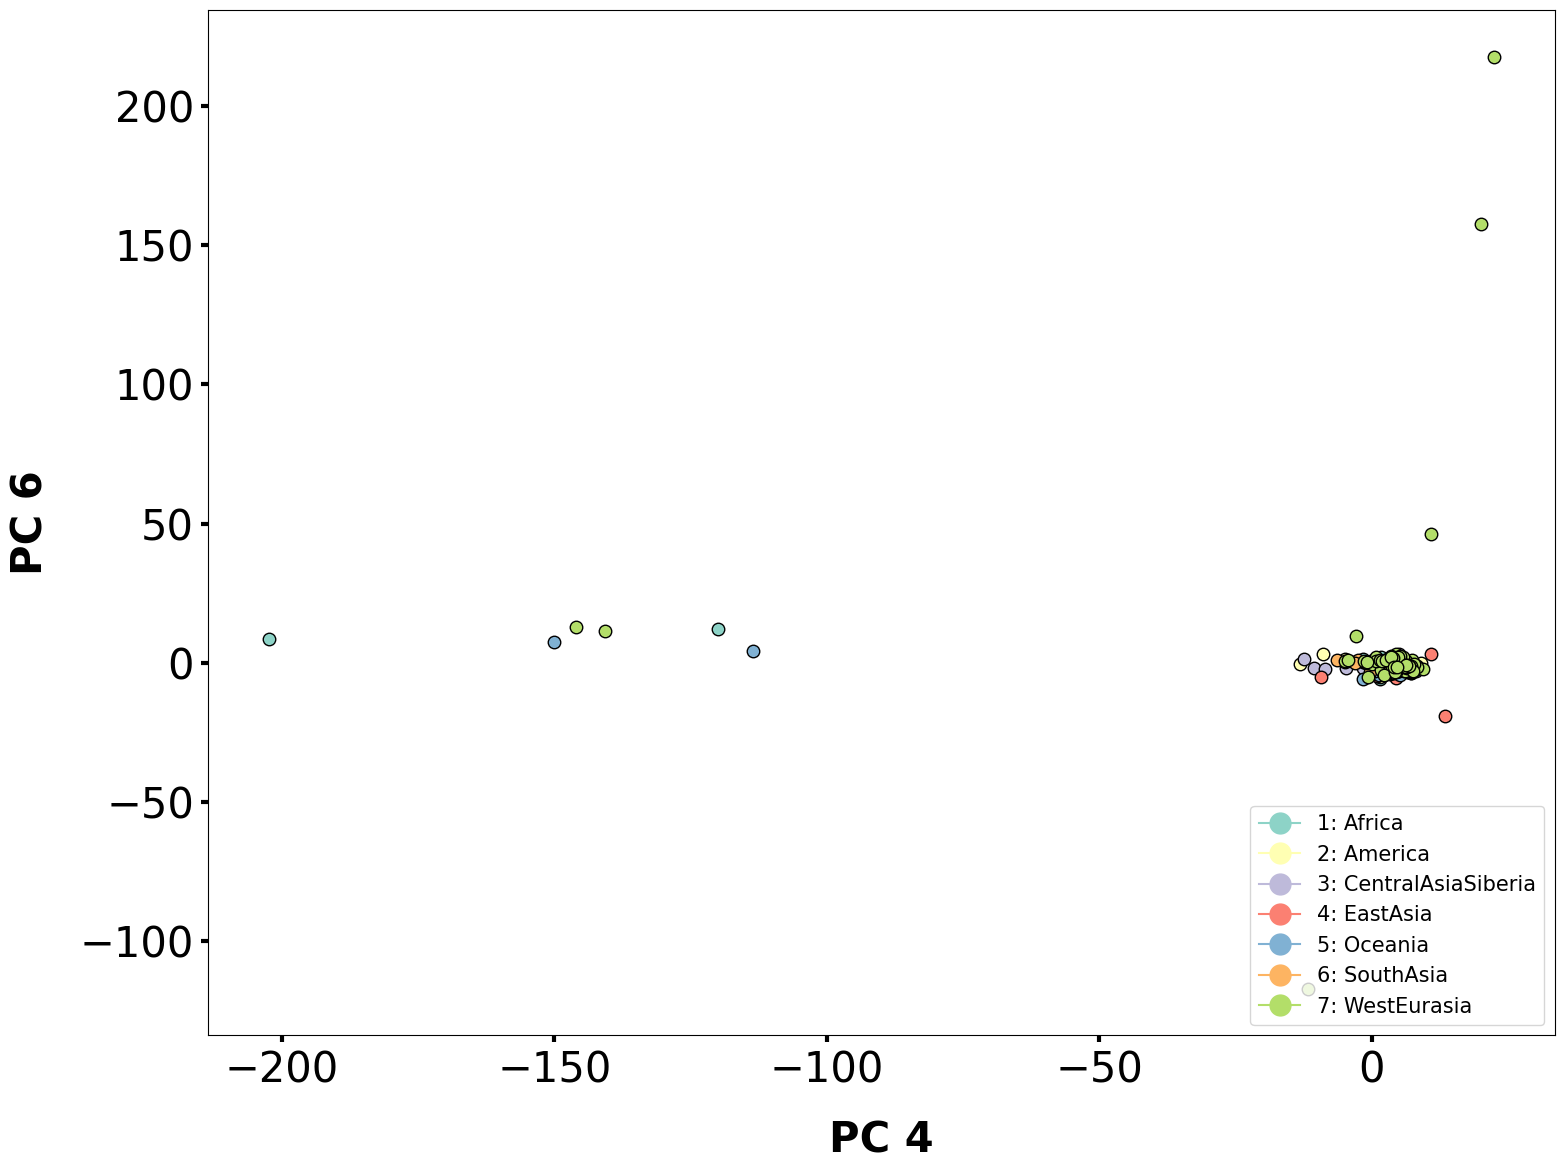

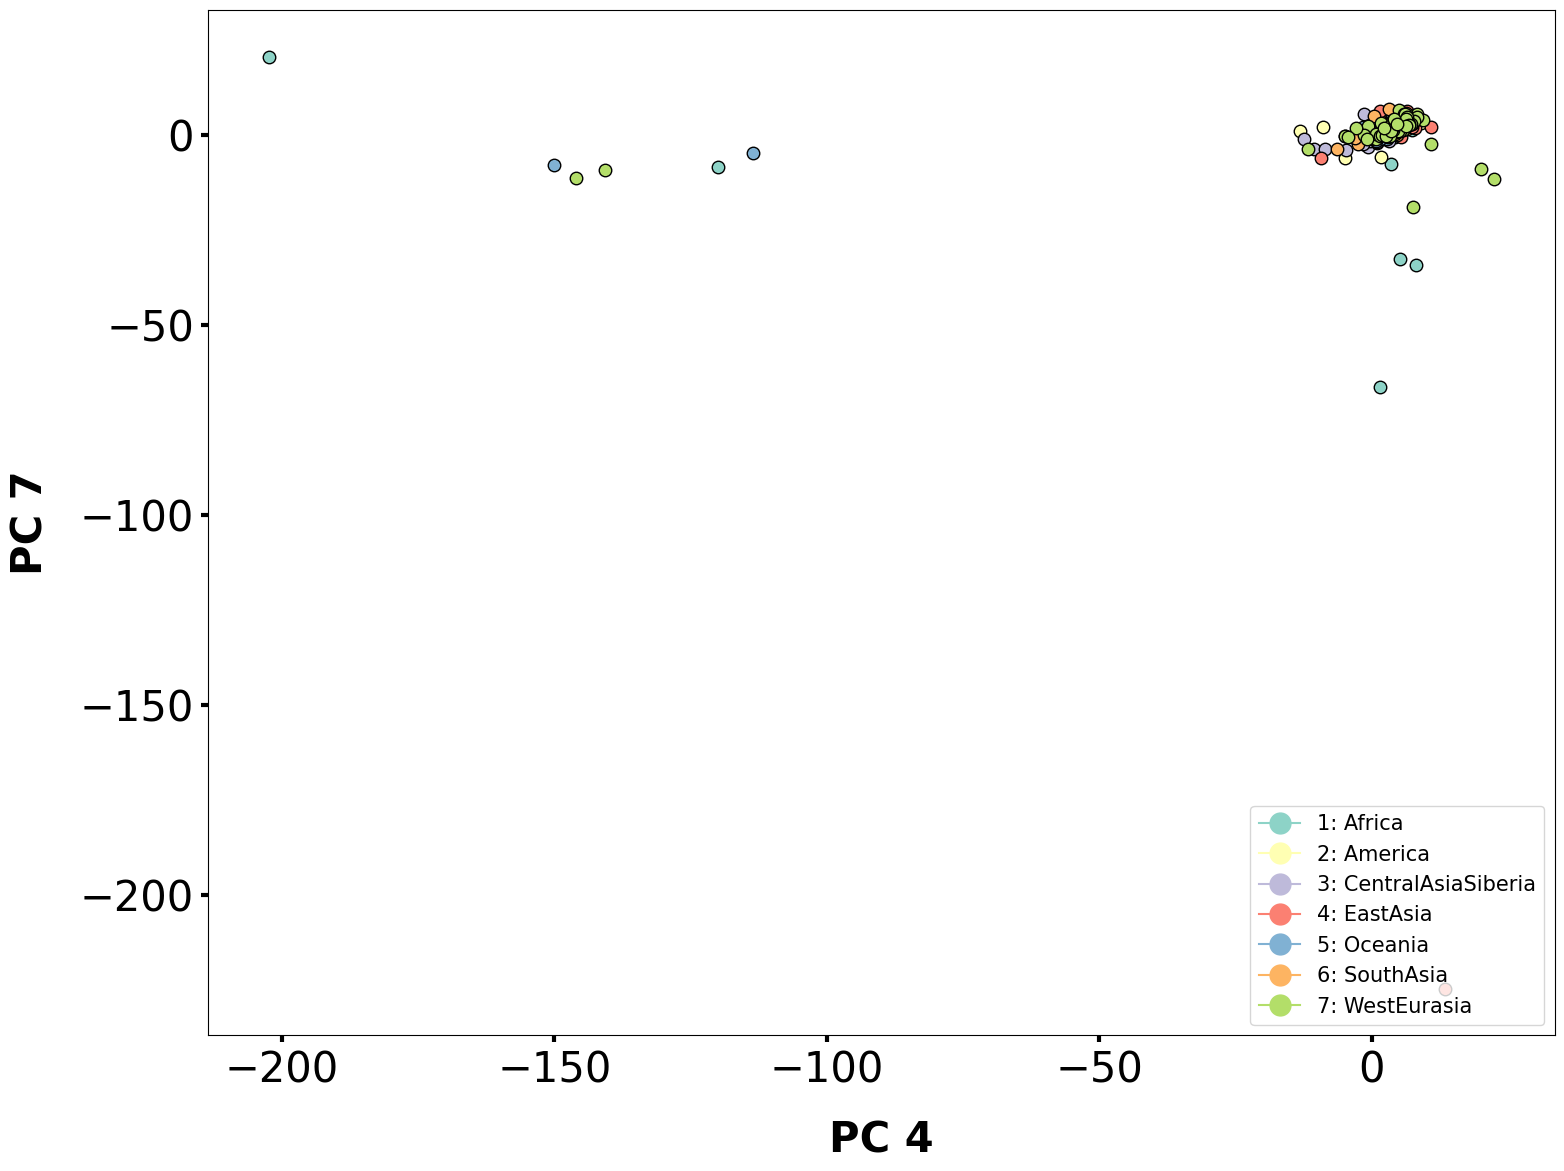

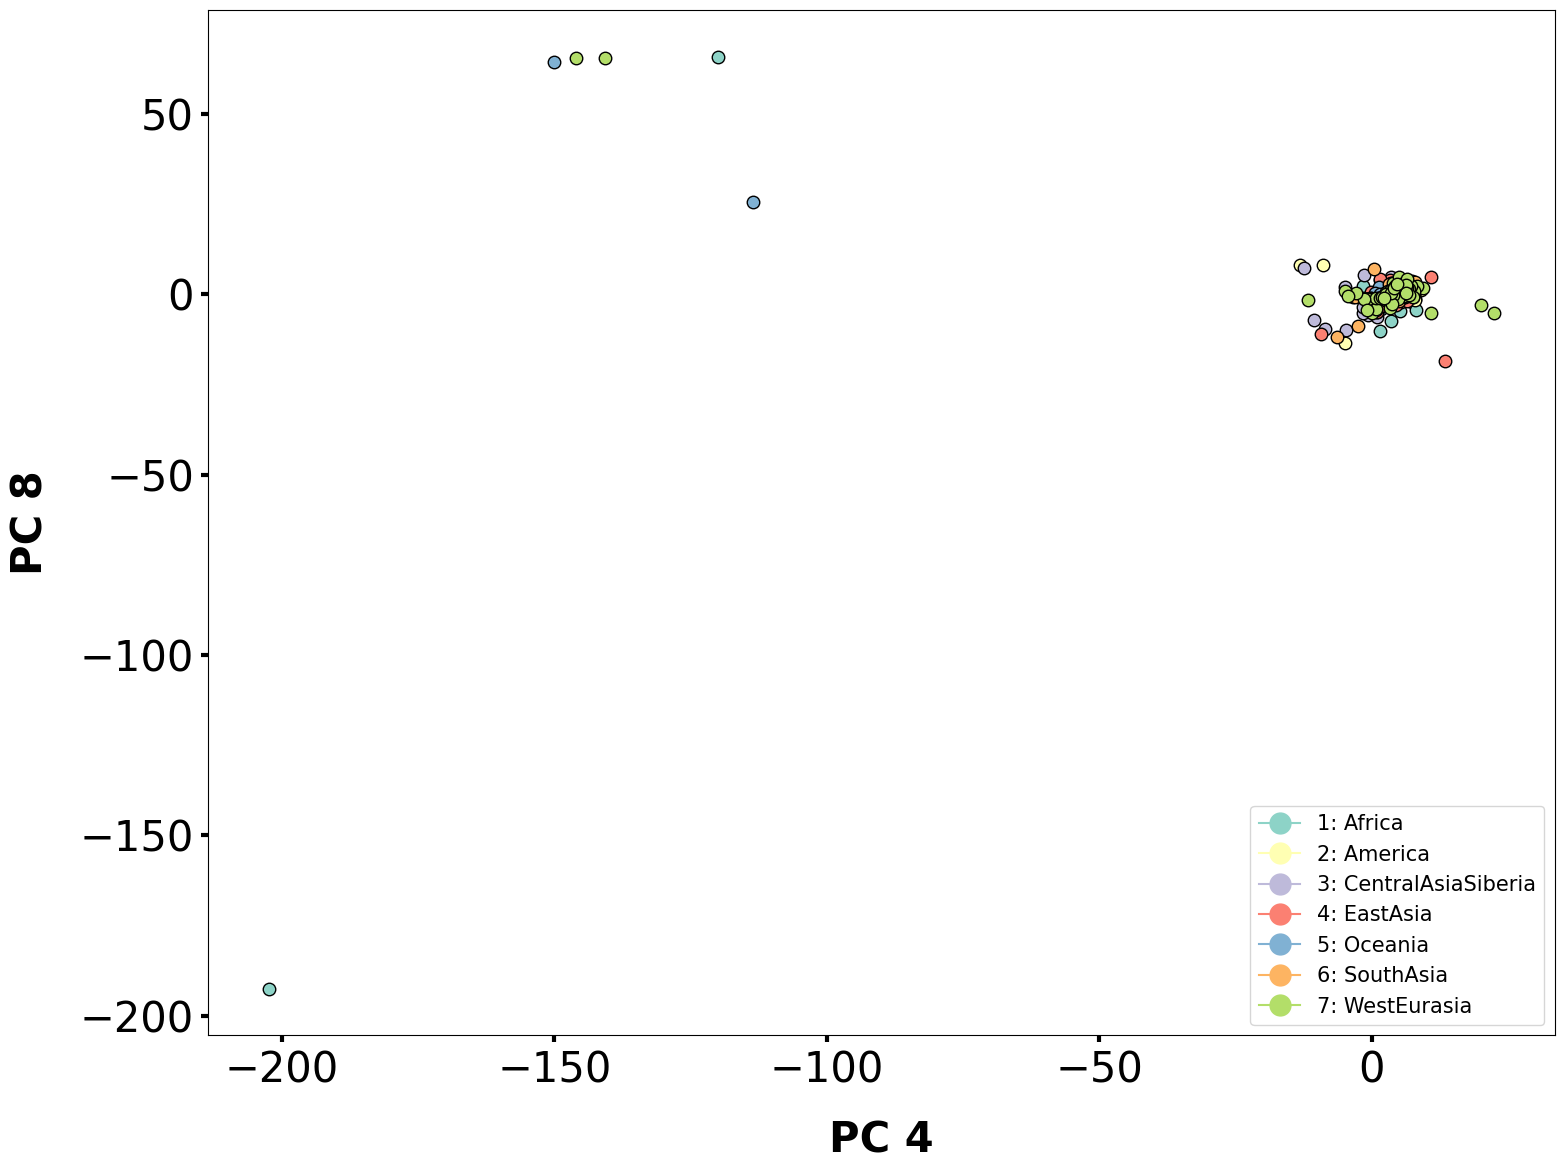

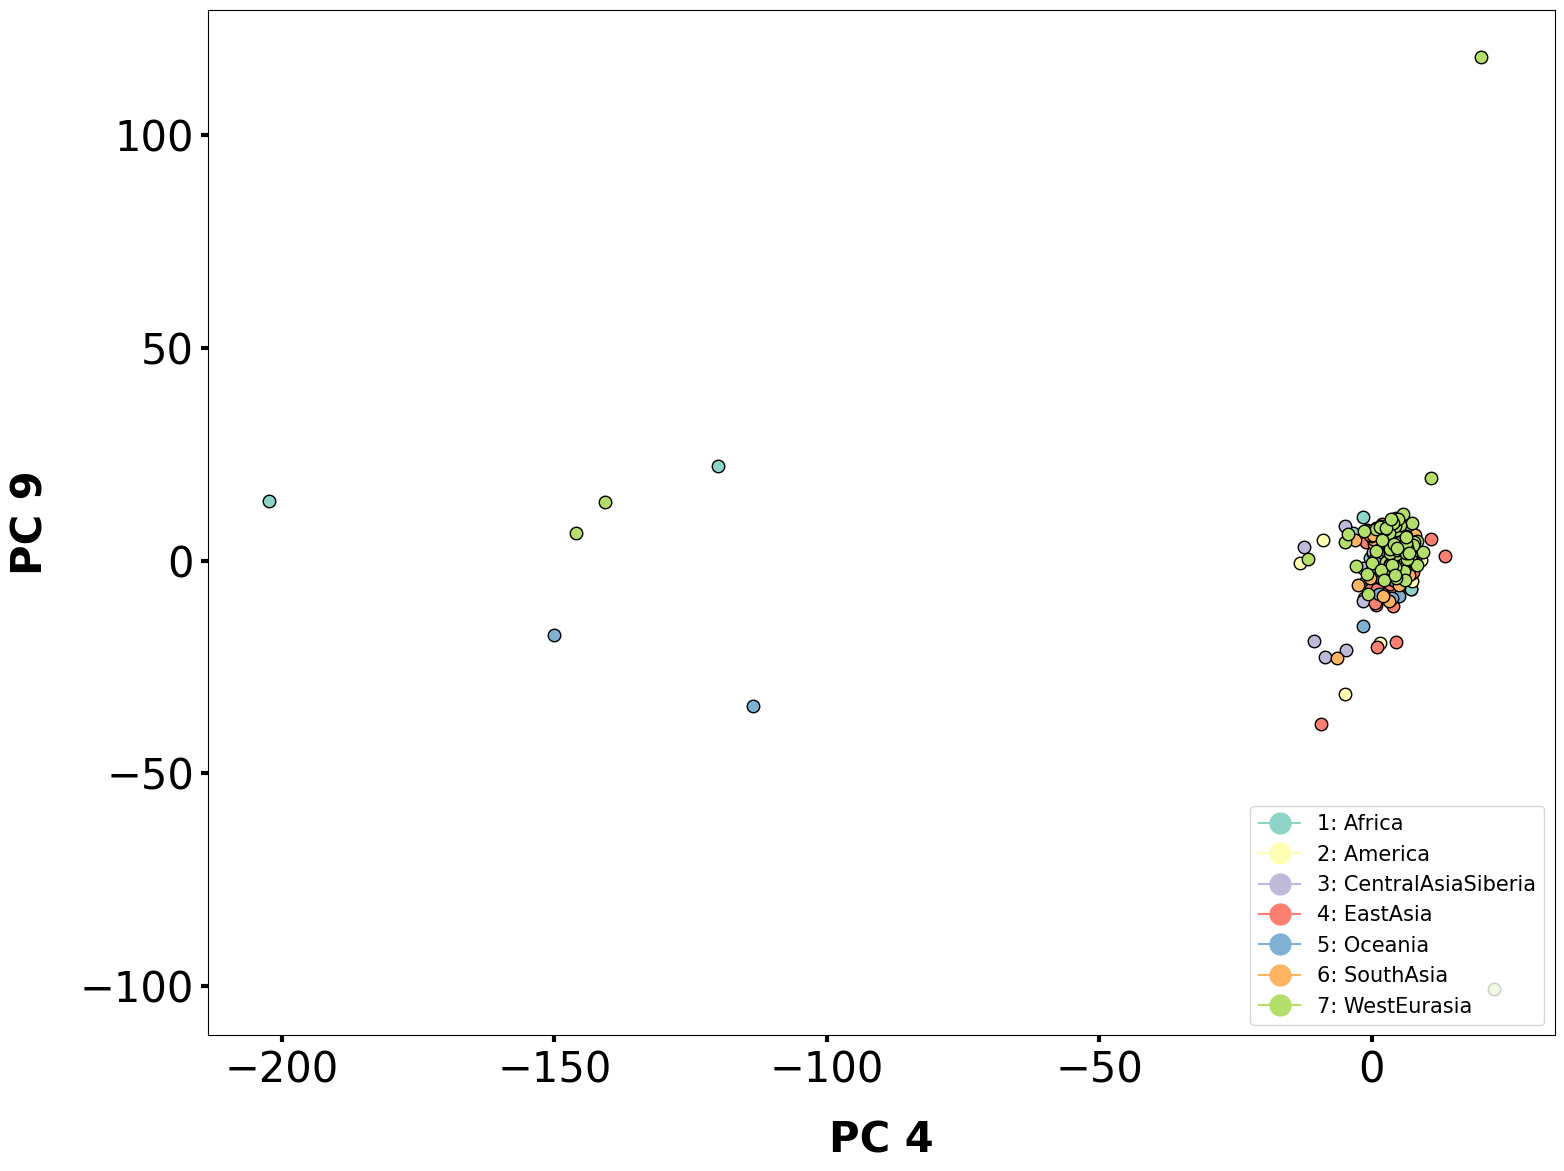

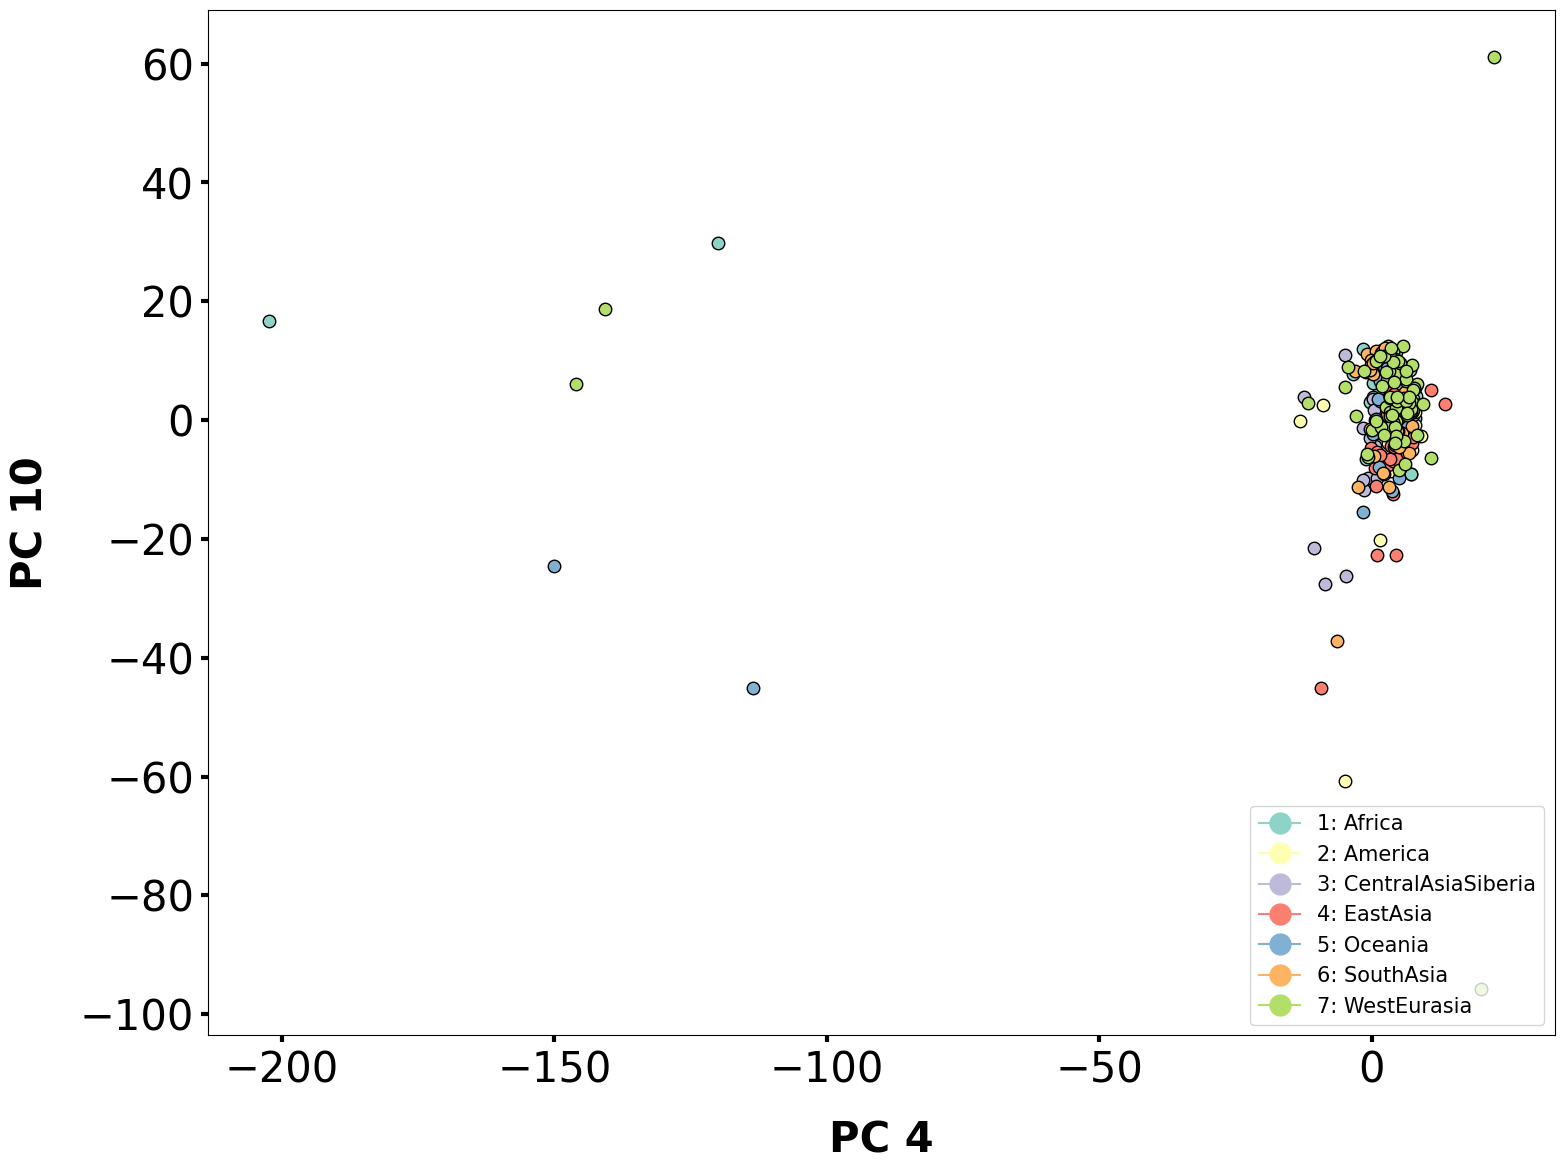

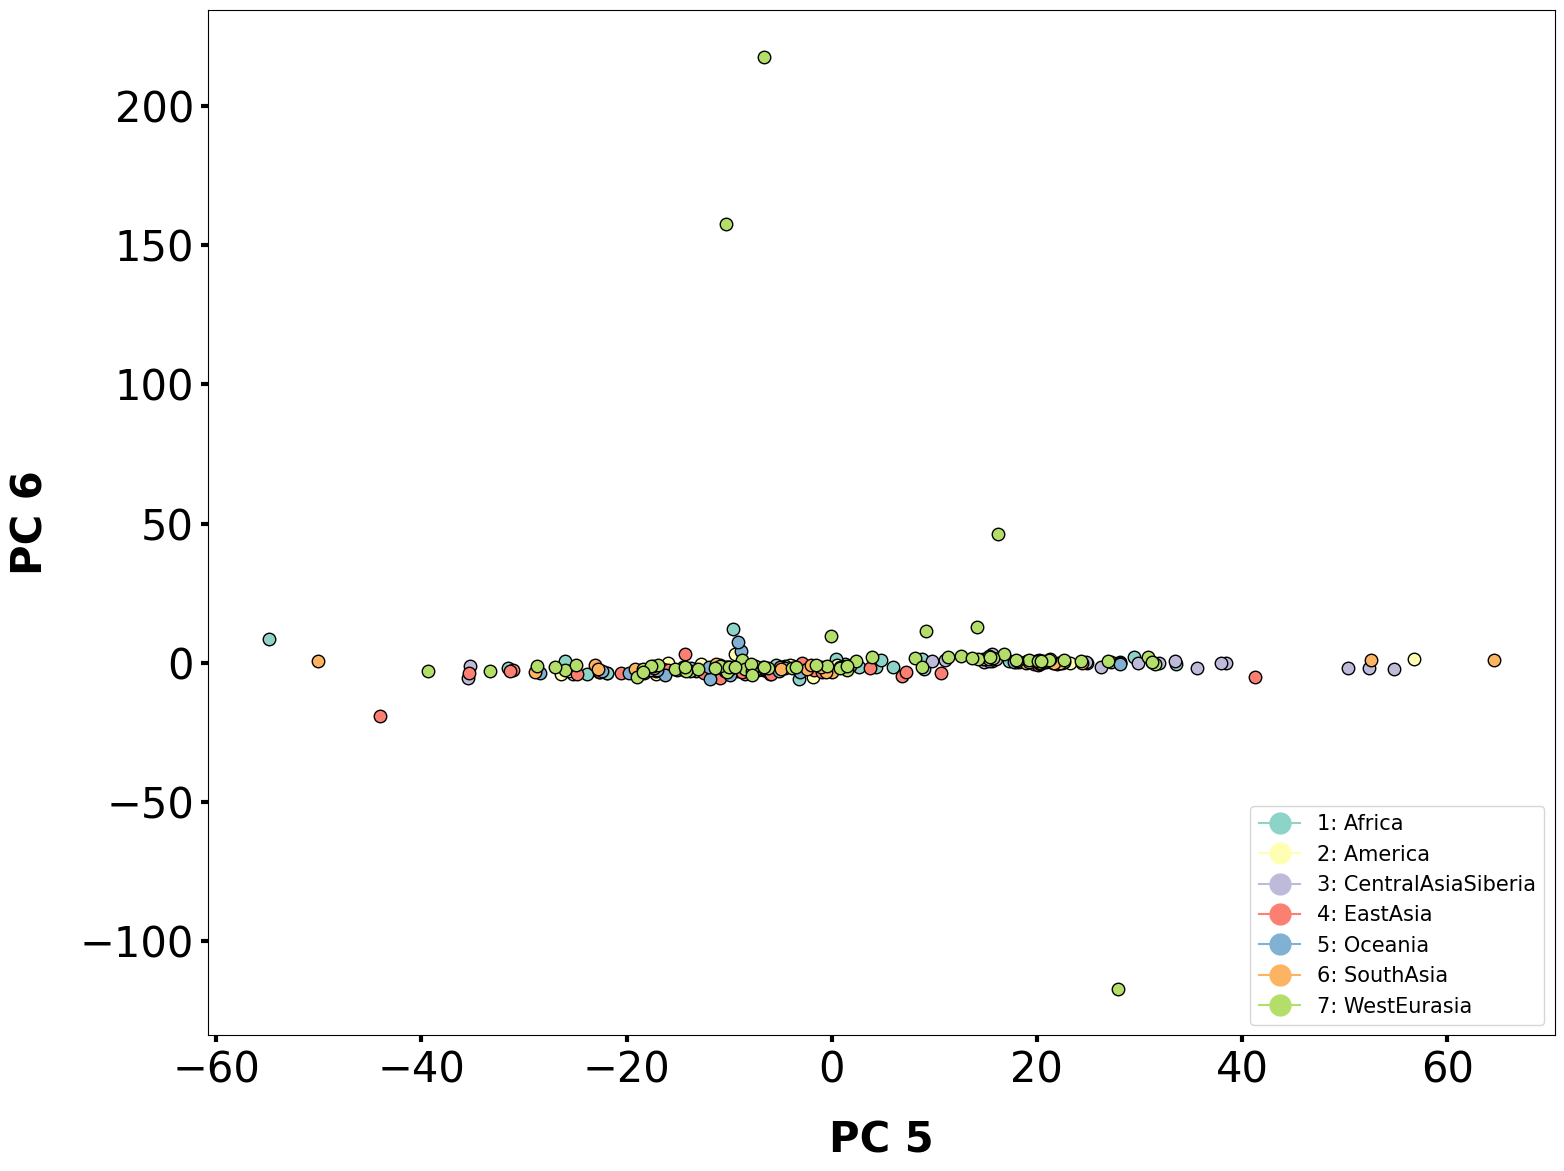

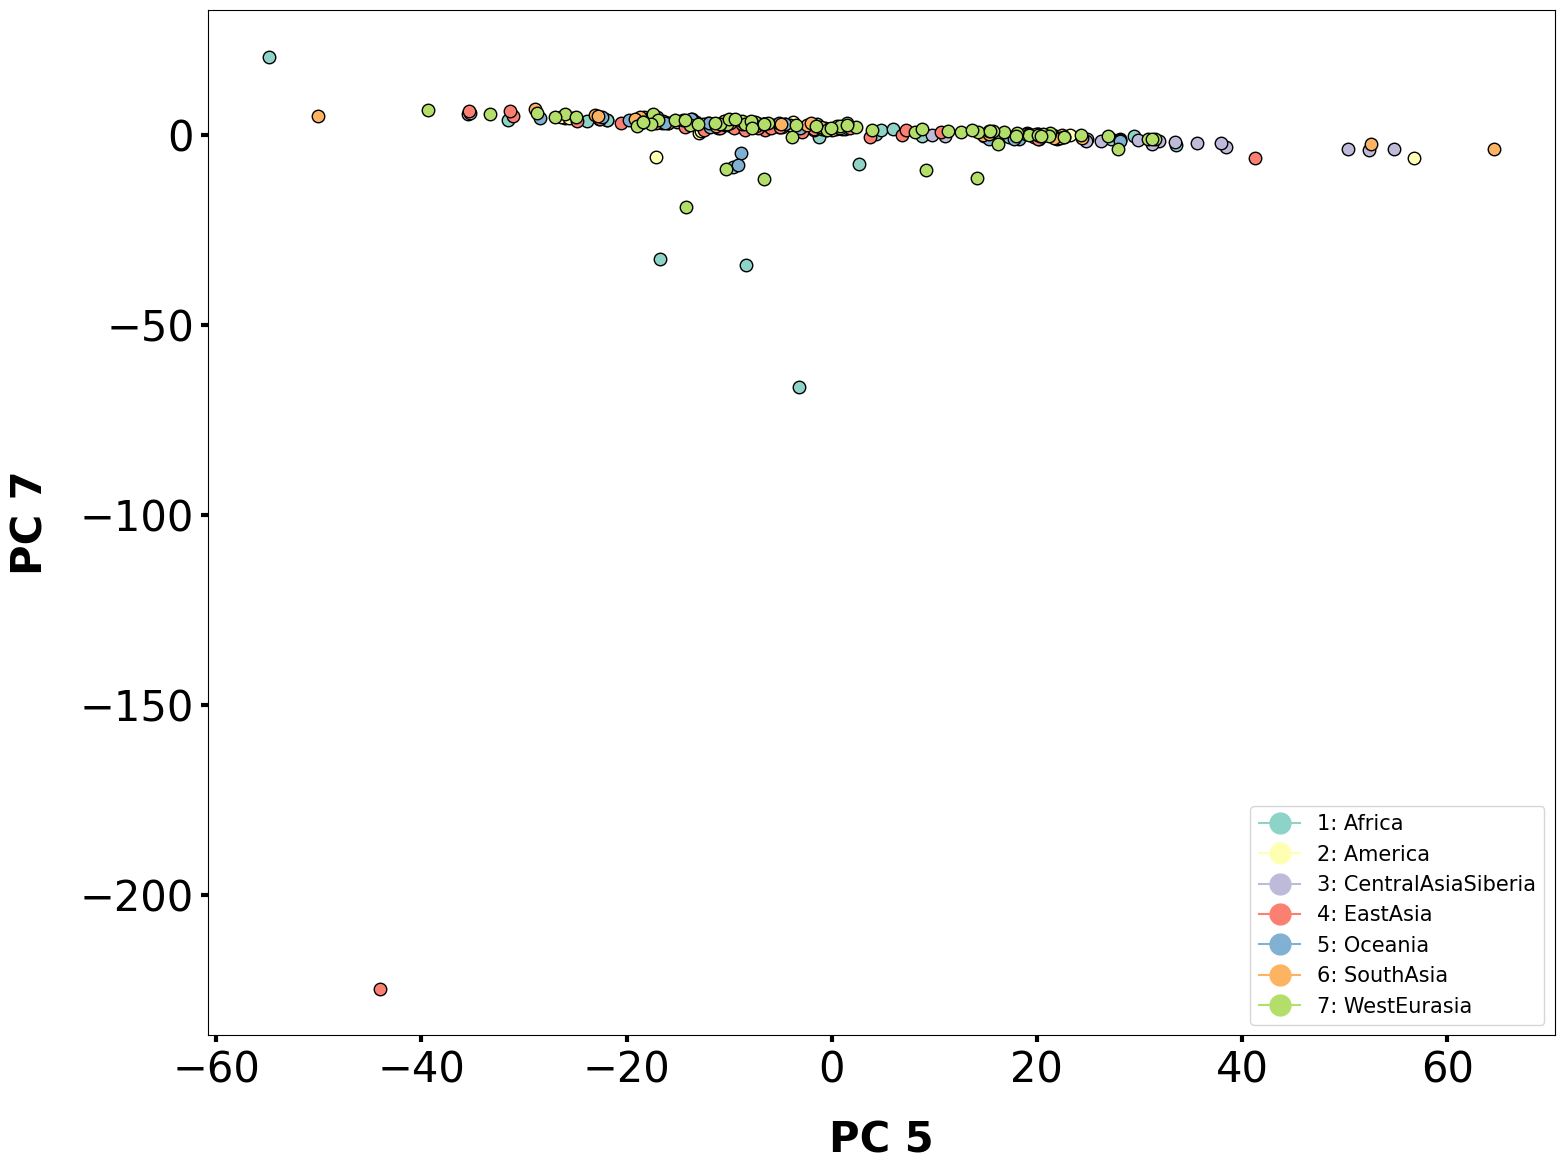

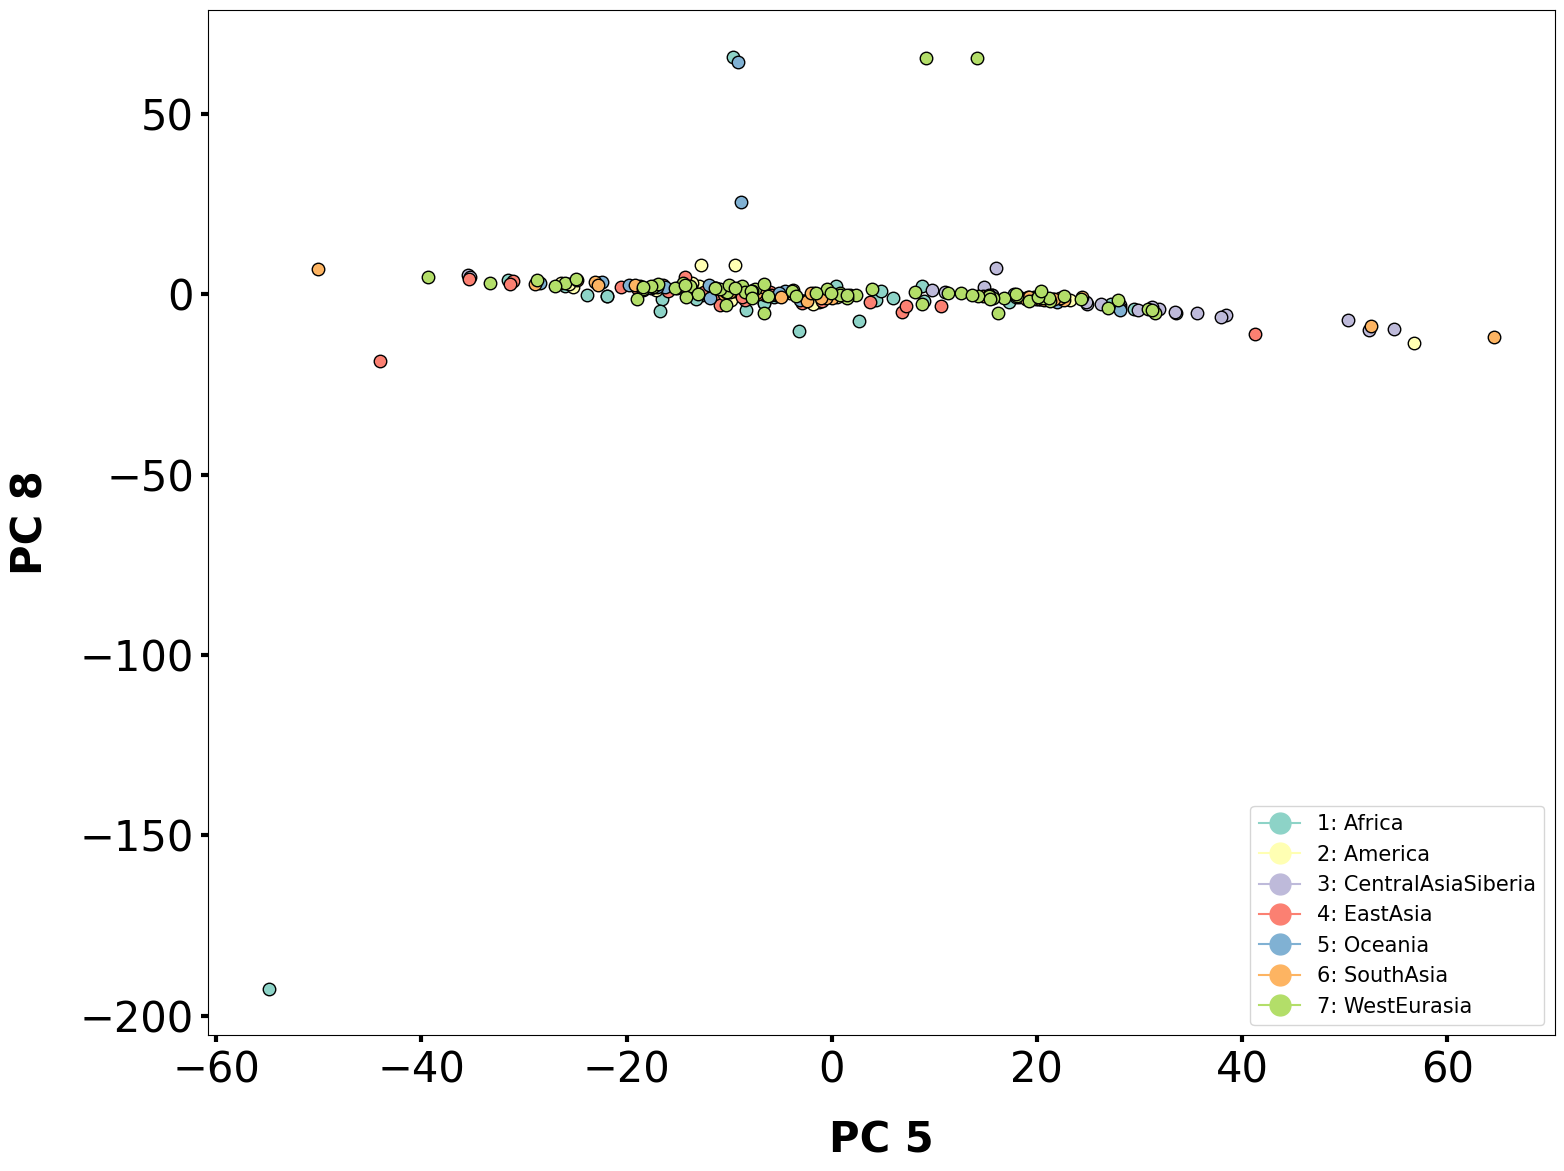

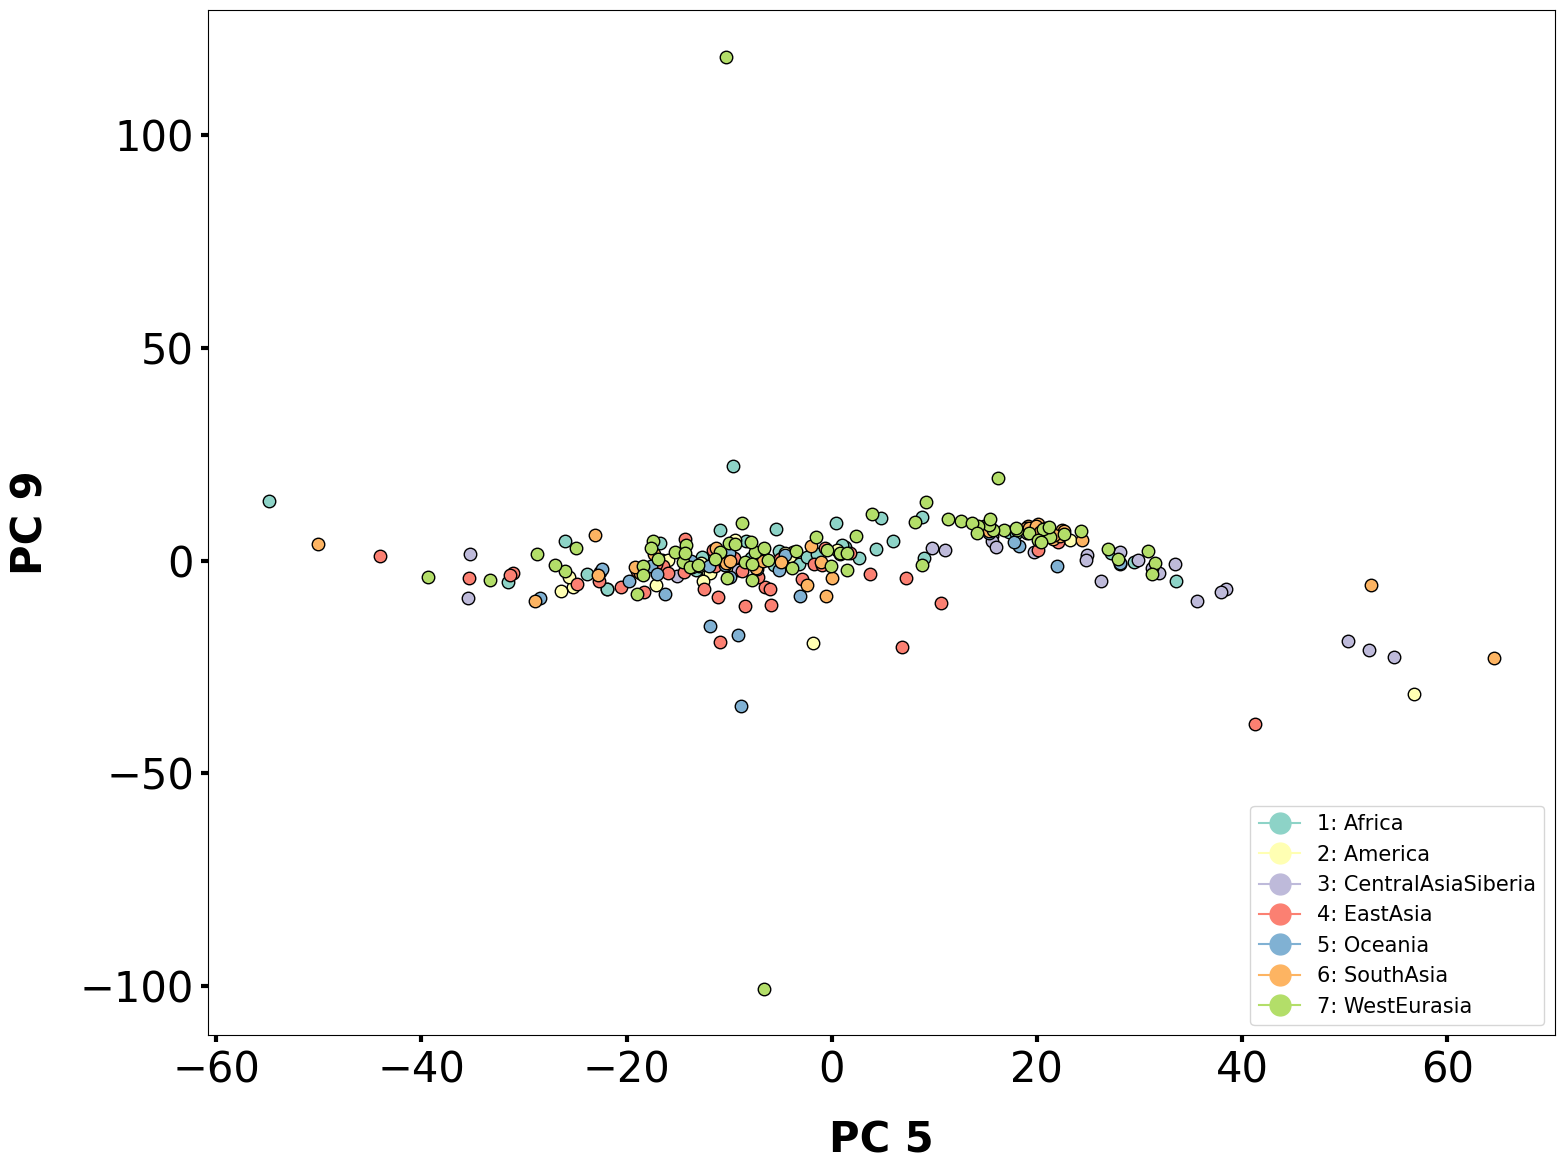

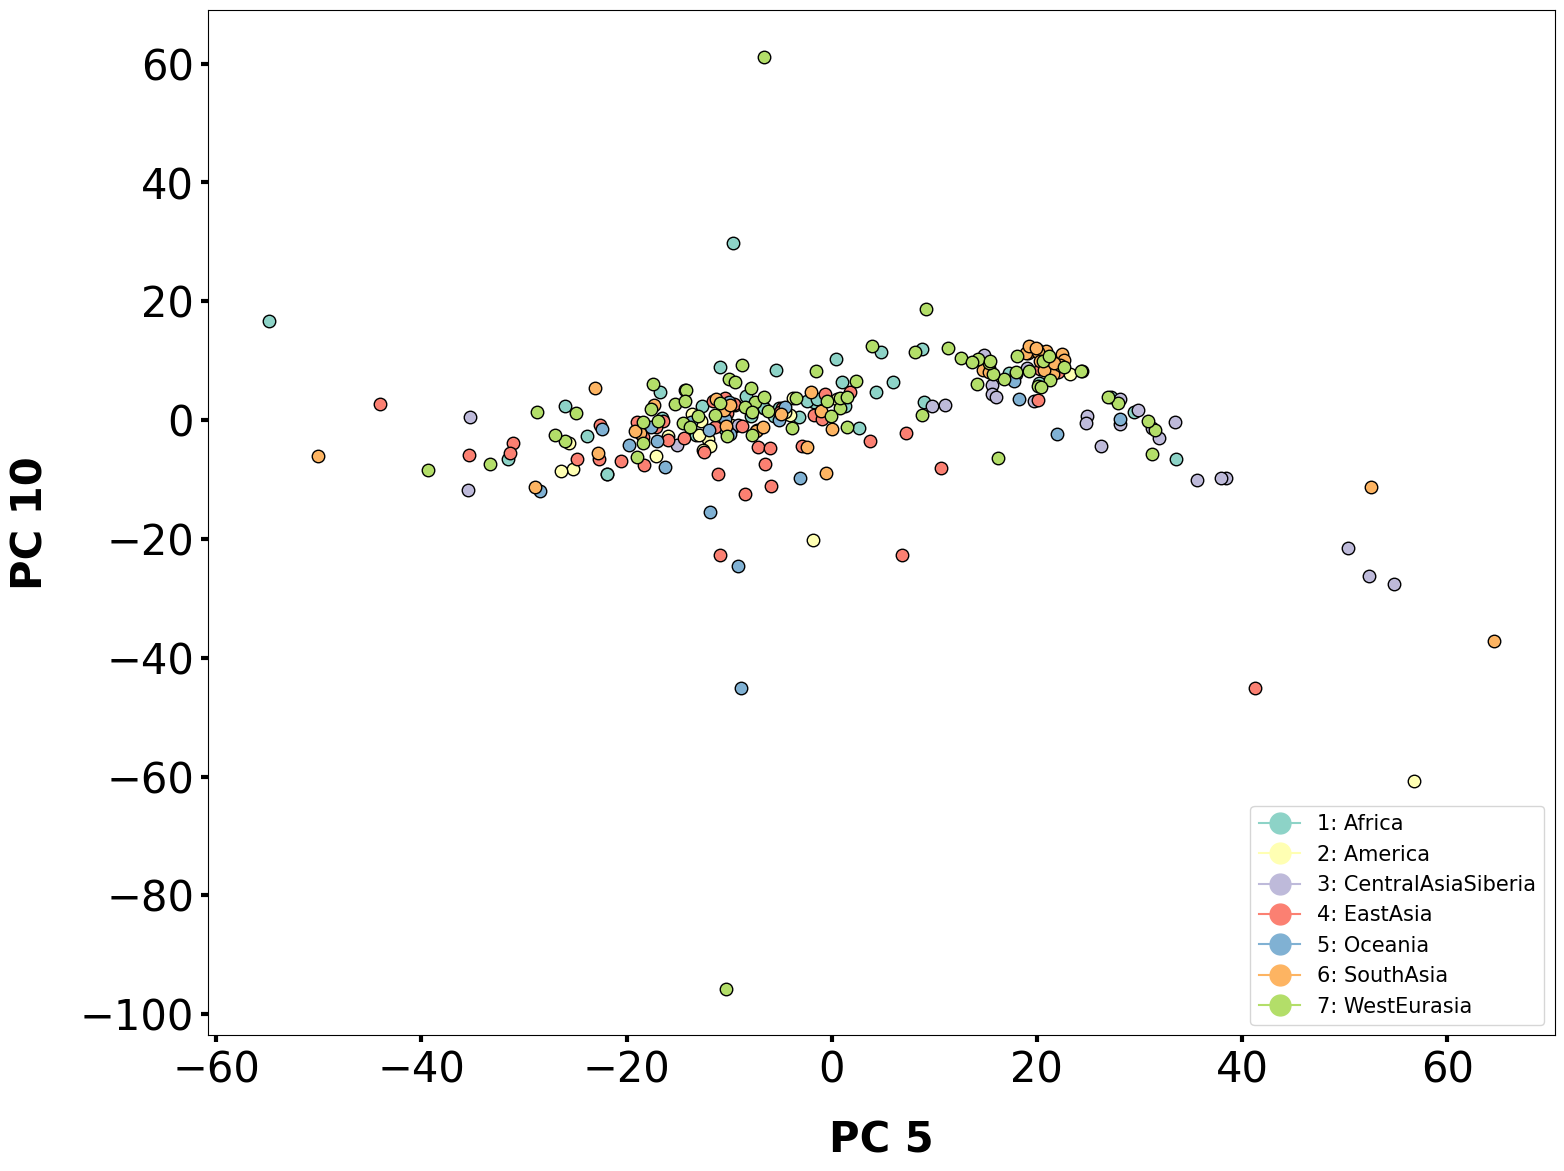

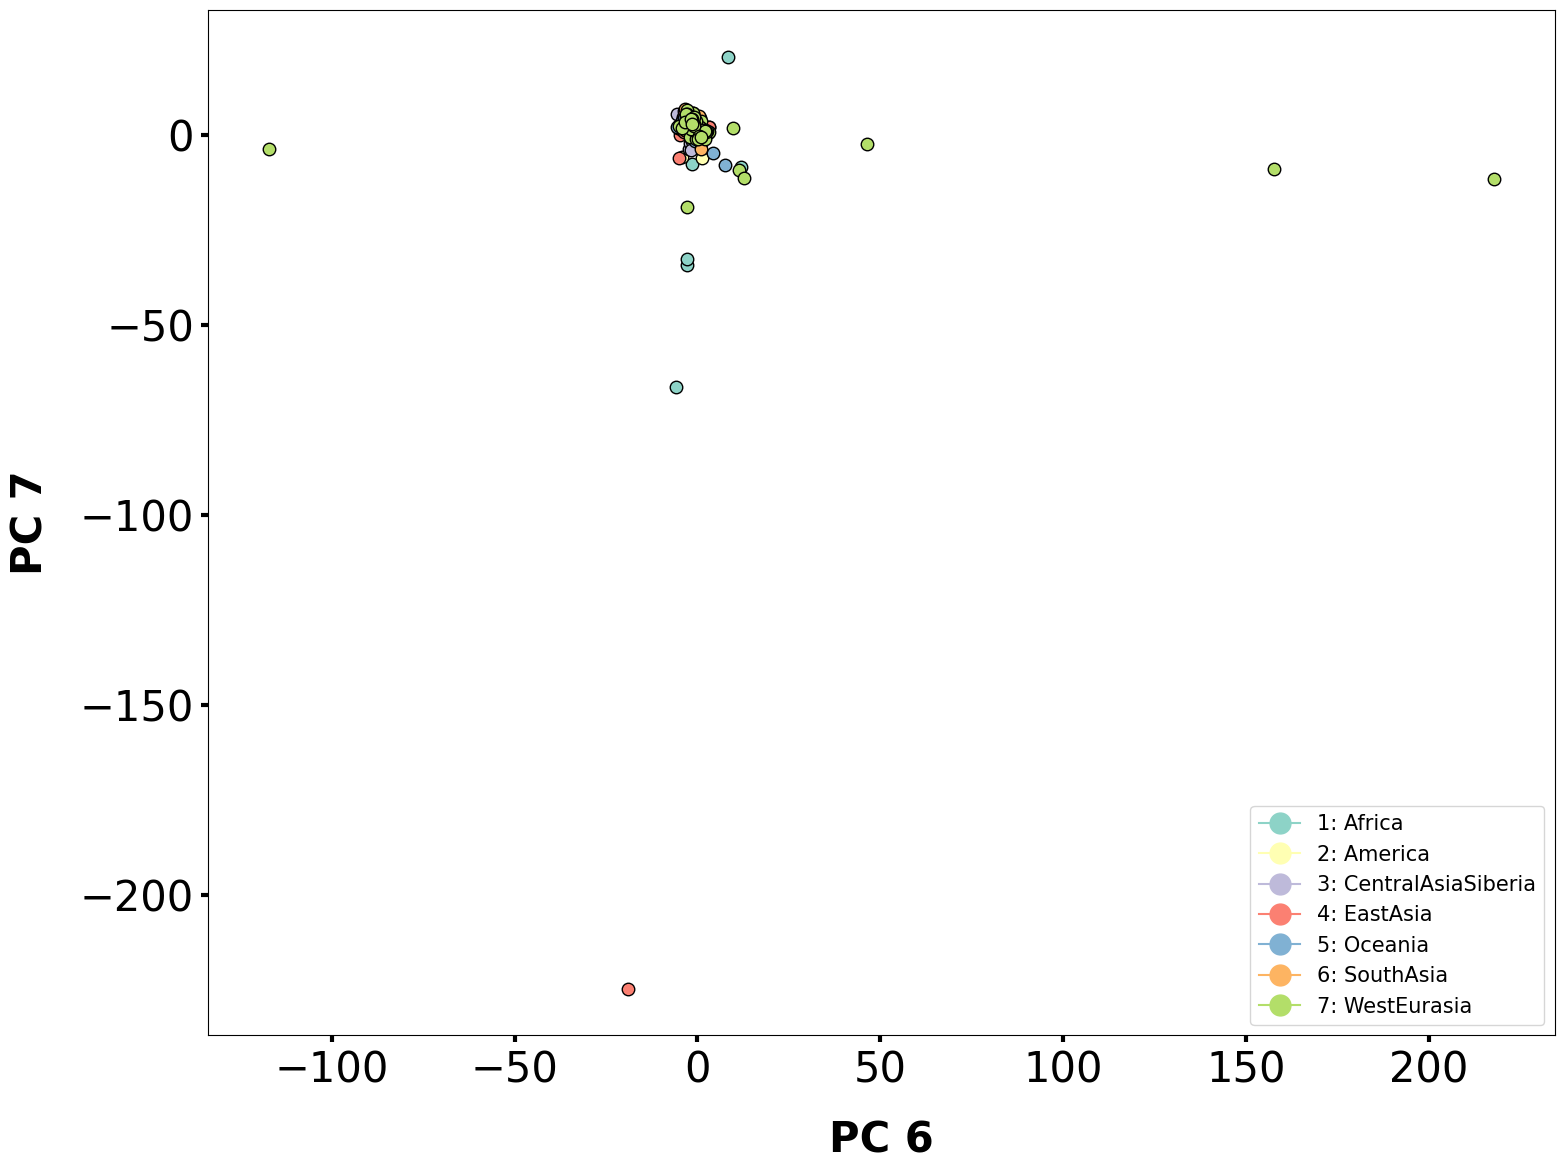

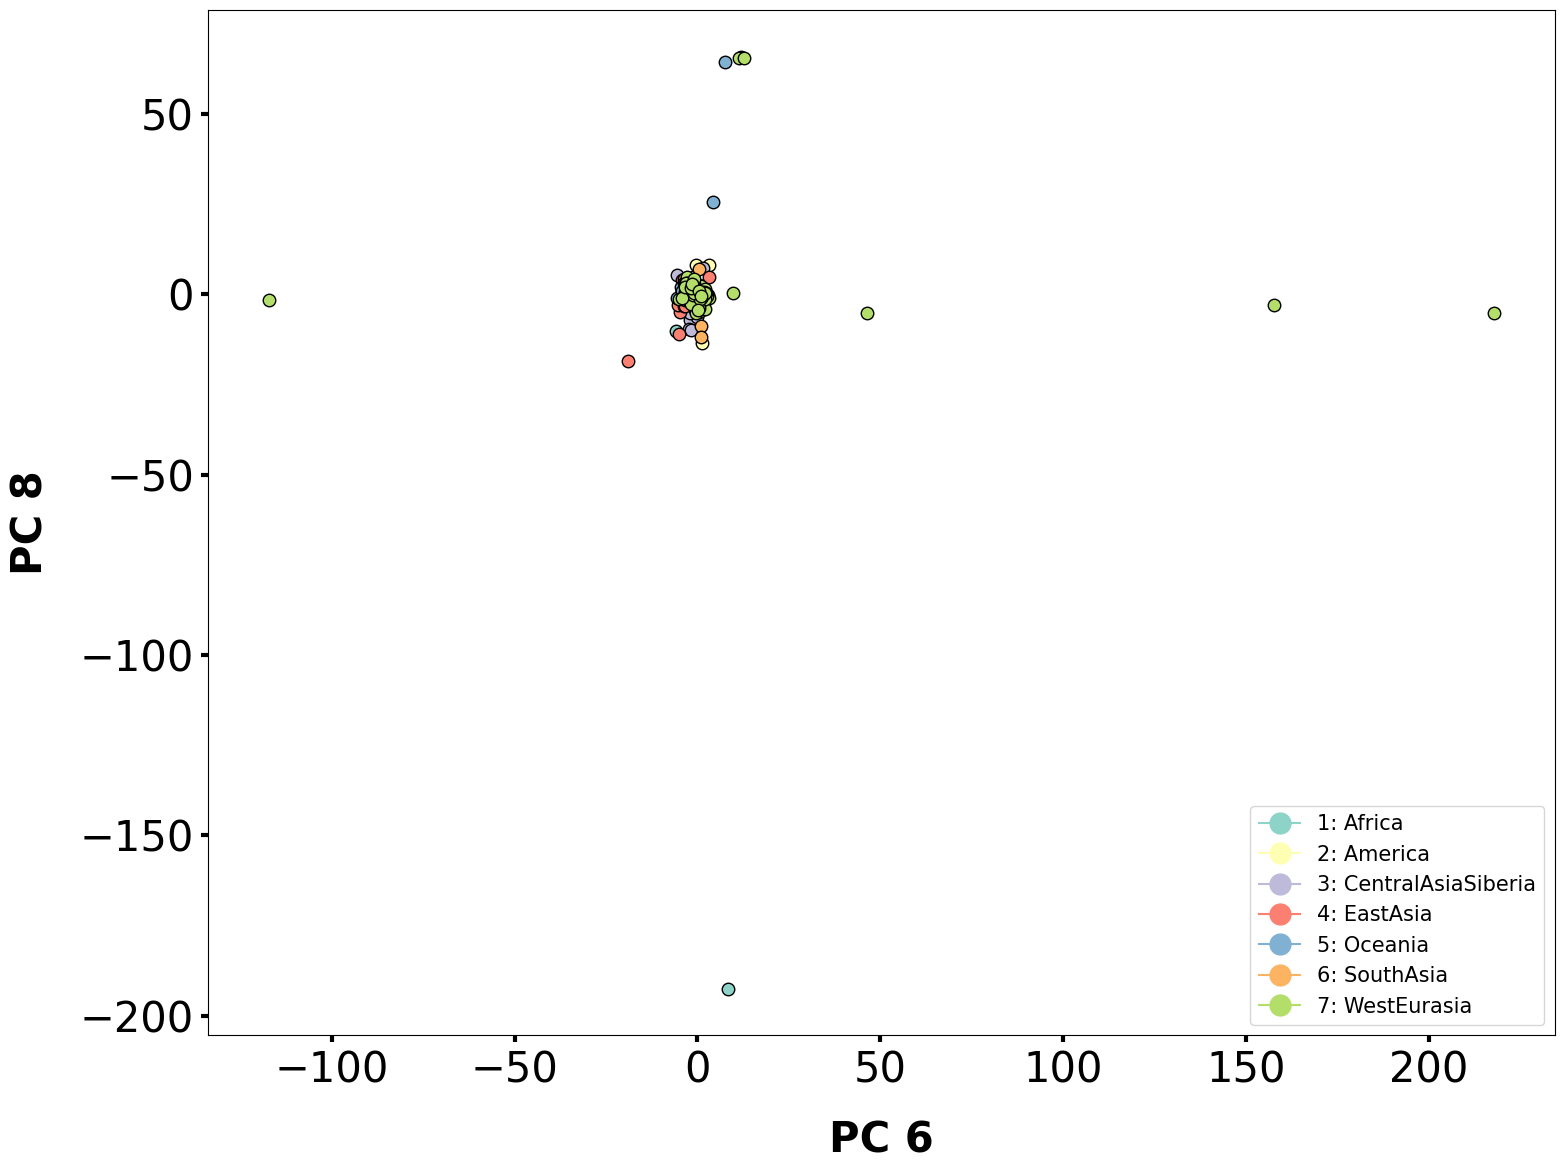

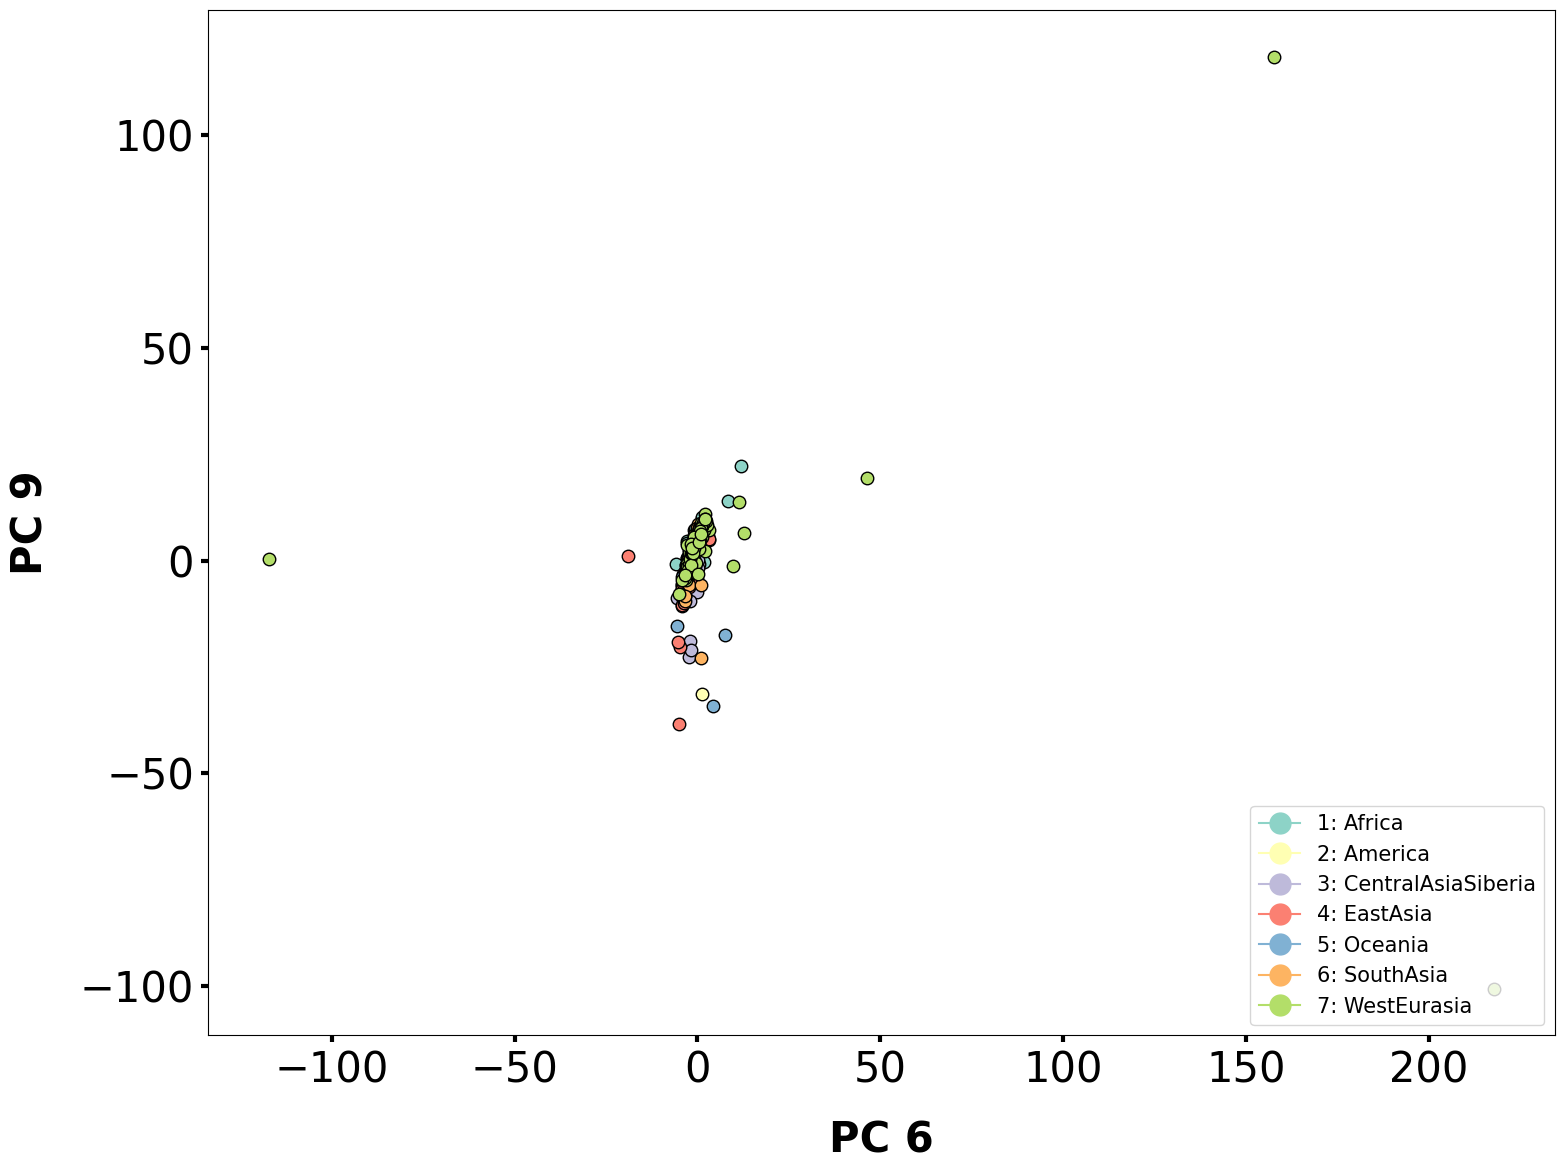

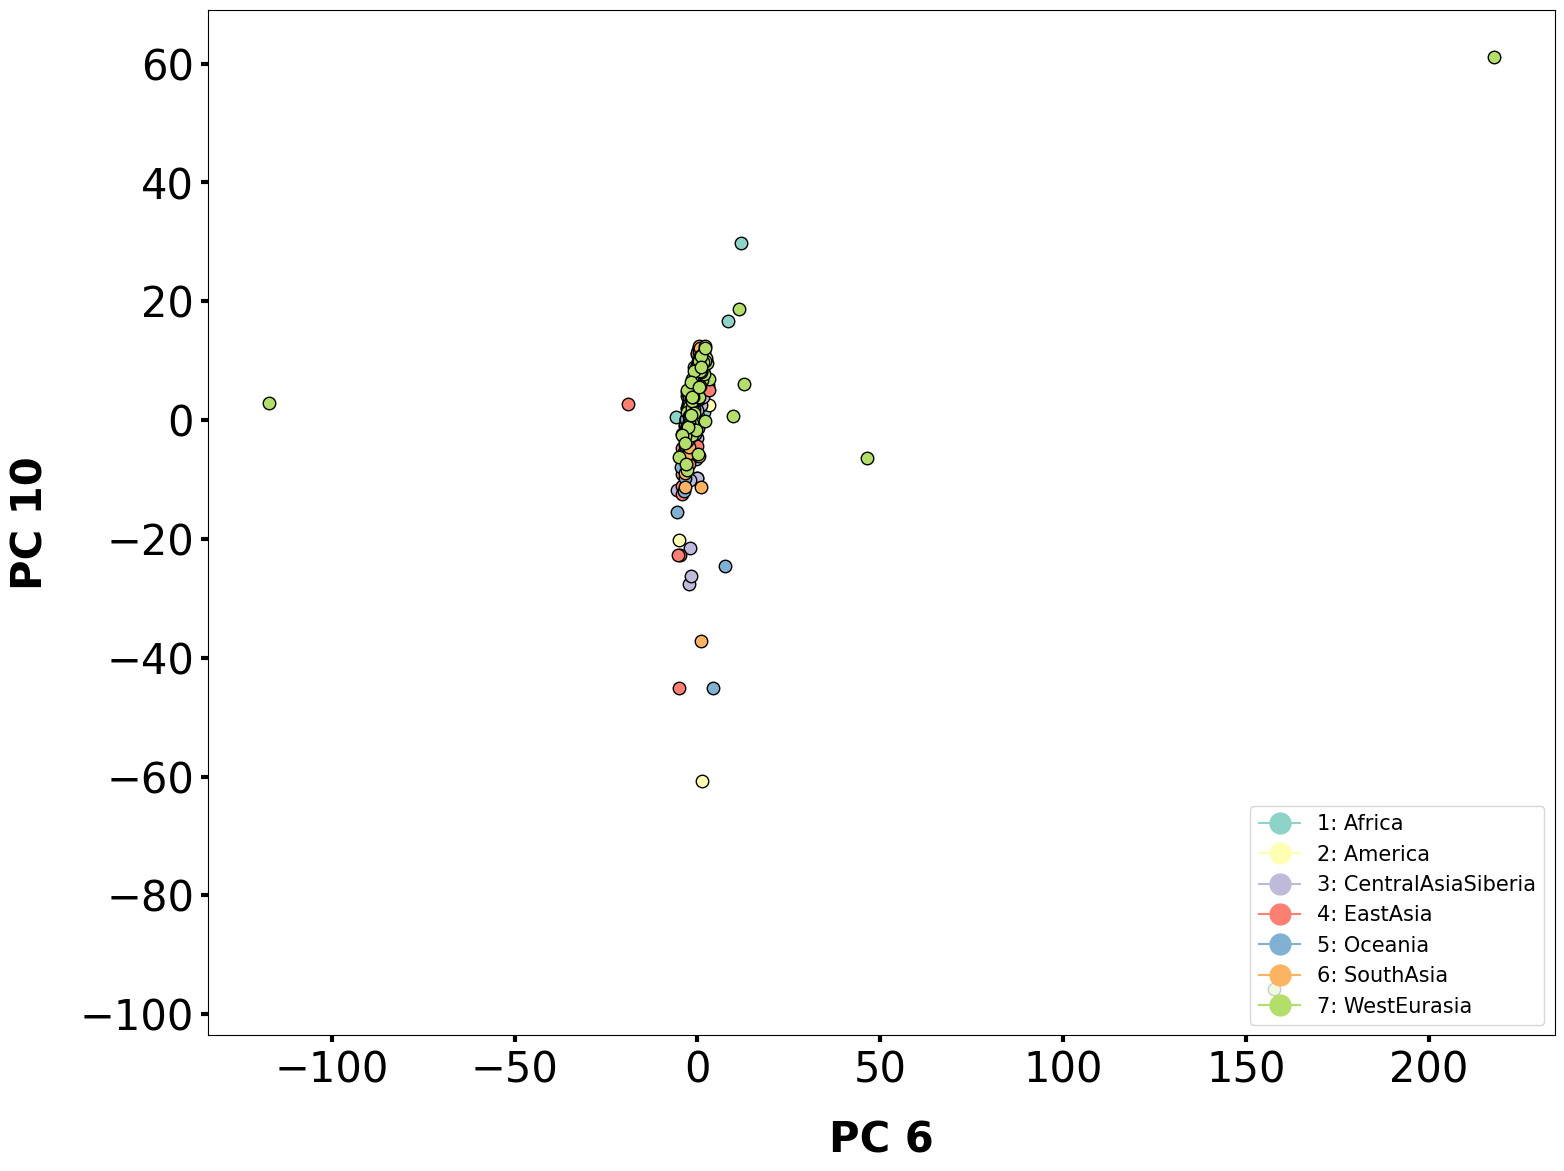

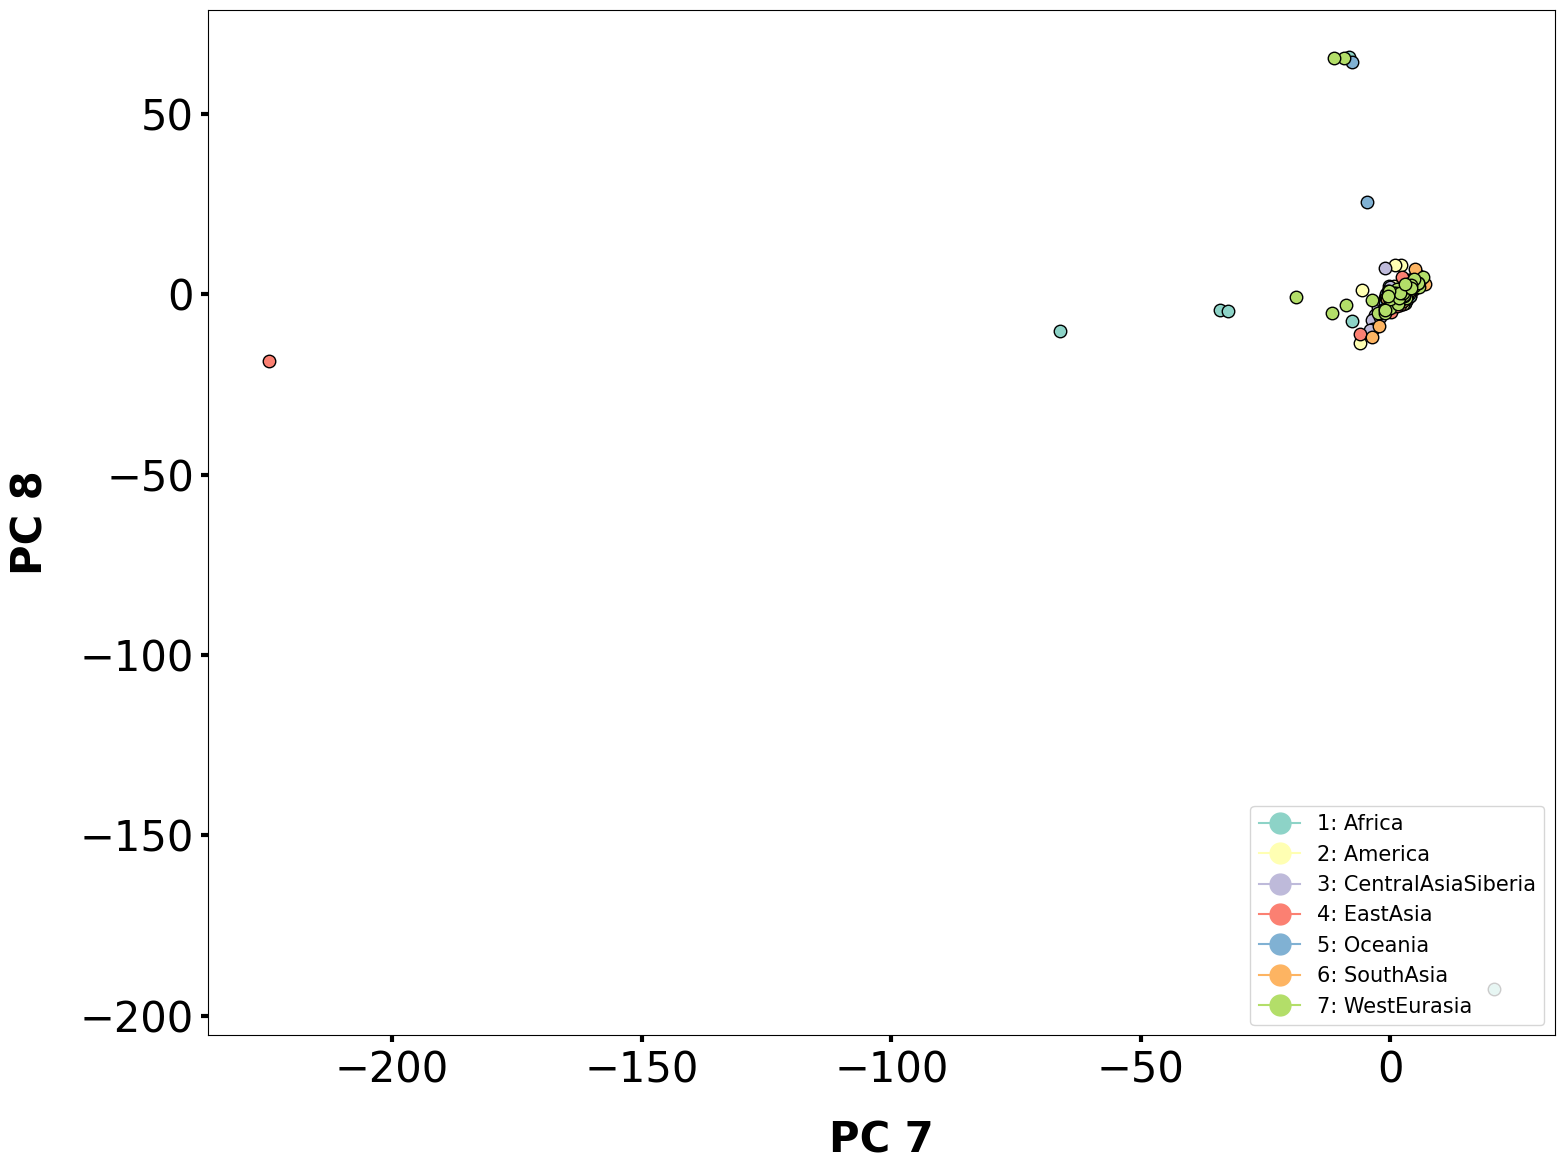

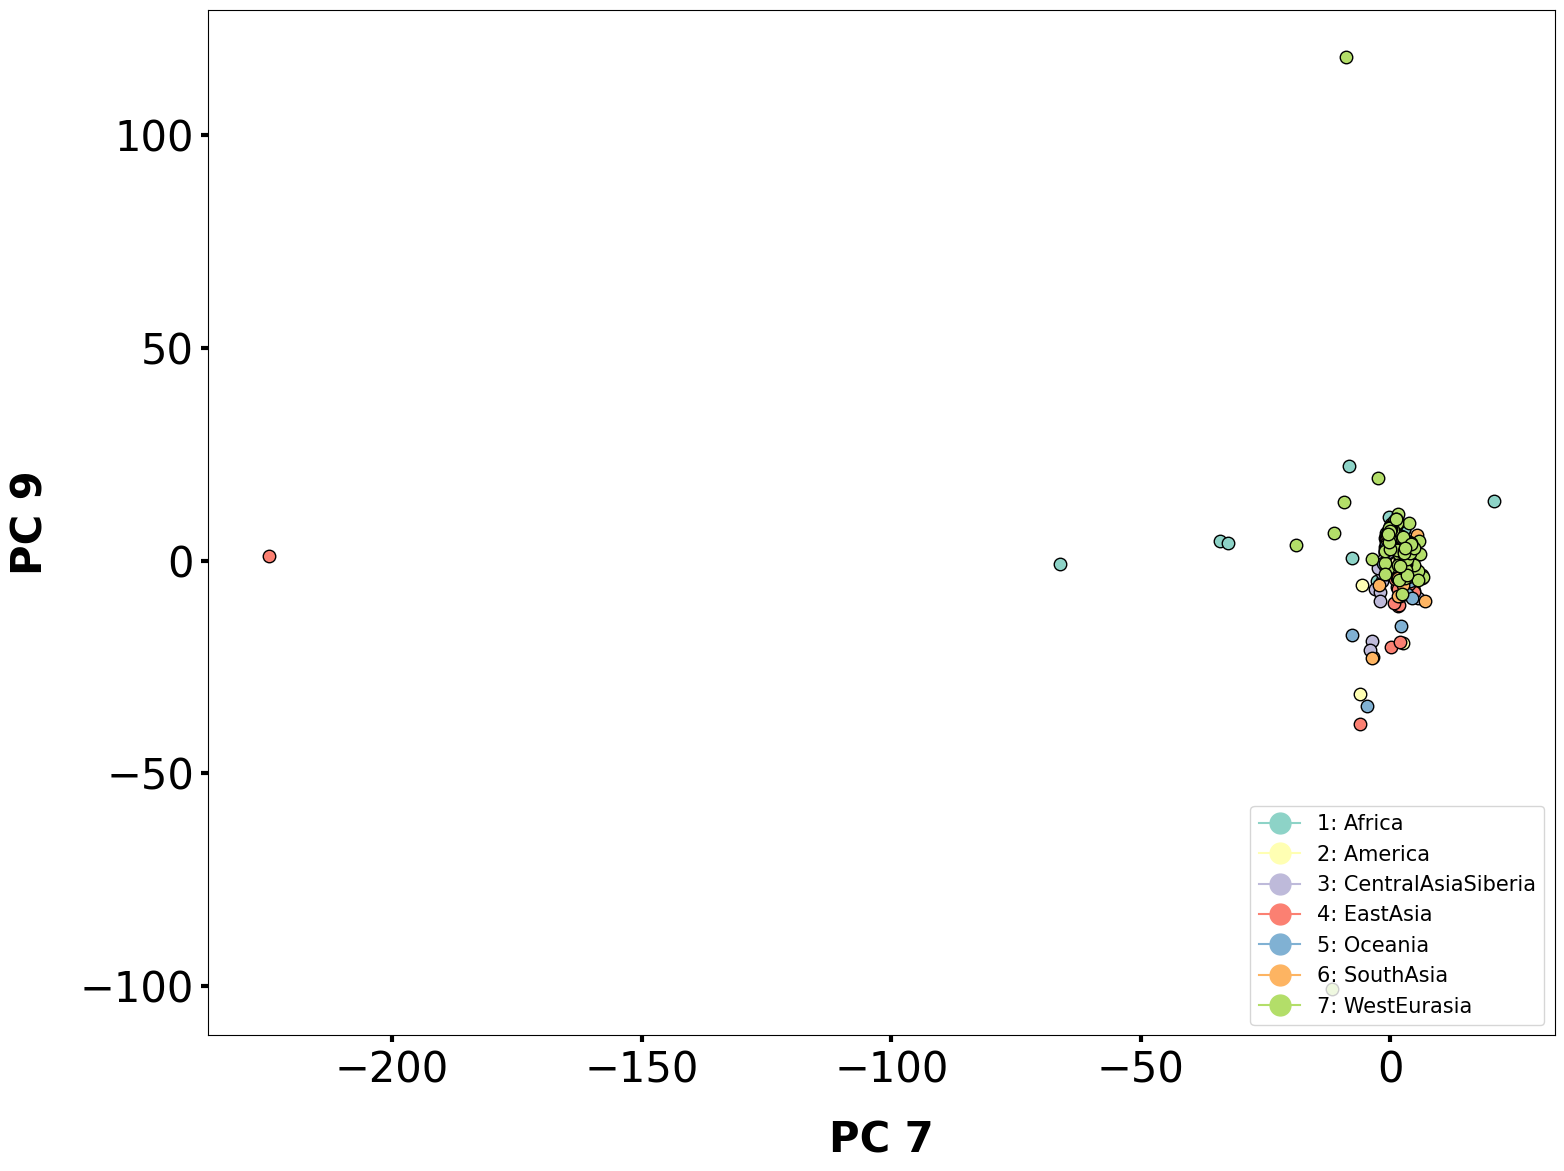

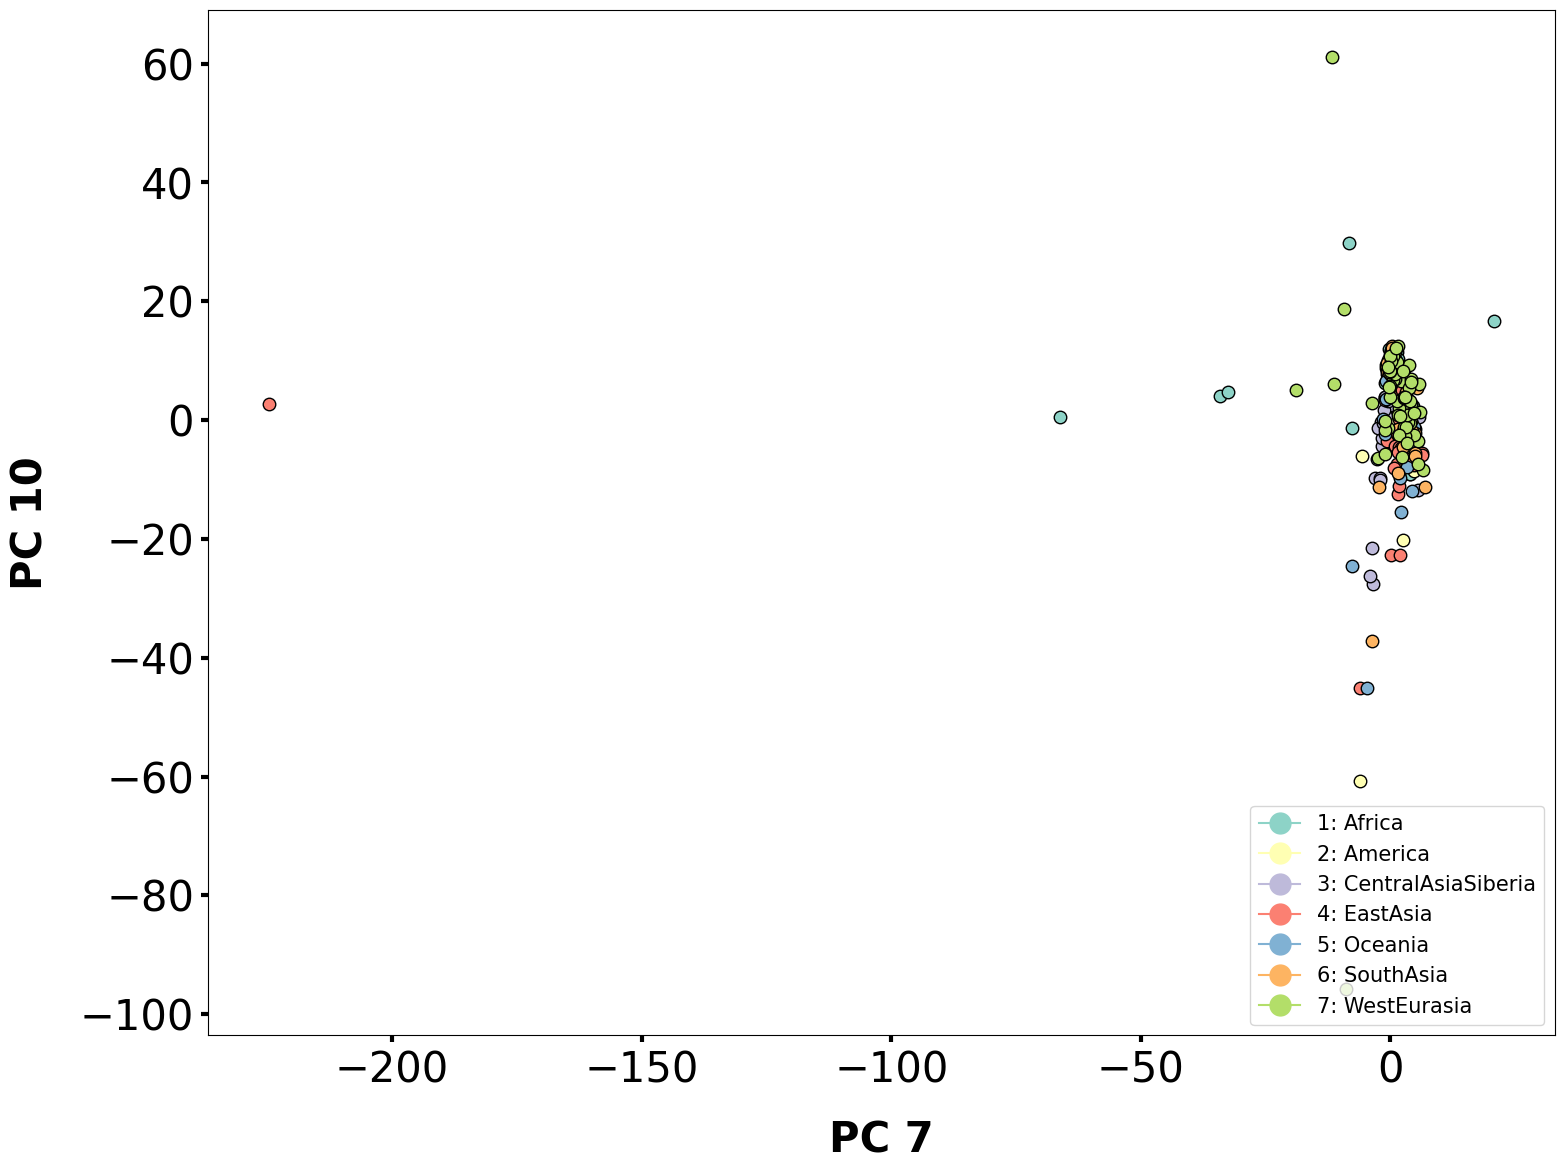

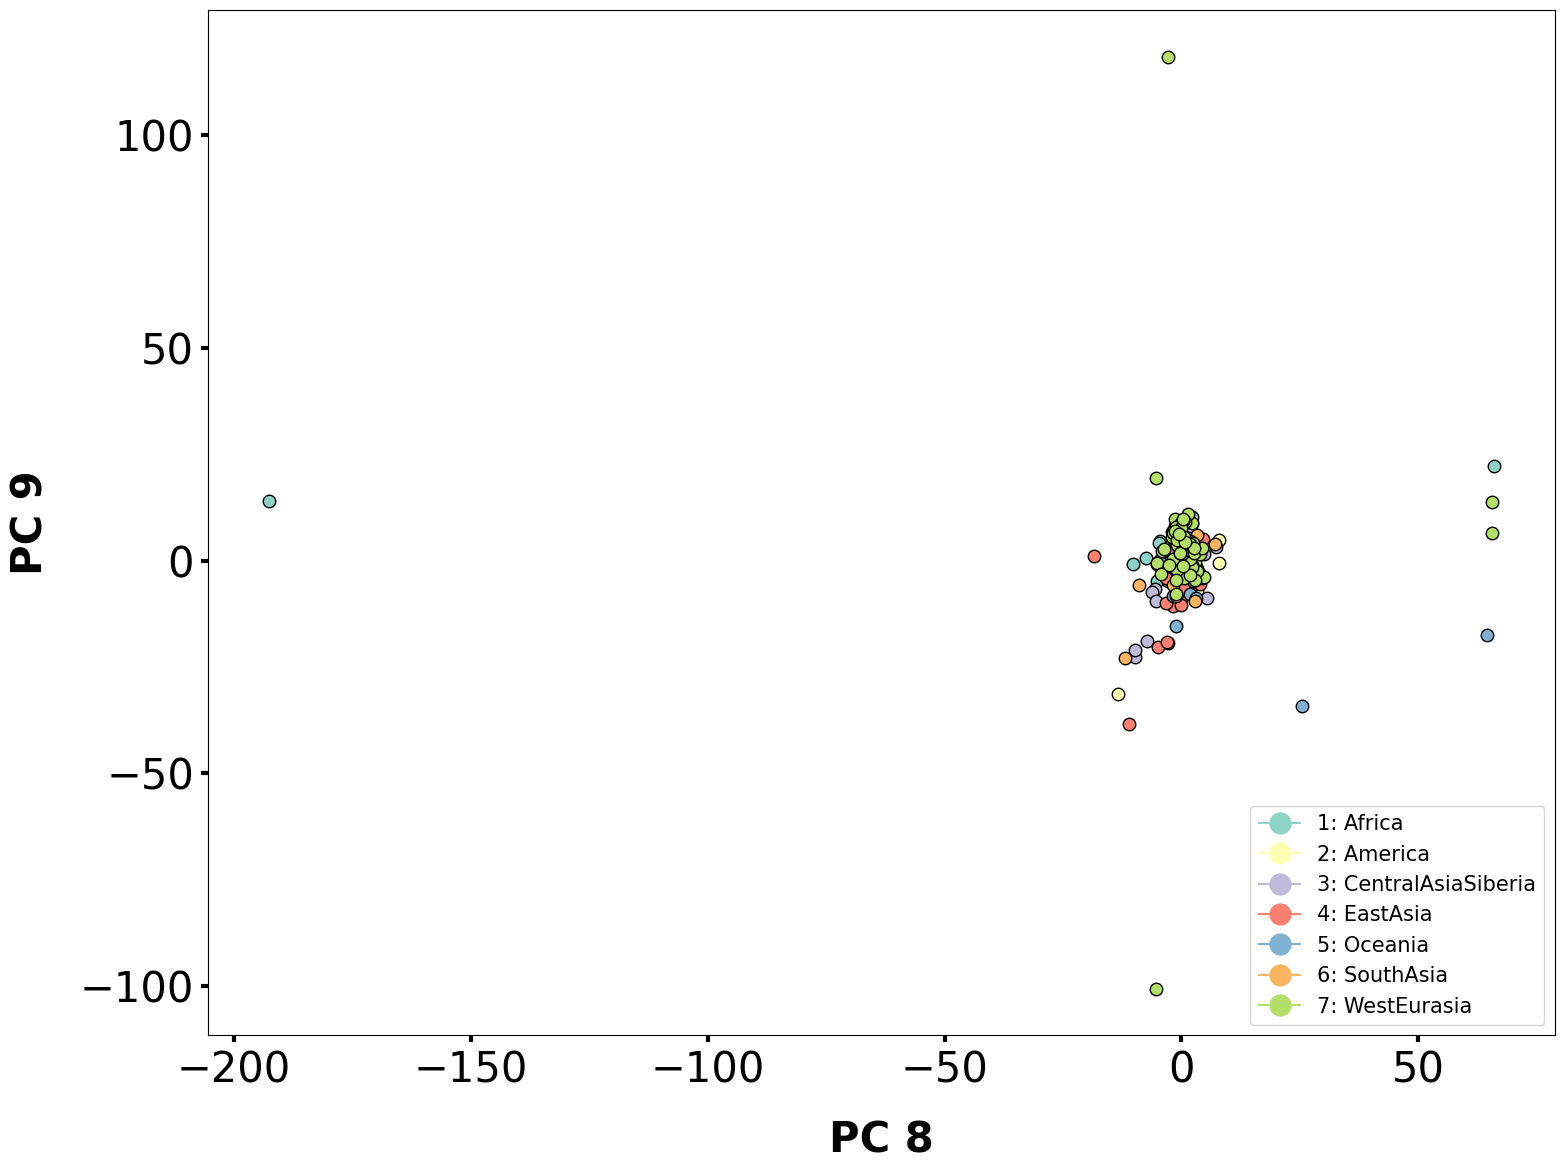

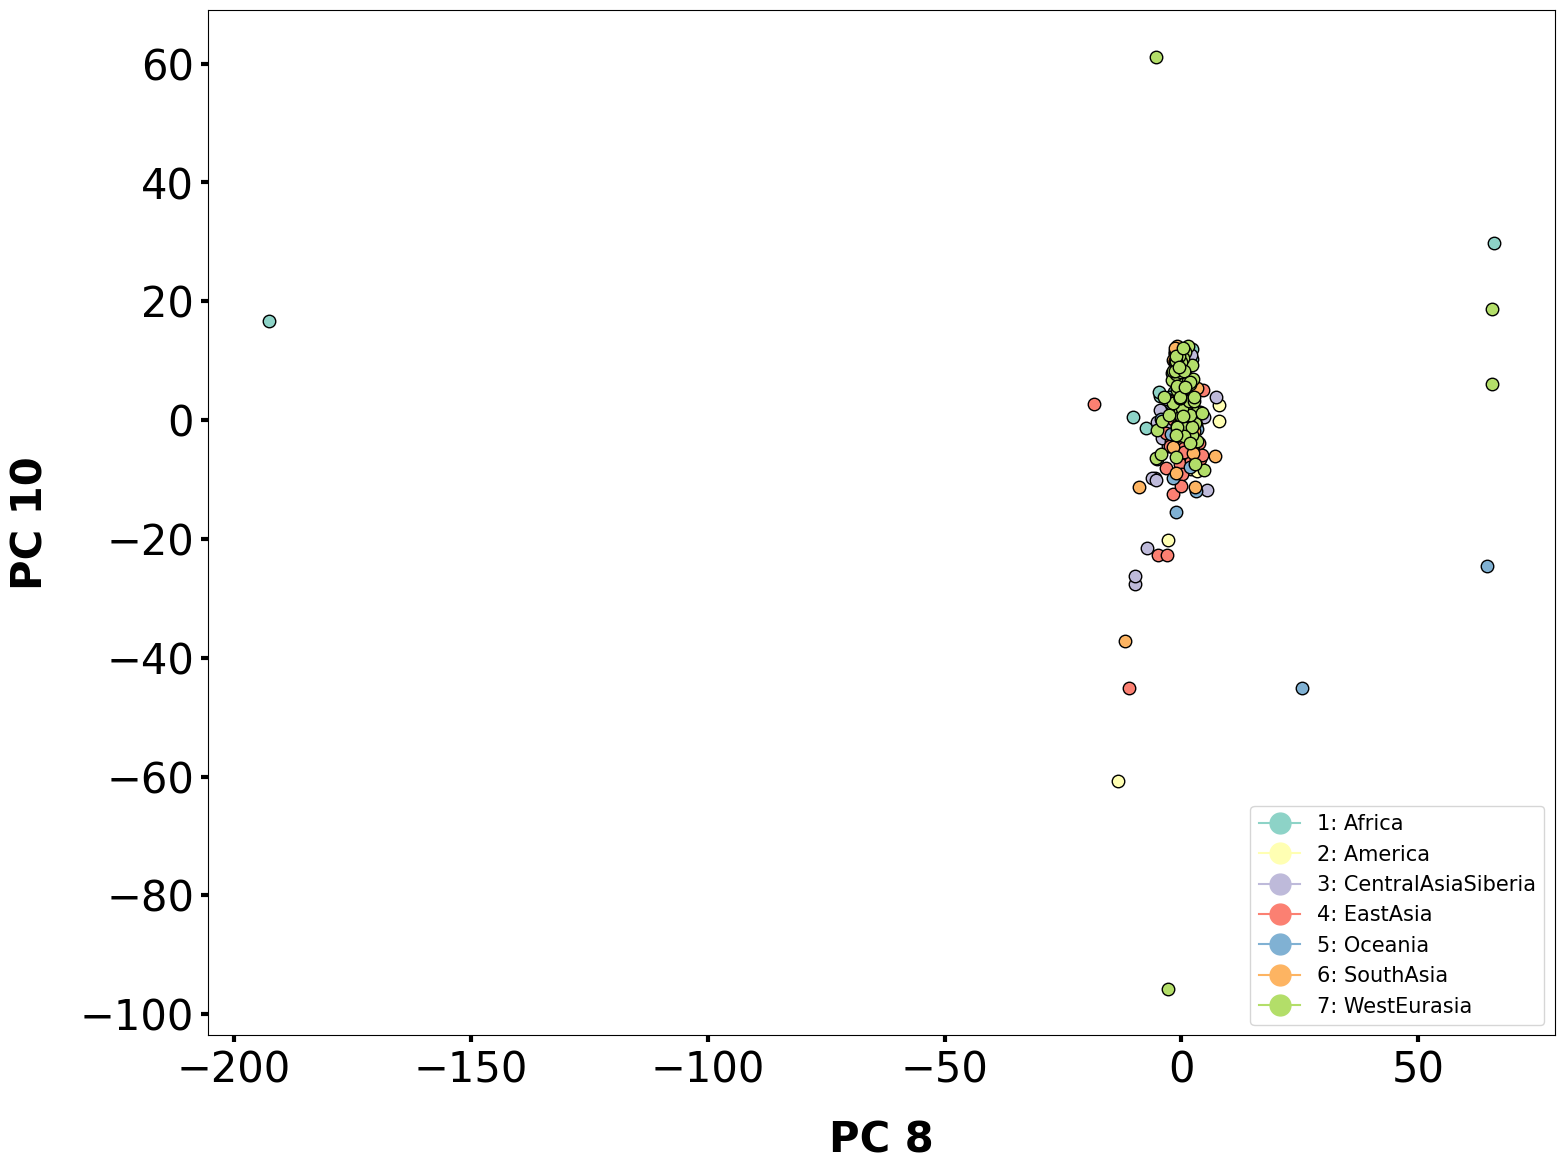

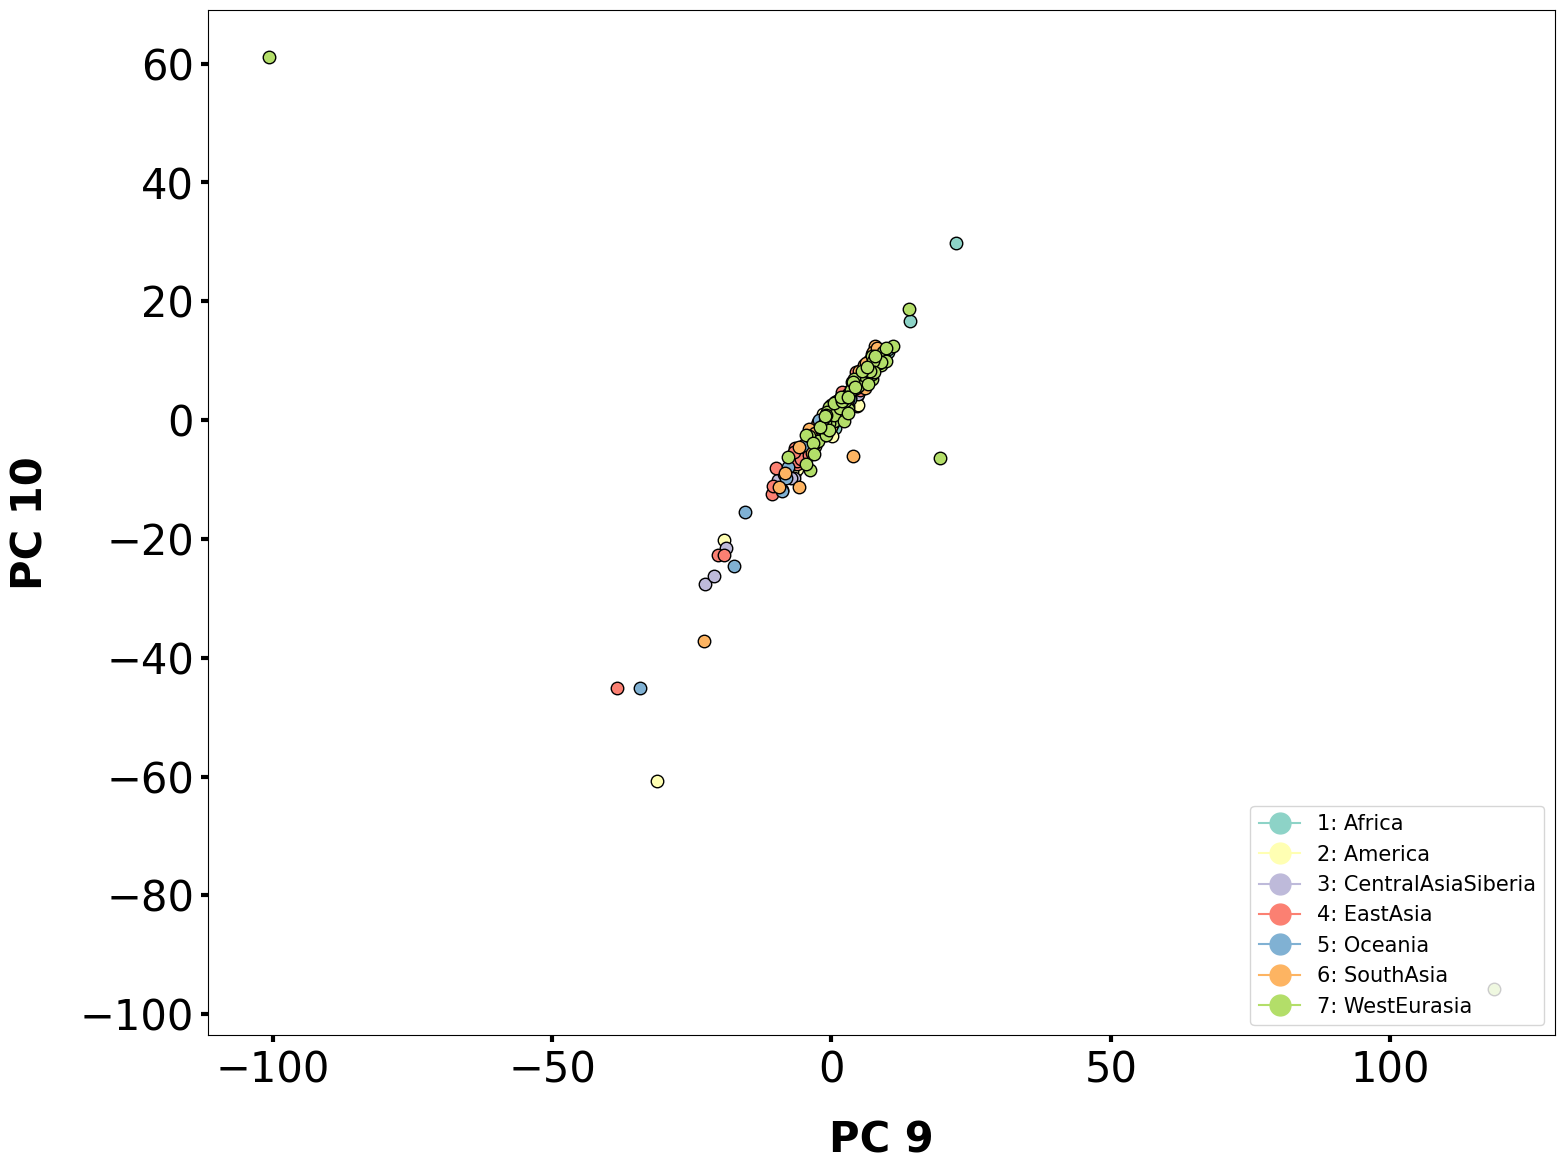

In [21]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))
#    plot_scatter_cluster(data=df_pca, abscissa='component_8', ordinate='component_9', label_horizontal='Component 1', label_vertical='Component 3', factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    

<h2> Vst

In [22]:
#coordinates = input_vst.iloc[:,0:2]
cnvs = final_cnv.iloc[:,4:287]
cnvs = cnvs.T
cnvs = cnvs.fillna(2)
dt = features.merge(cnvs, left_index=True, right_index=True)
dt

Region   33   34   35   36   37   38   39   40   41  \
LP6005441-DNA_A01  WestEurasia  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
LP6005441-DNA_A03      Oceania  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0   
LP6005441-DNA_A04      America  2.0  2.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0   
LP6005441-DNA_A05  WestEurasia  2.0  2.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0   
LP6005441-DNA_A06  WestEurasia  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
LP6007069-DNA_A01  WestEurasia  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0   
SS6004471               Africa  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0   
SS6004477              Oceania  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0   
SS6004478              Oceania  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0   
SS6004480               Africa  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0   

                   ...  920271  920272  920273  920274  920275  920276  \
LP6005441-DNA_A01  ...     2.0     2.0     2.0     2.0     2.0     2.0   
LP6005441-DNA_A03  ...     2.0     2.0     2.0     2.0     2.0     2.0   
LP6005441-DNA_A04  ...     2.0     2.0     2.0     2.0     2.0     2.0   
LP6005441-DNA_A05  ...     2.0     2.0     2.0     2.0     2.0     2.0   
LP6005441-DNA_A06  ...     2.0     2.0     2.0     2.0     2.0     2.0   
...                ...     ...     ...     ...     ...     ...     ...   
LP6007069-DNA_A01  ...     1.0     2.0     2.0     2.0     2.0     2.0   
SS6004471          ...     2.0     2.0     2.0     2.0     2.0     2.0   
SS6004477          ...     2.0     2.0     2.0     2.0     2.0     2.0   
SS6004478          ...     2.0     2.0     2.0     2.0     2.0     2.0   
SS6004480          ...     2.0     2.0     2.0     2.0     2.0     2.0   

                   920277  920279  920280  920285  
LP6005441-DNA_A01     2.0     3.0     3.0     3.0  
LP6005441-DNA_A03     2.0     4.0     3.0     4.0  
LP6005441-DNA_A04     2.0     4.0     4.0     4.0  
LP6005441-DNA_A05     2.0     4.0     3.0     3.0  
LP6005441-DNA_A06     2.0     4.0     4.0     4.0  
...                   ...     ...     ...     ...  
LP6007069-DNA_A01     2.0     4.0     3.0     4.0  
SS6004471             2.0     4.0     3.0     4.0  
SS6004477             2.0     4.0     3.0     4.0  
SS6004478             2.0     4.0     3.0     4.0  
SS6004480             2.0     4.0     3.0     4.0  

[266 rows x 883093 columns]

In [23]:
####### Groupby regions #######
dt_group = dt.groupby('Region')

dt_groupped = []
regions = features['Region'].unique()
regions.sort()
for i in regions:
    dt_groupped.append(dt_group.get_group(str(i)))
    

dt_groupped

[                   Region   33   34   35   36   37   38   39   40   41  ...  \
 LP6005441-DNA_A08  Africa  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0  ...   
 LP6005441-DNA_A11  Africa  2.0  2.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  ...   
 LP6005441-DNA_B02  Africa  2.0  2.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  ...   
 LP6005441-DNA_B08  Africa  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0  ...   
 LP6005441-DNA_B11  Africa  2.0  2.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  ...   
 LP6005441-DNA_E07  Africa  2.0  2.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  ...   
 LP6005441-DNA_F01  Africa  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0  ...   
 LP6005441-DNA_F07  Africa  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0  ...   
 LP6005441-DNA_G02  Africa  2.0  2.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  ...   
 LP6005441-DNA_G08  Africa  1.0  2.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  ...   
 LP6005441-DNA_H02  Africa  2.0  2.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  ...   
 LP6005441-DNA_H08  Africa  2.0  2.0  1.

In [24]:
#### Names to pair-population
regions = dt['Region'].unique()
regions.sort()
combination_names = []
for i in list(combinations(regions,2)):
    combination_names.append(i[0]+str('-')+i[1])

for j in dt_groupped:
    del j['Region']


In [25]:
## Function for Vst 
def vst_function(
    x=None, 
    y=None):

    vx = np.var(x, axis=0)
    vy = np.var(y, axis=0)

    nx = len(x)
    ny = len(y)

## Vt 
    a = np.concatenate((x,y))
    vt = np.ndarray.var(a,axis=0)

### Vs = (V1*n1+V2*n2)/(n1+n2) 

    v1 = vx*nx
    v2 = vy*ny
    ns = nx+ny
    vs = (v1+v2)/ ns
    ########## Vst #################
    #####(VT−VS)/VT
    
    vst = (vt-vs)/vt
    
    return(vst) 


In [26]:
## VST for pair-population
vst_dt = []

combination_regions = list(combinations([0,1,2,3,4,5,6],2))
for region in combination_regions:
        statistic = vst_function((dt_groupped[region[0]]), (dt_groupped[region[1]]))
        vst_dt.append(statistic)

vst_dt = pd.DataFrame(vst_dt).set_axis(combination_names)
vst_dt

33        34        35        36      \
Africa-America                  0.043554  0.008130  0.012864  0.010855   
Africa-CentralAsiaSiberia       0.005943  0.001943  0.007632  0.008148   
Africa-EastAsia                 0.076700  0.044993  0.002346  0.027328   
Africa-Oceania                  0.047540  0.033934  0.016687  0.007378   
Africa-SouthAsia                0.011309  0.035399  0.012031  0.010129   
Africa-WestEurasia              0.011199  0.019140  0.007902  0.000152   
America-CentralAsiaSiberia      0.032922  0.000000  0.040116  0.000335   
America-EastAsia                0.006944  0.021505  0.021991  0.002646   
America-Oceania                      NaN  0.020704  0.000239  0.039839   
America-SouthAsia               0.009234  0.016857  0.035160  0.037720   
America-WestEurasia             0.008292  0.003053  0.001055  0.006585   
CentralAsiaSiberia-EastAsia     0.052403  0.010909  0.001481  0.005160   
CentralAsiaSiberia-Oceania      0.035494  0.004715  0.047236  0.032475   
CentralAsiaSiberia-SouthAsia    0.001261  0.011102  0.000817  0.033955   
CentralAsiaSiberia-WestEurasia  0.000882  0.000759  0.029260  0.005030   
EastAsia-Oceania                0.007629  0.002174  0.027085  0.056696   
EastAsia-SouthAsia              0.023143  0.000411  0.004357  0.065160   
EastAsia-WestEurasia            0.024198  0.019967  0.019067  0.022230   
Oceania-SouthAsia               0.010088  0.003142  0.041337  0.000216   
Oceania-WestEurasia             0.009226  0.007795  0.002091  0.007554   
SouthAsia-WestEurasia           0.000022  0.017982  0.036771  0.011631   

                                  37        38        39        40      \
Africa-America                       NaN       NaN       NaN       NaN   
Africa-CentralAsiaSiberia       0.046016  0.046016  0.046016       NaN   
Africa-EastAsia                 0.032932  0.032932  0.032932  0.010719   
Africa-Oceania                  0.028295  0.028295  0.028295  0.028295   
Africa-SouthAsia                0.025157  0.025157  0.025157       NaN   
Africa-WestEurasia              0.005084  0.005084  0.005084  0.005084   
America-CentralAsiaSiberia      0.032922  0.032922  0.032922       NaN   
America-EastAsia                0.021505  0.021505  0.021505  0.006944   
America-Oceania                 0.020704  0.020704  0.020704  0.020704   
America-SouthAsia               0.016857  0.016857  0.016857       NaN   
America-WestEurasia             0.003053  0.003053  0.003053  0.003053   
CentralAsiaSiberia-EastAsia     0.000199  0.000199  0.000199  0.008451   
CentralAsiaSiberia-Oceania      0.004123  0.004123  0.004123  0.023957   
CentralAsiaSiberia-SouthAsia    0.000057  0.000057  0.000057       NaN   
CentralAsiaSiberia-WestEurasia  0.024450  0.024450  0.024450  0.003827   
EastAsia-Oceania                0.002174  0.002174  0.002174  0.003543   
EastAsia-SouthAsia              0.000411  0.000411  0.000411  0.010298   
EastAsia-WestEurasia            0.019967  0.019967  0.019967  0.000978   
Oceania-SouthAsia               0.003142  0.003142  0.003142  0.027536   
Oceania-WestEurasia             0.007795  0.007795  0.007795  0.007795   
SouthAsia-WestEurasia           0.017982  0.017982  0.017982  0.004842   

                                  41        42      ...    920271    920272  \
Africa-America                       NaN       NaN  ...       NaN       NaN   
Africa-CentralAsiaSiberia            NaN       NaN  ...       NaN       NaN   
Africa-EastAsia                 0.021693       NaN  ...  0.000000  0.010719   
Africa-Oceania                  0.028295  0.028295  ...       NaN       NaN   
Africa-SouthAsia                     NaN       NaN  ...       NaN  0.013833   
Africa-WestEurasia              0.010260  0.005084  ...  0.001685       NaN   
America-CentralAsiaSiberia           NaN       NaN  ...       NaN       NaN   
America-EastAsia                0.014109       NaN  ...  0.000000  0.006944   
America-Oceania                 0.020704  0.020704  ...       NaN

In [27]:
filtering_vst = pd.DataFrame(vst_dt)>=0.2
filtering_vst = filtering_vst.loc[:, filtering_vst.any()]
#filtering_vst = filtering_vst.set_axis(combination_names)
filtering_vst

73      74      201     413     423     \
Africa-America                   False   False    True   False   False   
Africa-CentralAsiaSiberia        False    True   False   False   False   
Africa-EastAsia                  False   False   False   False   False   
Africa-Oceania                   False   False   False    True    True   
Africa-SouthAsia                 False   False   False   False   False   
Africa-WestEurasia               False   False   False   False   False   
America-CentralAsiaSiberia       False   False   False   False   False   
America-EastAsia                 False   False   False   False   False   
America-Oceania                   True   False   False   False    True   
America-SouthAsia                False   False   False   False   False   
America-WestEurasia              False   False   False   False   False   
CentralAsiaSiberia-EastAsia      False   False   False   False   False   
CentralAsiaSiberia-Oceania       False   False   False   False   False   
CentralAsiaSiberia-SouthAsia     False   False   False   False   False   
CentralAsiaSiberia-WestEurasia   False   False   False   False   False   
EastAsia-Oceania                 False   False   False   False    True   
EastAsia-SouthAsia               False   False   False   False   False   
EastAsia-WestEurasia             False   False   False   False   False   
Oceania-SouthAsia                False   False   False   False    True   
Oceania-WestEurasia              False   False   False   False    True   
SouthAsia-WestEurasia            False   False   False   False   False   

                                513     1517    2645    2656    2657    ...  \
Africa-America                   False   False   False    True    True  ...   
Africa-CentralAsiaSiberia        False   False   False    True    True  ...   
Africa-EastAsia                  False   False   False   False   False  ...   
Africa-Oceania                   False   False   False   False   False  ...   
Africa-SouthAsia                 False   False   False   False   False  ...   
Africa-WestEurasia               False   False   False   False   False  ...   
America-CentralAsiaSiberia        True   False   False   False   False  ...   
America-EastAsia                 False   False   False    True    True  ...   
America-Oceania                  False   False   False    True    True  ...   
America-SouthAsia                False    True   False    True    True  ...   
America-WestEurasia              False   False   False    True    True  ...   
CentralAsiaSiberia-EastAsia      False   False   False    True    True  ...   
CentralAsiaSiberia-Oceania       False   False   False   False   False  ...   
CentralAsiaSiberia-SouthAsia     False   False    True   False   False  ...   
CentralAsiaSiberia-WestEurasia   False   False   False    True    True  ...   
EastAsia-Oceania                 False   False   False   False   False  ...   
EastAsia-SouthAsia               False   False   False   False   False  ...   
EastAsia-WestEurasia             False   False   False   False   False  ...   
Oceania-SouthAsia                False   False   False   False   False  ...   
Oceania-WestEurasia              False   False   False   False   False  ...   
SouthAsia-WestEurasia            False   False   False   False   False  ...   

                                917261  917480  917535  917634  917682  \
Africa-America                   False   False   False   False   False   
Africa-CentralAsiaSiberia        False   False   False   False   False   
Africa-EastAsia                  False   False   False   False   False   
Africa-Oceania                   False    True   False   False   False   
Africa-SouthAsia                 False   False   False   False   False   
Africa-WestEurasia                True    True   False    True   False   
America-CentralAsiaSiberia       False   False   False   False    True   
America-EastAsia                 False   False   False   False   False  

In [28]:
## Coordinates anotation 
vst_dt = vst_dt.T
vst_dt.insert (0, 'Chromosome', final_cnv['Chromosome'])
vst_dt.insert (1, 'Start', final_cnv['Start'])
vst_dt.insert (2, 'End', final_cnv['End'])
#vst_dt.insert (3, 'Type', final_cnv['Type'])
vst_dt = vst_dt.round(5)
vst_dt = vst_dt.replace(np.NaN, 0)
#vst_dt

In [29]:
vst_dt_filtered = vst_dt.loc[filtering_vst.T.index]
vst_dt_filtered#.sort_values(by=['WestEurasia-Oceania'], ascending=False).head(50)
vst_dt_filtered.to_csv('vst_candidates_chm13t2t_cnvs.csv', index=False)
vst_dt_filtered.iloc[:,0:3].to_csv('vst_candidates_chm13t2t_coordinates.bed', sep='\t', header=False, index=False)

In [30]:
cnv_passed_vst = final_cnv.loc[filtering_vst.T.index]
cnv_passed_vst.to_csv('../data/t2t_differentiated_cnvs.csv', index=False)

pop =  ids_hg19.set_index('Sample').merge(cnv_passed_vst.T, left_index=True, right_index=True)

In [31]:
cnv_passed_vst['length'] = cnv_passed_vst['End'] -  cnv_passed_vst['Start']

In [32]:
cnv_passed_vst

Unnamed: 0 Chromosome     Start       End  LP6005441-DNA_A01  \
73          930528       chr1    384084    385084                3.0   
74          930529       chr1    385084    387761                2.0   
201         930656       chr1    636035    637514                1.0   
413         930868       chr1   1093209   1095911                3.0   
423         930878       chr1   1111010   1112728                3.0   
...            ...        ...       ...       ...                ...   
918011       61632      chr22  46537915  46539386                2.0   
918297       61918      chr22  47073439  47074439                2.0   
918998       62620      chr22  48687861  48692337                1.0   
919226       62848      chr22  49113340  49116195                3.0   
919566       63188      chr22  49781932  49783037                2.0   

        LP6005441-DNA_A03  LP6005441-DNA_A04  LP6005441-DNA_A05  \
73                    2.0                3.0                3.0   
74                    2.0                2.0                2.0   
201                   2.0                2.0                2.0   
413                   3.0                3.0                3.0   
423                   2.0                3.0                2.0   
...                   ...                ...                ...   
918011                2.0                2.0                2.0   
918297                3.0                2.0                2.0   
918998                2.0                1.0                2.0   
919226                3.0                2.0                3.0   
919566                2.0                2.0                2.0   

        LP6005441-DNA_A06  LP6005441-DNA_A08  ...  LP6005677-DNA_E01  \
73                    3.0                2.0  ...                3.0   
74                    2.0                2.0  ...                3.0   
201                   2.0                2.0  ...                1.0   
413                   3.0                3.0  ...                3.0   
423                   3.0                3.0  ...                3.0   
...                   ...                ...  ...                ...   
918011                2.0                1.0  ...                2.0   
918297                2.0                2.0  ...                2.0   
918998                2.0                2.0  ...                2.0   
919226                2.0                3.0  ...                2.0   
919566                1.0                2.0  ...                1.0   

        LP6005677-DNA_F01  LP6005677-DNA_G01  LP6007068-DNA_A01  \
73                    3.0                3.0                3.0   
74                    2.0                2.0                3.0   
201                   2.0                2.0                2.0   
413                   3.0                3.0                2.0   
423                   2.0                3.0                2.0   
...                   ...                ...                ...   
918011                2.0                2.0                1.0   
918297                3.0                3.0                2.0   
918998                2.0                2.0                2.0   
919226                2.0                4.0                3.0   
919566                1.0                2.0                2.0   

        LP6007069-DNA_A01  SS6004471  SS6004477  SS6004478  SS6004480  length  
73                    3.0        3.0        3.0        2.0        3.0    1000  
74                    2.0        2.0        2.0        2.0        2.0    2677  
201                   2.0        2.0        2.0        1.0        1.0    1479  
413                   1.0        3.0        3.0        3.0        3.0    2702  
423                   2.0        3.0        3.0        2.0        3.0    1718  
...                   ...        ...        ...        ...        ...     ...  
918011                1.0        1.0        1.0        1.0        1.0    1471  
918297                2.0   

<h2> Deletions

<h3> PCA

             component_1  component_2
Region                               
WestEurasia    -6.414570     0.019771
Oceania        -6.884994   -12.934578
America        -6.552385    -7.834358
WestEurasia    -5.818113     5.797017
WestEurasia    -9.344879     7.806648
...                  ...          ...
WestEurasia    17.311138     5.799931
Africa         -4.315668     3.167061
Oceania         1.746768   -12.174422
Oceania        -0.337406   -17.946531
Africa          0.445827    12.311854

[266 rows x 2 columns]
Count of groups by factor: 7


/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:85: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:102: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:


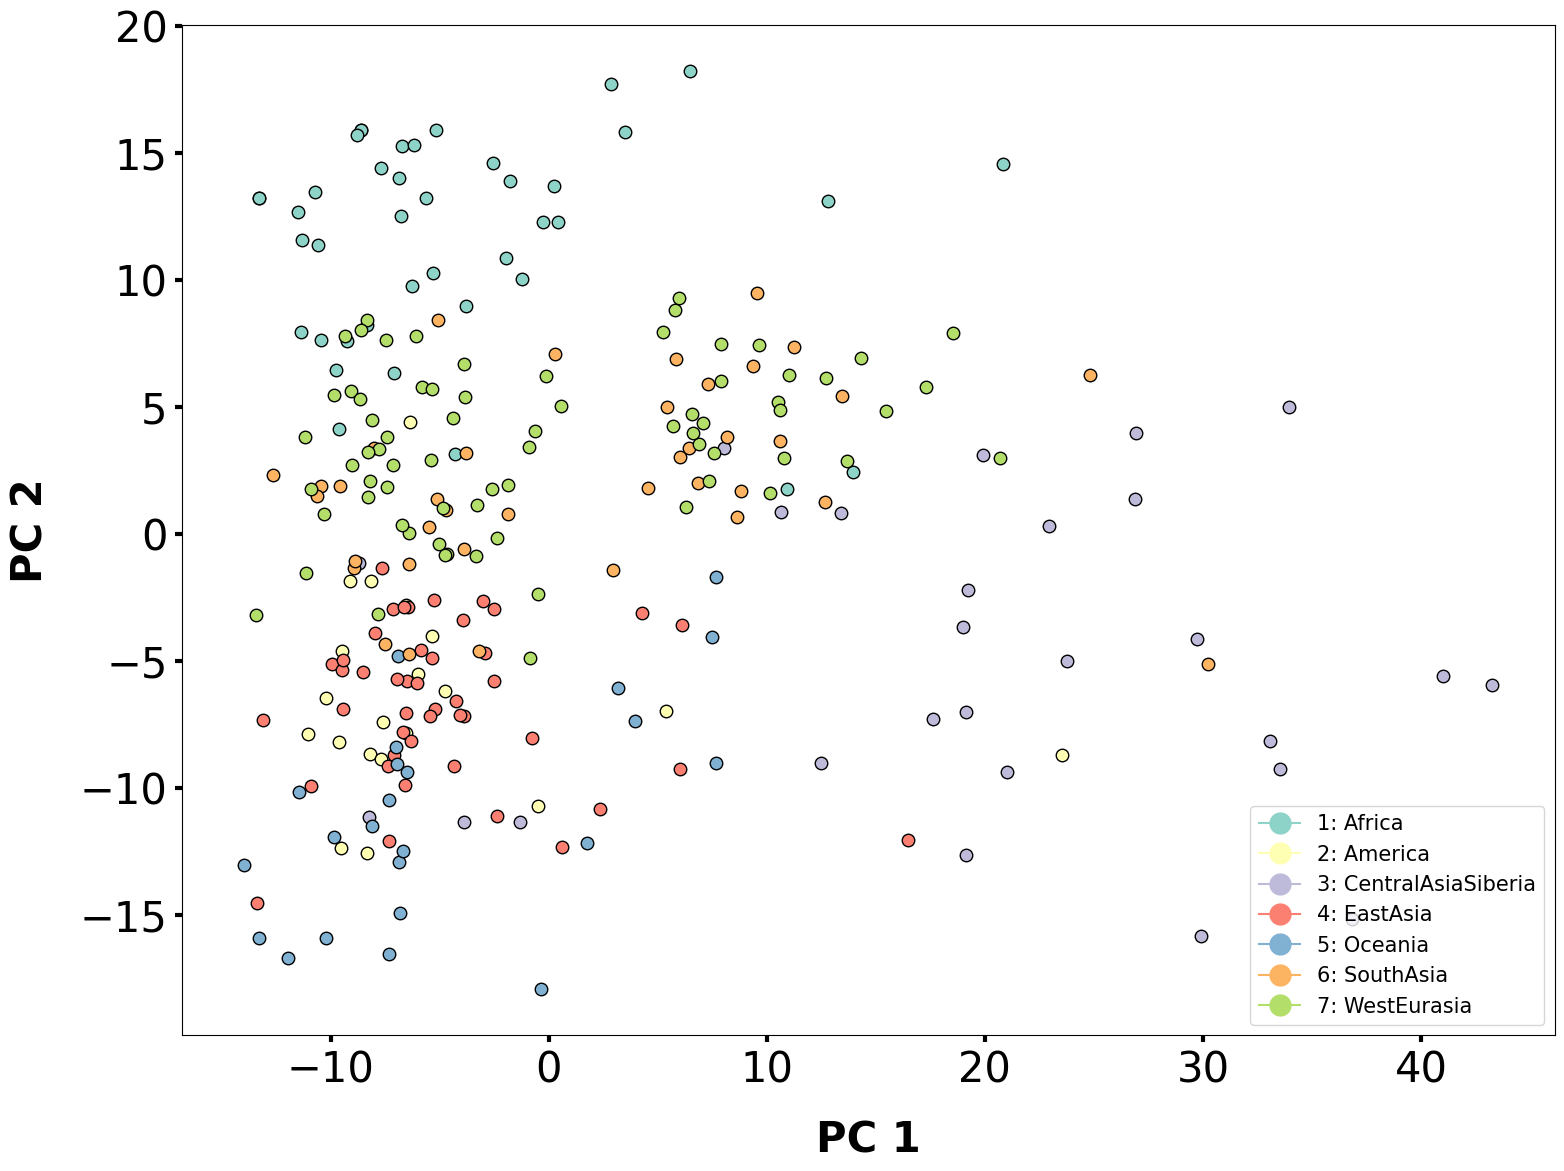

In [53]:
final = cnv_passed_vst.iloc[:,4:287]
deletions = final[(final[final.columns[1:]]<3).all(axis=1)]
#deletions = deletions[(deletions[deletions.columns[1:]]>1).all(axis=1)]
counts = deletions
counts = counts.fillna(2)
counts = counts.T
counts = counts.sort_index()
features = ids_hg19.set_index('Sample').merge(counts, left_index=True, right_index=True)
features = features.loc[:,['Region']]
features = features.sort_index()

x = StandardScaler().fit_transform(counts)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(x)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2'],
                          index=features.index)


df_pca = features.merge(df_pca, left_index=True, right_index=True)

components = [1,2]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)


In [25]:
def create_legend_elements(
colors=None,
labels=None,
markers=None,
):
    """
    Creates custom elements for legend.
    arguments:
        colors (list<dict>): colors
        labels (str): name of data column with independent variable
    raises:
    returns:
        (list<object>): elements for legend
    """
    import seaborn
    elements = []
    for index in range(len(labels)):
        element = matplotlib.lines.Line2D(
            [0],
            [0],
            marker=markers[index],
            color=colors[index],
            label=labels[index],
            markerfacecolor=colors[index],
            markeredgecolor='k',
            markersize=15,
        )
        elements.append(element)
    return elements

def plot_scatter_cluster_shape(
data=None,
abscissa=None,
ordinate=None,
label_horizontal=None,
label_vertical=None,
factor=None,
fonts=None,
colors=None,
legend=None,
):
    """
    Creates a figure of a chart of type histogram to represent the frequency
    distribution of a single series of values.
    arguments:
        data (object): Pandas data frame of groups, series, and values
        abscissa (str): name of data column with independent variable
        ordinate (str): name of data column with dependent variable
        label_horizontal (str): label for horizontal axis
        label_vertical (str): label for vertical axis
        factor (str): name of data column with groups or factors of samples
        fonts (dict<object>): references to definitions of font properties
        colors (dict<tuple>): references to definitions of color properties
        legend (bool): whether to include a legend for series on the chart
    raises:
    returns:
        (object): figure object
    """
##########
# Organize data.
# Separate points by groups.
# Define groups.
    
    import matplotlib
    data = data.copy(deep=True)   
    data.set_index(
        factor,
append=False,
drop=True,
inplace=True
    )
    print(data)
    groups = data.groupby(level=[factor])
    print("Count of groups by factor: " + str(len(groups)))
    import seaborn
    colors_series = list(seaborn.color_palette("Set3", n_colors=len(groups)))
    shape_series = list(['o','v','d','>','h','<','s'])
##########
# Create figure.
    figure = matplotlib.pyplot.figure(
    figsize=(15.748, 11.811),
    tight_layout=True
    )
# Create axes.
    axes = matplotlib.pyplot.axes()
    axes.set_xlabel(
    xlabel=label_horizontal,
labelpad=20,
alpha=1.0,
backgroundcolor=colors["white"],
color=colors["black"],
fontproperties=fonts["properties"]["one"]
    )
    axes.set_ylabel(
        ylabel=label_vertical,
        labelpad=20,
        alpha=1.0,
        backgroundcolor=colors["white"],
        color=colors["black"],
        fontproperties=fonts["properties"]["one"]
    )
    axes.tick_params(
        axis="both",
        which="both",
        direction="out",
        length=5.0,
        width=3.0,
        color=colors["black"],
        pad=5,
        labelsize=fonts["values"]["one"]["size"],
        labelcolor=colors["black"]
    )
# Plot points for values from each group.
    index = 0
    for name, group in groups:
        values_x = group[abscissa].to_list()
        values_y = group[ordinate].to_list()
        handle = axes.plot(
            values_x,
            values_y,
linestyle="",
marker= shape_series[index],
markersize=9, 
markeredgecolor=colors["black"],
markerfacecolor=colors_series[index] # colors["black"]
        )
        index += 1
        pass
# Plot labels for each group.
    labels = []
    index = 0
    for name, group in groups:
        values_x = group[abscissa].to_list()
        mean_x = statistics.median(values_x)
        values_y = group[ordinate].to_list()
        mean_y = statistics.median(values_y)
#        axes.text(
#            mean_x,
#            mean_y,
#str(index+1),
#backgroundcolor=colors["white_faint"],
#color=colors["black"],
#fontproperties=fonts["properties"]["three"],
#horizontalalignment="center",
#verticalalignment="center"
#        )
        label = str(index+1) + ": " + name
        labels.append(label)
        index += 1
        pass
# Create legend.
# Create custome elements for the legend
    elements = create_legend_elements(
colors=colors_series,
markers= shape_series,
labels=labels
    )
    axes.legend(
handles=elements,
loc="lower right",
prop=fonts["properties"]["four"],
    )
    return figure

<h3> T-SNE

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


             component_1  component_2
Region                               
WestEurasia   -17.453079    14.973862
Oceania         7.548000    51.456207
America        15.659391    11.043983
WestEurasia     3.105601     7.966846
WestEurasia     2.527321     8.802829
...                  ...          ...
WestEurasia    26.024260   -26.401375
Africa         54.315666    -3.759023
Oceania        16.911812    59.752644
Oceania        16.334734    59.581539
Africa         54.902378     9.395243

[266 rows x 2 columns]
Count of groups by factor: 7


/var/folders/05/4pfxtbrs5459ytz3j1jhcgt00000gn/T/ipykernel_32949/2124056540.py:115: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/var/folders/05/4pfxtbrs5459ytz3j1jhcgt00000gn/T/ipykernel_32949/2124056540.py:132: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:


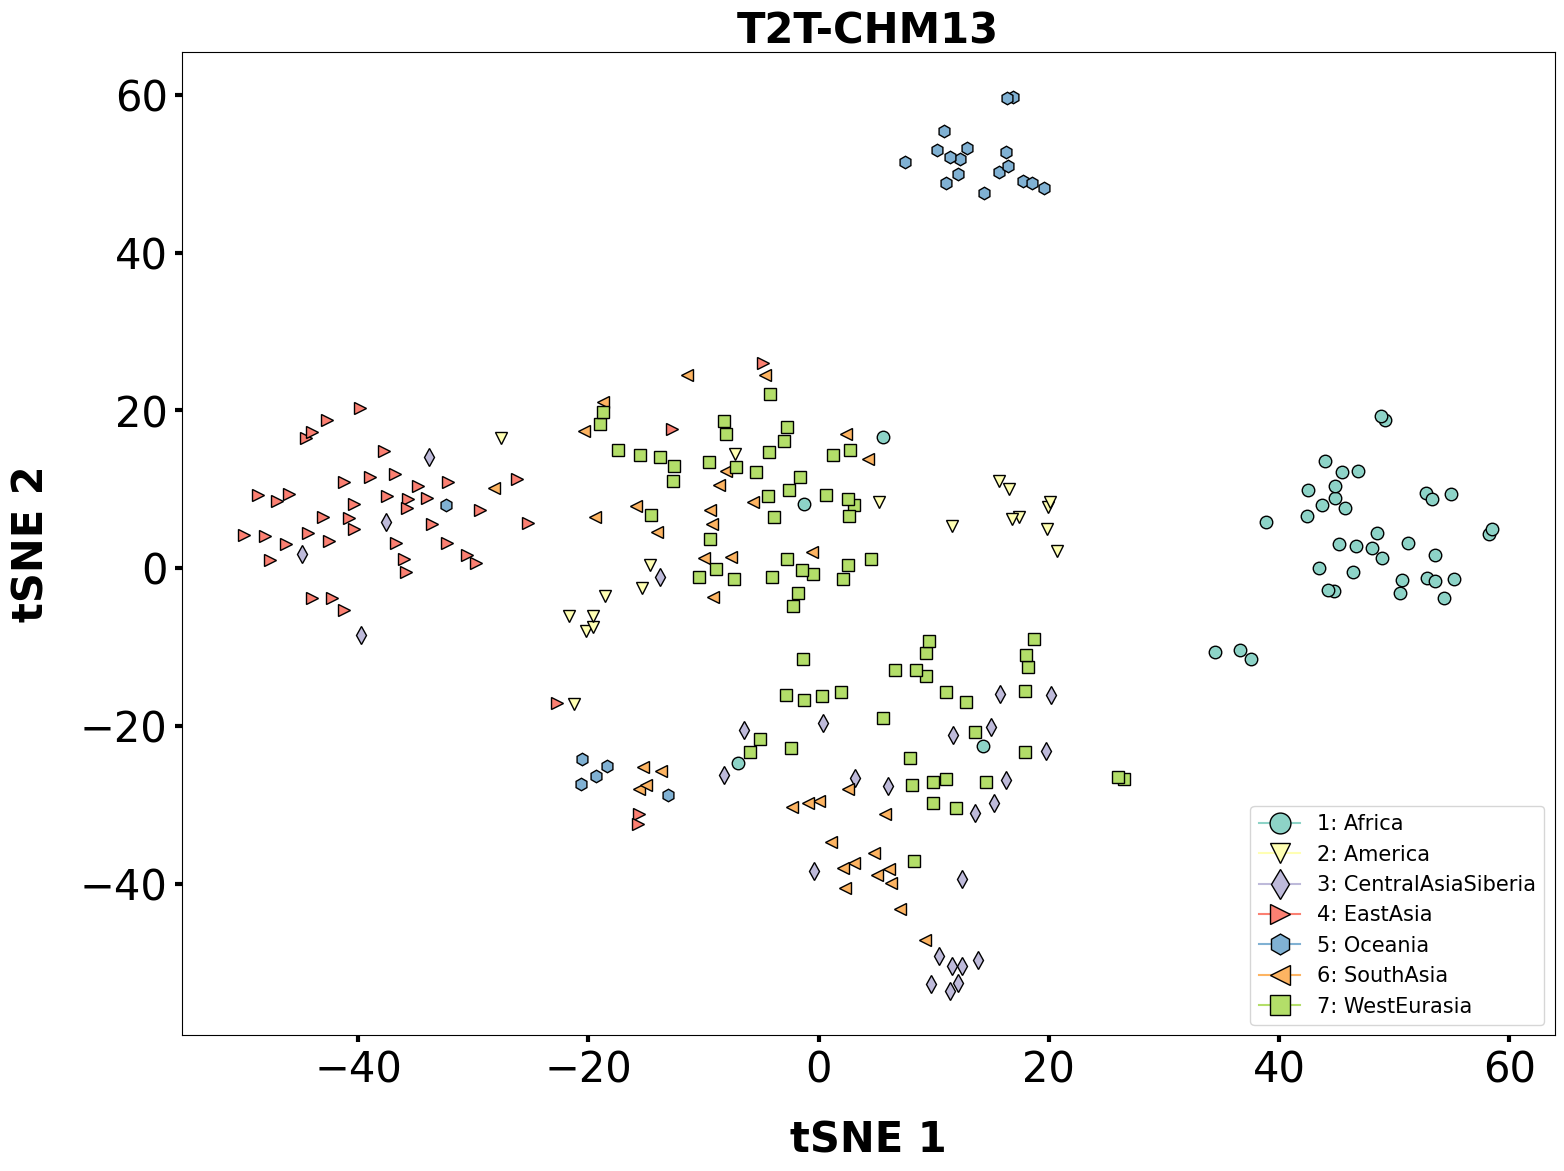

In [26]:
final = cnv_passed_vst.iloc[:,4:287]
deletions = final[(final[final.columns[1:]]<3).all(axis=1)]
#deletions = deletions[(deletions[deletions.columns[1:]]>1).all(axis=1)]
counts = deletions
counts = counts.fillna(2)
counts = counts.T
counts = counts.sort_index()
features = ids_hg19.set_index('Sample').merge(counts, left_index=True, right_index=True)
features = features.loc[:,['Region']]
features = features.sort_index()

x = StandardScaler().fit_transform(counts)
tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(x)

df_pca= pd.DataFrame(tsne_results,
                          columns=['component_1','component_2'],
                          index=features.index)


df_pca = features.merge(df_pca, left_index=True, right_index=True)

components = [1,2]


plot_scatter_cluster_shape(data=df_pca, abscissa='component_1', ordinate='component_2', label_horizontal='tSNE 1', label_vertical='tSNE 2', factor='Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
plt.title("T2T-CHM13", size=30, fontweight="bold")

plt.savefig('../plots/t2t_tsne_deletions_pc12.png', transparent=True)

<h2> duplications 

             component_1  component_2  component_3
Region                                            
WestEurasia    -9.636921    -1.526772     3.541375
Oceania        -7.546155    -3.902798    -9.962246
America       -19.518227   -18.735421     1.543755
WestEurasia    -8.815494     0.121598     8.694729
WestEurasia   -20.091733    -5.651522    13.533657
...                  ...          ...          ...
WestEurasia    11.832085    -3.299108     4.845170
Africa        -16.368369     3.190480    -1.824027
Oceania        -7.979764   -14.004276     2.351476
Oceania        -5.266005   -11.550435    -2.112487
Africa          1.539608     6.499677    -3.513798

[266 rows x 3 columns]
Count of groups by factor: 7
             component_1  component_2  component_3
Region                                            
WestEurasia    -9.636921    -1.526772     3.541375
Oceania        -7.546155    -3.902798    -9.962246
America       -19.518227   -18.735421     1.543755
WestEurasia    -8.815494     

/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:85: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:102: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:85: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in groups:
/Users/luciabazan/Documents/GitHub/cnv_

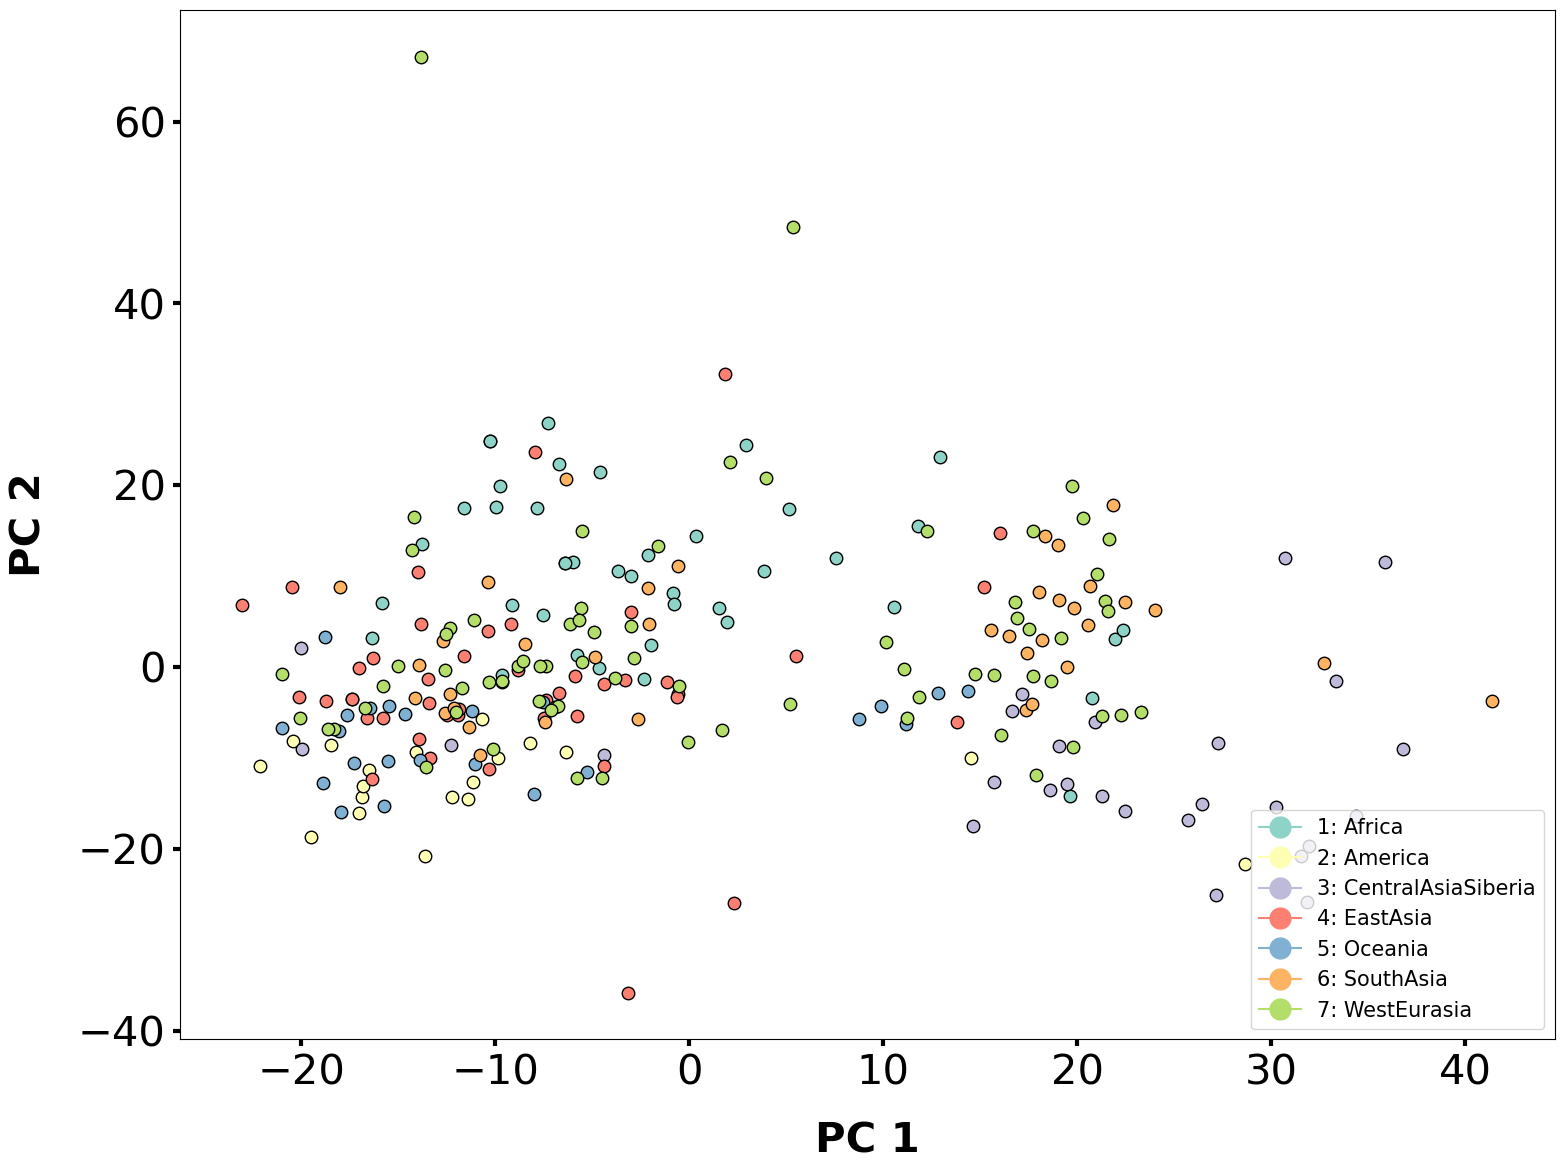

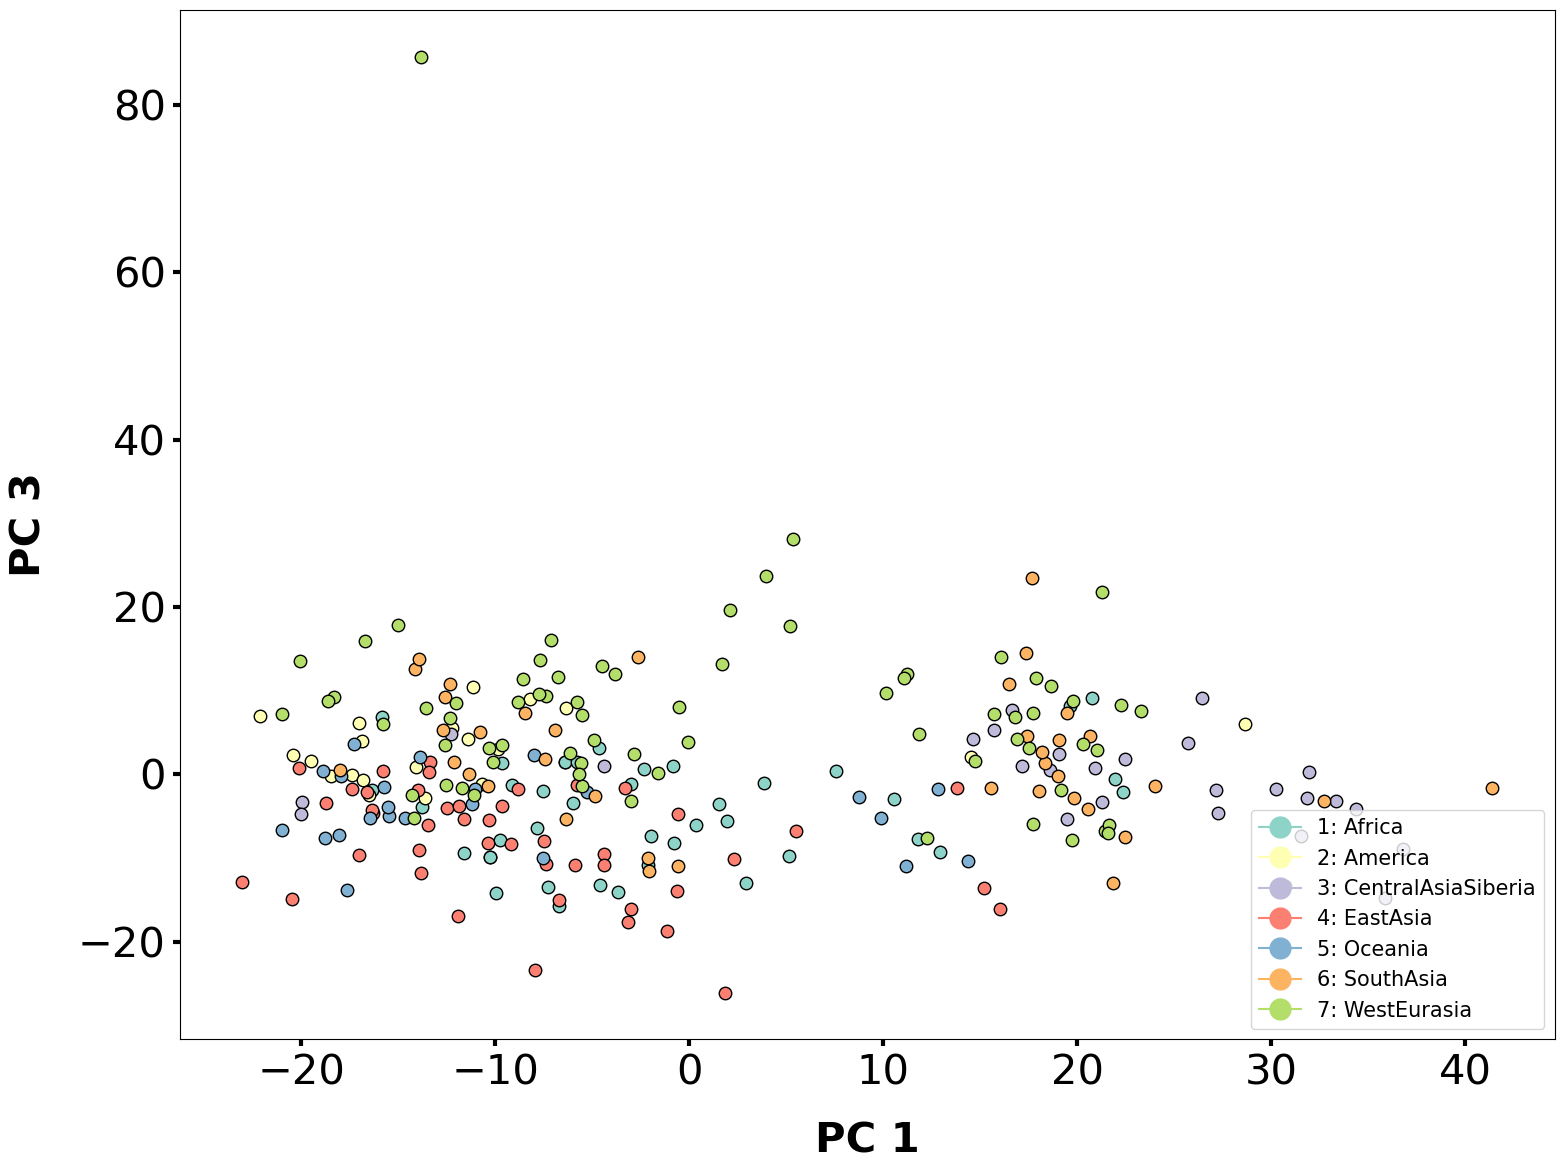

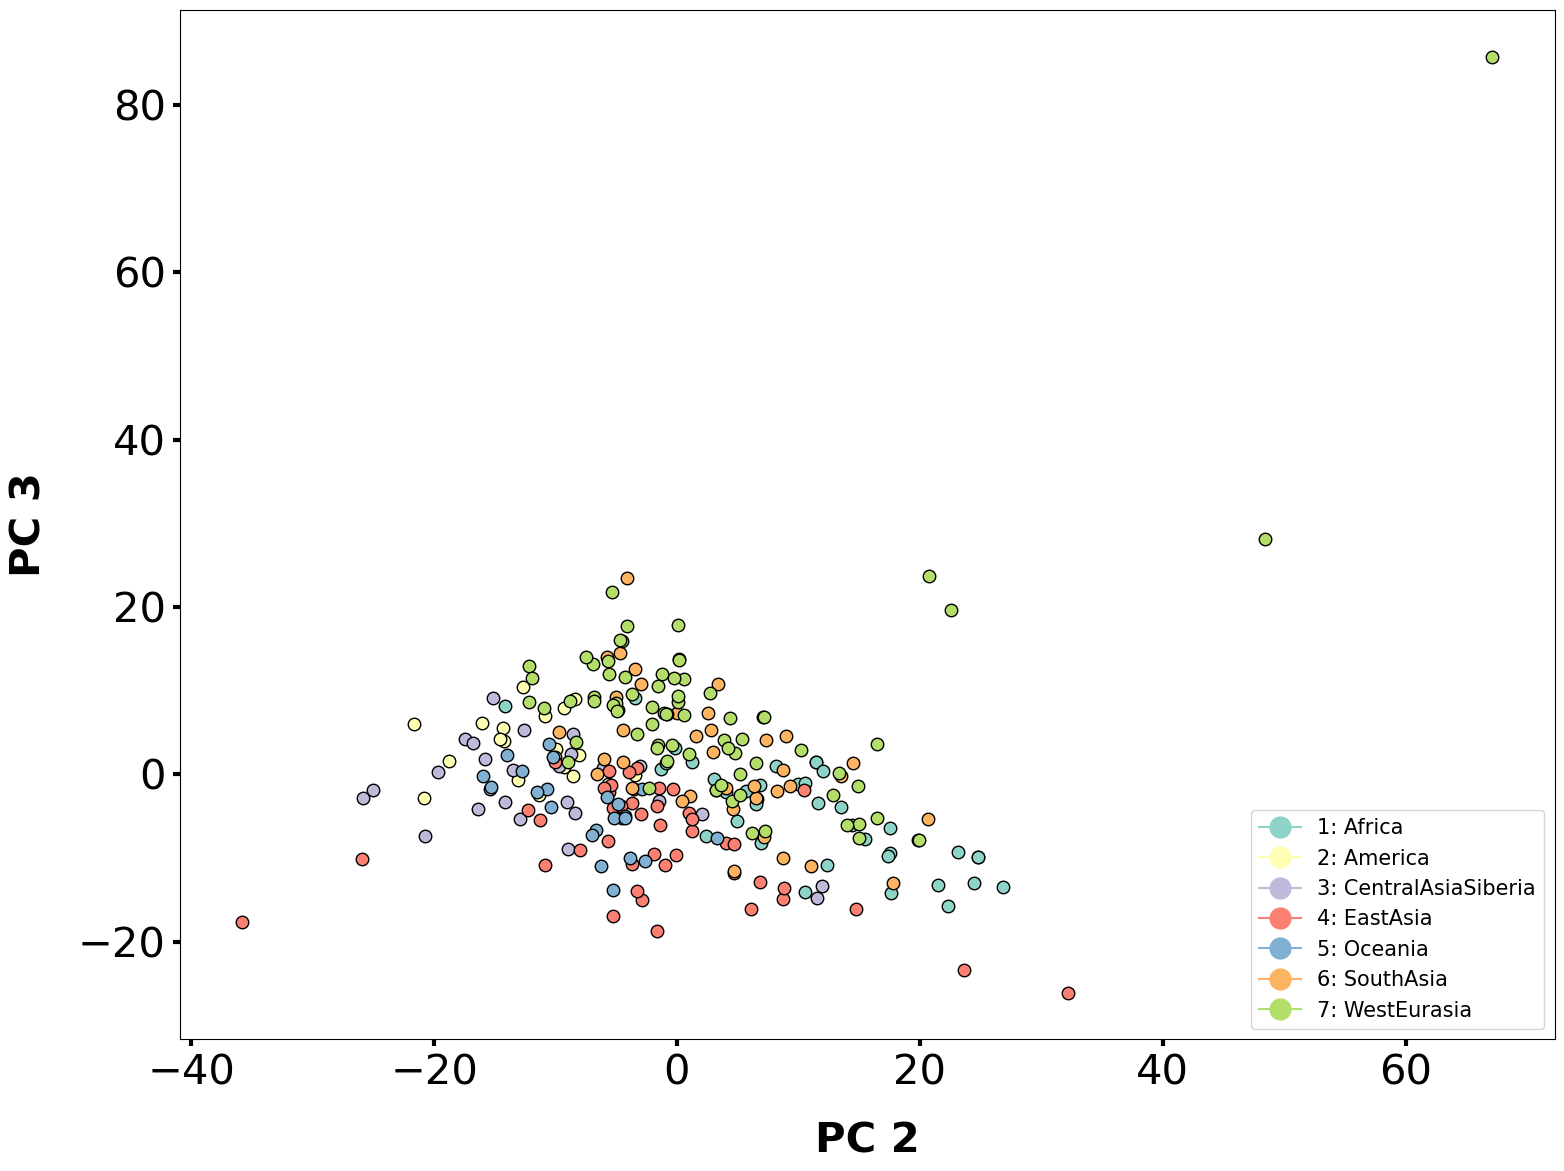

In [338]:
final = cnv_passed_vst.iloc[:,4:287]
duplications = final[(final[final.columns[1:]]>1).all(axis=1)]
duplications = duplications[(duplications[duplications.columns[1:]]<10).all(axis=1)]
counts = duplications
counts = counts.fillna(2)
counts = counts.T
counts = counts.sort_index()
features = ids_hg19.set_index('Sample').merge(counts, left_index=True, right_index=True)
features = features.loc[:,['Region']]
features = features.sort_index()

x = StandardScaler().fit_transform(counts)
pca = PCA(n_components=3)
pca_results = pca.fit_transform(x)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3'],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
components = [1,2,3]

combinations_components = list(combinations(components,2))
for i in combinations_components:
        plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))

In [103]:
pd.read_csv('../annotation_files/T2T-chm13-catLiftOffGenes.csv')

/var/folders/05/4pfxtbrs5459ytz3j1jhcgt00000gn/T/ipykernel_1224/728720004.py:1: DtypeWarning: Columns (23,36) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('../annotation_files/T2T-chm13-catLiftOffGenes.csv')


#"chrom"  chromStart  chromEnd            name  score strand  \
0          chr1       11135     12457    AL627309.3-1      0      -   
1          chr1       11629     13433    AP006222.2-1      0      +   
2          chr1       14252     21099  AC114498.1-201      0      +   
3          chr1       14291     20905  AC114498.1-202      0      +   
4          chr1       52975     54613    AL731661.1-1      0      -   
...         ...         ...       ...             ...    ...    ...   
234898    chr22    51297358  51314457   RPL23AP82-206      0      +   
234899    chr22    51306334  51312521    AC016629.2-1      0      -   
234900    chr22    51310399  51312573    AC016629.2-1      0      -   
234901    chr22    51312184  51312653   RPL23AP82-202      0      +   
234902    chr22    51316987  51319035    AL078621.3-1      0      +   

        thickStart  thickEnd    reserved  blockCount  ... collapsedGeneNames  \
0            12457     12457   85,212,76           2  ...                NaN   
1            13433     13433   85,212,76           2  ...                NaN   
2            21099     21099   85,212,76           2  ...                NaN   
3            20905     20905   85,212,76           2  ...                NaN   
4            54613     54613   85,212,76           3  ...                NaN   
...            ...       ...         ...         ...  ...                ...   
234898    51314457  51314457   85,212,76           3  ...                NaN   
234899    51312521  51312521   85,212,76           3  ...                NaN   
234900    51312573  51312573   85,212,76           2  ...                NaN   
234901    51312653  51312653  255,51,255           1  ...                NaN   
234902    51319035  51319035   85,212,76           1  ...                NaN   

       frameshift exonAnnotationSupport intronAnnotationSupport  \
0             NaN                   NaN                     NaN   
1             NaN                   NaN                     NaN   
2             NaN                   1,1                       1   
3             NaN                   1,1                       1   
4             NaN                   NaN                     NaN   
...           ...                   ...                     ...   
234898        NaN                 1,1,0                     1,1   
234899        NaN                   NaN                     NaN   
234900        NaN                   NaN                     NaN   
234901        NaN                     1                     NaN   
234902        NaN                   NaN                     NaN   

       transcriptClass transcriptModes validStart validStop properOrf  \
0              paralog         Liftoff        NaN       NaN       NaN   
1              paralog         Liftoff        NaN       NaN       NaN   
2             ortholog        transMap       True      True      True   
3             ortholog        transMap       True      True      True   
4              paralog         Liftoff        NaN       NaN       NaN   
...                ...             ...        ...       ...       ...   
234898        ortholog        transMap       True      True      True   
234899         paralog         Liftoff        NaN       NaN       NaN   
234900         paralog         Liftoff        NaN       NaN       NaN   
234901        ortholog        transMap       True      True      True   
234902         paralog         Liftoff        NaN       NaN       NaN   

       extra_paralog  
0               True  
1               True  
2              False  
3              False  
4               True  
...              ...  
234898         False  
234899          True  
234900          True  
234901         False  
234902          True  

[234903 rows x 37 columns]

In [69]:
vst_dt_filtered

Chromosome     Start       End  Africa-America  \
73           chr1    384084    385084         0.08880   
74           chr1    385084    387761         0.06949   
201          chr1    636035    637514         0.28334   
413          chr1   1093209   1095911         0.00409   
423          chr1   1111010   1112728         0.00211   
...           ...       ...       ...             ...   
918011      chr22  46537915  46539386         0.20420   
918297      chr22  47073439  47074439         0.06589   
918998      chr22  48687861  48692337         0.03489   
919226      chr22  49113340  49116195         0.43463   
919566      chr22  49781932  49783037         0.33436   

        Africa-CentralAsiaSiberia  Africa-EastAsia  Africa-Oceania  \
73                        0.00440          0.00000         0.07072   
74                        0.29305          0.08073         0.02830   
201                       0.06609          0.19199         0.02399   
413                       0.00790          0.05548         0.20019   
423                       0.02894          0.01648         0.33847   
...                           ...              ...             ...   
918011                    0.00466          0.04829         0.00215   
918297                    0.00048          0.00523         0.00935   
918998                    0.03039          0.01344         0.12202   
919226                    0.20891          0.05915         0.19586   
919566                    0.06107          0.00360         0.00009   

        Africa-SouthAsia  Africa-WestEurasia  America-CentralAsiaSiberia  ...  \
73               0.00448             0.00014                     0.06505  ...   
74               0.10490             0.04928                     0.11545  ...   
201              0.09553             0.01755                     0.08745  ...   
413              0.03704             0.00160                     0.00027  ...   
423              0.00732             0.00654                     0.01399  ...   
...                  ...                 ...                         ...  ...   
918011           0.00516             0.03220                     0.20020  ...   
918297           0.04943             0.02239                     0.05634  ...   
918998           0.00012             0.00166                     0.12558  ...   
919226           0.10204             0.13747                     0.08405  ...   
919566           0.07443             0.07047                     0.15450  ...   

        CentralAsiaSiberia-EastAsia  CentralAsiaSiberia-Oceania  \
73                          0.00417                     0.11836   
74                          0.07929                     0.18037   
201                         0.04242                     0.01054   
413                         0.02602                     0.19038   
423                         0.00148                     0.18911   
...                             ...                         ...   
918011                      0.02252                     0.00046   
918297                      0.00704                     0.01544   
918998                      0.04908                     0.22360   
919226                      0.02530                     0.00027   
919566                      0.03677                     0.06632   

        CentralAsiaSiberia-SouthAsia  CentralAsiaSiberia-WestEurasia  \
73                           0.01761                         0.00245   
74                           0.06042                         0.09813   
201                          0.00375                         0.01096   
413                          0.01300                         0.00094   
423                          0.00434                         0.00592   
...                              ...                             ...   
918011                       0.00000                         0.01086   
918297                       0.06810                         0.02872   
918998                       0.03438                   

<h2> Gene antoation

In [36]:
## Anotations
t2t_genes = pd.read_csv('../annotation_files/T2T-chm13-catLiftOffGenes.csv')
t2t_genes.columns = ['Chromosome', 'Start', 'End', 'name', 'score', 'strand',
       'thickStart', 'thickEnd', 'reserved', 'blockCount', 'blockSizes',
       'chromStarts', 'name2', 'cdsStartStat', 'cdsEndStat', 'exonFrames',
       'txId', 'type', 'geneName', 'geneType', 'sourceGene',
       'sourceTranscript', 'alignmentId', 'alternativeSourceTranscripts',
       'Paralogy', 'UnfilteredParalogy', 'collapsedGeneIds',
       'collapsedGeneNames', 'frameshift', 'exonAnnotationSupport',
       'intronAnnotationSupport', 'transcriptClass', 'transcriptModes',
       'validStart', 'validStop', 'properOrf', 'extra_paralog']
t2t_genes = t2t_genes[['Chromosome', 'Start', 'End', 'name2']]
t2t_genes = PyRanges(t2t_genes)

vst_dt_filtered_ranges = PyRanges(vst_dt_filtered)
#Genes
grch37_coordinates_genes = vst_dt_filtered_ranges.nearest(t2t_genes)
grch37_coordinates_genes = grch37_coordinates_genes.as_df()
grch37_coordinates_genes = grch37_coordinates_genes[grch37_coordinates_genes['Distance'] <1 ]
grch37_coordinates_genes.to_csv('../data/T2T_all_cnvs_genes_differentiated_by_Vst.csv')
grch37_coordinates_genes.columns


/var/folders/05/4pfxtbrs5459ytz3j1jhcgt00000gn/T/ipykernel_73370/3195202696.py:2: DtypeWarning: Columns (23,36) have mixed types. Specify dtype option on import or set low_memory=False.
  t2t_genes = pd.read_csv('../annotation_files/T2T-chm13-catLiftOffGenes.csv')
/opt/anaconda3/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/opt/anaconda3/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


Index(['Chromosome', 'Start', 'End', 'Africa-America',
       'Africa-CentralAsiaSiberia', 'Africa-EastAsia', 'Africa-Oceania',
       'Africa-SouthAsia', 'Africa-WestEurasia', 'America-CentralAsiaSiberia',
       'America-EastAsia', 'America-Oceania', 'America-SouthAsia',
       'America-WestEurasia', 'CentralAsiaSiberia-EastAsia',
       'CentralAsiaSiberia-Oceania', 'CentralAsiaSiberia-SouthAsia',
       'CentralAsiaSiberia-WestEurasia', 'EastAsia-Oceania',
       'EastAsia-SouthAsia', 'EastAsia-WestEurasia', 'Oceania-SouthAsia',
       'Oceania-WestEurasia', 'SouthAsia-WestEurasia', 'Start_b', 'End_b',
       'name2', 'Distance'],
      dtype='object')

In [42]:
grch37_coordinates_genes#[grch37_coordinates_genes['name2'] =='MIR548D2']

Chromosome     Start       End  Africa-America  \
0          chr1    384084    385084         0.08880   
1          chr1    385084    387761         0.06949   
2          chr1   1093209   1095911         0.00409   
3          chr1   1111010   1112728         0.00211   
4          chr1   1422569   1425558         0.04019   
...         ...       ...       ...             ...   
3063      chr22  45385405  45386894         0.00338   
3064      chr22  45642081  45644771         0.17344   
3065      chr22  46537915  46539386         0.20420   
3066      chr22  47073439  47074439         0.06589   
3067      chr22  49113340  49116195         0.43463   

      Africa-CentralAsiaSiberia  Africa-EastAsia  Africa-Oceania  \
0                       0.00440          0.00000         0.07072   
1                       0.29305          0.08073         0.02830   
2                       0.00790          0.05548         0.20019   
3                       0.02894          0.01648         0.33847   
4                       0.12576          0.01107         0.01810   
...                         ...              ...             ...   
3063                    0.03671          0.15174         0.01016   
3064                    0.09264          0.00117         0.18699   
3065                    0.00466          0.04829         0.00215   
3066                    0.00048          0.00523         0.00935   
3067                    0.20891          0.05915         0.19586   

      Africa-SouthAsia  Africa-WestEurasia  America-CentralAsiaSiberia  ...  \
0              0.00448             0.00014                     0.06505  ...   
1              0.10490             0.04928                     0.11545  ...   
2              0.03704             0.00160                     0.00027  ...   
3              0.00732             0.00654                     0.01399  ...   
4              0.02580             0.00223                     0.30101  ...   
...                ...                 ...                         ...  ...   
3063           0.00063             0.01259                     0.01729  ...   
3064           0.08558             0.25621                     0.05051  ...   
3065           0.00516             0.03220                     0.20020  ...   
3066           0.04943             0.02239                     0.05634  ...   
3067           0.10204             0.13747                     0.08405  ...   

      EastAsia-Oceania  EastAsia-SouthAsia  EastAsia-WestEurasia  \
0              0.06892             0.00460               0.00012   
1              0.02709             0.00145               0.00187   
2              0.12690             0.00365               0.02240   
3              0.21532             0.00097               0.00187   
4              0.00103             0.00308               0.00302   
...                ...                 ...                   ...   
3063           0.08072             0.13502               0.23570   
3064           0.13517             0.05844               0.19557   
3065           0.02773             0.02310               0.00202   
3066           0.00000             0.00512               0.00078   
3067           0.02006             0.00019               0.01064   

      Oceania-SouthAsia  Oceania-WestEurasia  SouthAsia-WestEurasia   Start_b  \
0               0.04316              0.05974                0.00565    372944   
1               0.04083              0.01295                0.00638    372944   
2               0.16094              0.11641                0.01200   1069727   
3               0.21626              0.23396                0.00008   1093990   
4               0.00044              0.00606                0.01141   1356363   
...                 ...                  ...                    ...       ...   
3063            0.00593              0.03875                0.01845  45364686   
3064            0.05404              0.00340                0.06073  45617507   
3065            0.00052         

In [43]:
dt = []
for index, row in grch37_coordinates_genes.iterrows():
    if row['Africa-CentralAsiaSiberia'] > 0.2 and row['America-EastAsia'] < 0.1 and row['America-CentralAsiaSiberia'] < 0.1 and row['CentralAsiaSiberia-EastAsia'] and row['Oceania-WestEurasia'] < 0.1:
        dt.append([row['Chromosome'], row['Start'],row['End'],row['name2'],row['Africa-CentralAsiaSiberia'], 'Africa'])
        
    if row['Africa-America'] > 0.2 and row['Africa-CentralAsiaSiberia'] < 0.1 and row['Africa-SouthAsia'] < 0.1 and row['CentralAsiaSiberia-EastAsia']:
        dt.append([row['Chromosome'], row['Start'],row['End'],row['name2'], row['Africa-America'], 'America'])
        
    if row['CentralAsiaSiberia-EastAsia'] > 0.2 and row['Africa-America'] < 0.1 and row['America-CentralAsiaSiberia'] < 0.1 and row['Africa-CentralAsiaSiberia']:
        dt.append([row['Chromosome'], row['Start'],row['End'], row['name2'],row['CentralAsiaSiberia-EastAsia'], 'EastAsia'])

    if row['EastAsia-SouthAsia'] > 0.2 and row['Africa-America'] < 0.1 and row['Africa-SouthAsia'] < 0.1 and row['CentralAsiaSiberia-SouthAsia']:
        dt.append([row['Chromosome'], row['Start'],row['End'], row['name2'],row['EastAsia-SouthAsia'], 'SouthAsia'])
    
    if row['Africa-CentralAsiaSiberia'] > 0.2 and row['Africa-America'] < 0.1 and row['America-SouthAsia'] < 0.1 and row['Africa-Oceania'] < 0.1:
        dt.append([row['Chromosome'], row['Start'],row['End'], row['name2'],row['Africa-CentralAsiaSiberia'], 'CentralAsiaSiberia'])

    if row['EastAsia-Oceania'] > 0.2 and row['Africa-EastAsia'] < 0.1 and row['America-SouthAsia'] < 0.1 and row['Africa-America'] < 0.1:
        dt.append([row['Chromosome'], row['Start'],row['End'], row['name2'],row['EastAsia-Oceania'], 'Oceania'])

    if row['Africa-WestEurasia'] > 0.2 and row['Africa-EastAsia'] < 0.1 and row['America-WestEurasia'] < 0.1 and row['CentralAsiaSiberia-EastAsia']  and row['Africa-America'] < 0.1:
        dt.append([row['Chromosome'], row['Start'],row['End'], row['name2'],row['Africa-WestEurasia'], 'WestEurasia'])
        

In [44]:
vst_cnv = pd.DataFrame(dt)
vst_cnv.columns = ['chromsome','start','end','gene', 'vst_cnv','population']

for index, row in vst_cnv.iterrows():
    if row['population'] =='Oceania':
        print(row['gene'])


SLC35E2B
PKN2-AS1
CFHR4
CFHR2
AC013717.1
AC016766.1
NBEAL1
PLEKHM3
ZNF385D
ZNF385D
ZNF385D
ZNF385D
IL12A-AS1
MSTRG.4165
AC097522.2
ANTXR2
PLAC8
MSTRG.4456
MSTRG.4456
LVRN
HLA-P
HLA-W
HLA-W
TREML3P
AL358134.1
AHR
RBM22P3
AC092447.8
AC237221.1
AC237221.1
AC237221.1
DLGAP2
AC107959.4
TNFRSF10C
TNFRSF10D
TNFRSF10D
TNFRSF10D
TNFRSF10D
TNFRSF10D
AC084128.1
SPTAN1
VAV2
AC130307.1
AC130307.1
ANO3
AC103796.1
AC079598.4
DHX37
OTX2-AS1
AC007182.1
ATP10A
AC009120.2
MSTRG.2671
VSTM1


In [65]:
#America 
d = {'Data': ['Significan differentiated CNVs', 'Differentiate CNVs in genes'],
     'Africa-America': [len(vst_dt_filtered[vst_dt_filtered['Africa-America']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Africa-America'] > 0.3])
                       ],
     'Africa-CentralAsiaSiberia': [len(vst_dt_filtered[vst_dt_filtered['Africa-CentralAsiaSiberia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Africa-CentralAsiaSiberia'] > 0.3])
                       ],
     'Africa-EastAsia': [len(vst_dt_filtered[vst_dt_filtered['Africa-EastAsia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Africa-EastAsia'] > 0.3])
                       ],
     'Africa-Oceania': [len(vst_dt_filtered[vst_dt_filtered['Africa-Oceania']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Africa-Oceania'] > 0.3])
                       ],
     'Africa-SouthAsia': [len(vst_dt_filtered[vst_dt_filtered['Africa-SouthAsia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Africa-SouthAsia'] > 0.3])
                       ],
     'Africa-WestEurasia': [len(vst_dt_filtered[vst_dt_filtered['Africa-WestEurasia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Africa-WestEurasia'] > 0.3])
                       ],
     'America-CentralAsiaSiberia': [len(vst_dt_filtered[vst_dt_filtered['America-CentralAsiaSiberia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['America-CentralAsiaSiberia'] > 0.3])
                       ],
     'America-EastAsia': [len(vst_dt_filtered[vst_dt_filtered['America-EastAsia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['America-EastAsia'] > 0.3])
                       ],
     'America-Oceania': [len(vst_dt_filtered[vst_dt_filtered['America-Oceania']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['America-Oceania'] > 0.3])
                       ],
     'America-SouthAsia': [len(vst_dt_filtered[vst_dt_filtered['America-SouthAsia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['America-SouthAsia'] > 0.3])
                       ],
     'America-WestEurasia': [len(vst_dt_filtered[vst_dt_filtered['America-WestEurasia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['America-WestEurasia'] > 0.3])
                       ],
     'CentralAsiaSiberia-EastAsia': [len(vst_dt_filtered[vst_dt_filtered['CentralAsiaSiberia-EastAsia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['CentralAsiaSiberia-EastAsia'] > 0.3])
                       ],
     'CentralAsiaSiberia-Oceania': [len(vst_dt_filtered[vst_dt_filtered['CentralAsiaSiberia-Oceania']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['CentralAsiaSiberia-Oceania'] > 0.3])
                       ],
     'CentralAsiaSiberia-SouthAsia': [len(vst_dt_filtered[vst_dt_filtered['CentralAsiaSiberia-SouthAsia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['CentralAsiaSiberia-SouthAsia'] > 0.3])
                       ],
     'CentralAsiaSiberia-WestEurasia': [len(vst_dt_filtered[vst_dt_filtered['CentralAsiaSiberia-WestEurasia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['CentralAsiaSiberia-WestEurasia'] > 0.3])
                       ],
     'EastAsia-Oceania': [len(vst_dt_filtered[vst_dt_filtered['EastAsia-Oceania']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['EastAsia-Oceania'] > 0.3])
                       ],
     'EastAsia-SouthAsia': [len(vst_dt_filtered[vst_dt_filtered['EastAsia-SouthAsia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['EastAsia-SouthAsia'] > 0.3])
                       ],
     'EastAsia-WestEurasia': [len(vst_dt_filtered[vst_dt_filtered['EastAsia-WestEurasia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['EastAsia-WestEurasia'] > 0.3])
                       ],
     'Oceania-SouthAsia': [len(vst_dt_filtered[vst_dt_filtered['Oceania-SouthAsia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Oceania-SouthAsia'] > 0.3])
                       ],
     'Oceania-WestEurasia': [len(vst_dt_filtered[vst_dt_filtered['Oceania-WestEurasia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Oceania-WestEurasia'] > 0.3])
                       ],
     'SouthAsia-WestEurasia': [len(vst_dt_filtered[vst_dt_filtered['SouthAsia-WestEurasia']> 0.3])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['SouthAsia-WestEurasia'] > 0.3])
                       ],
     
         }

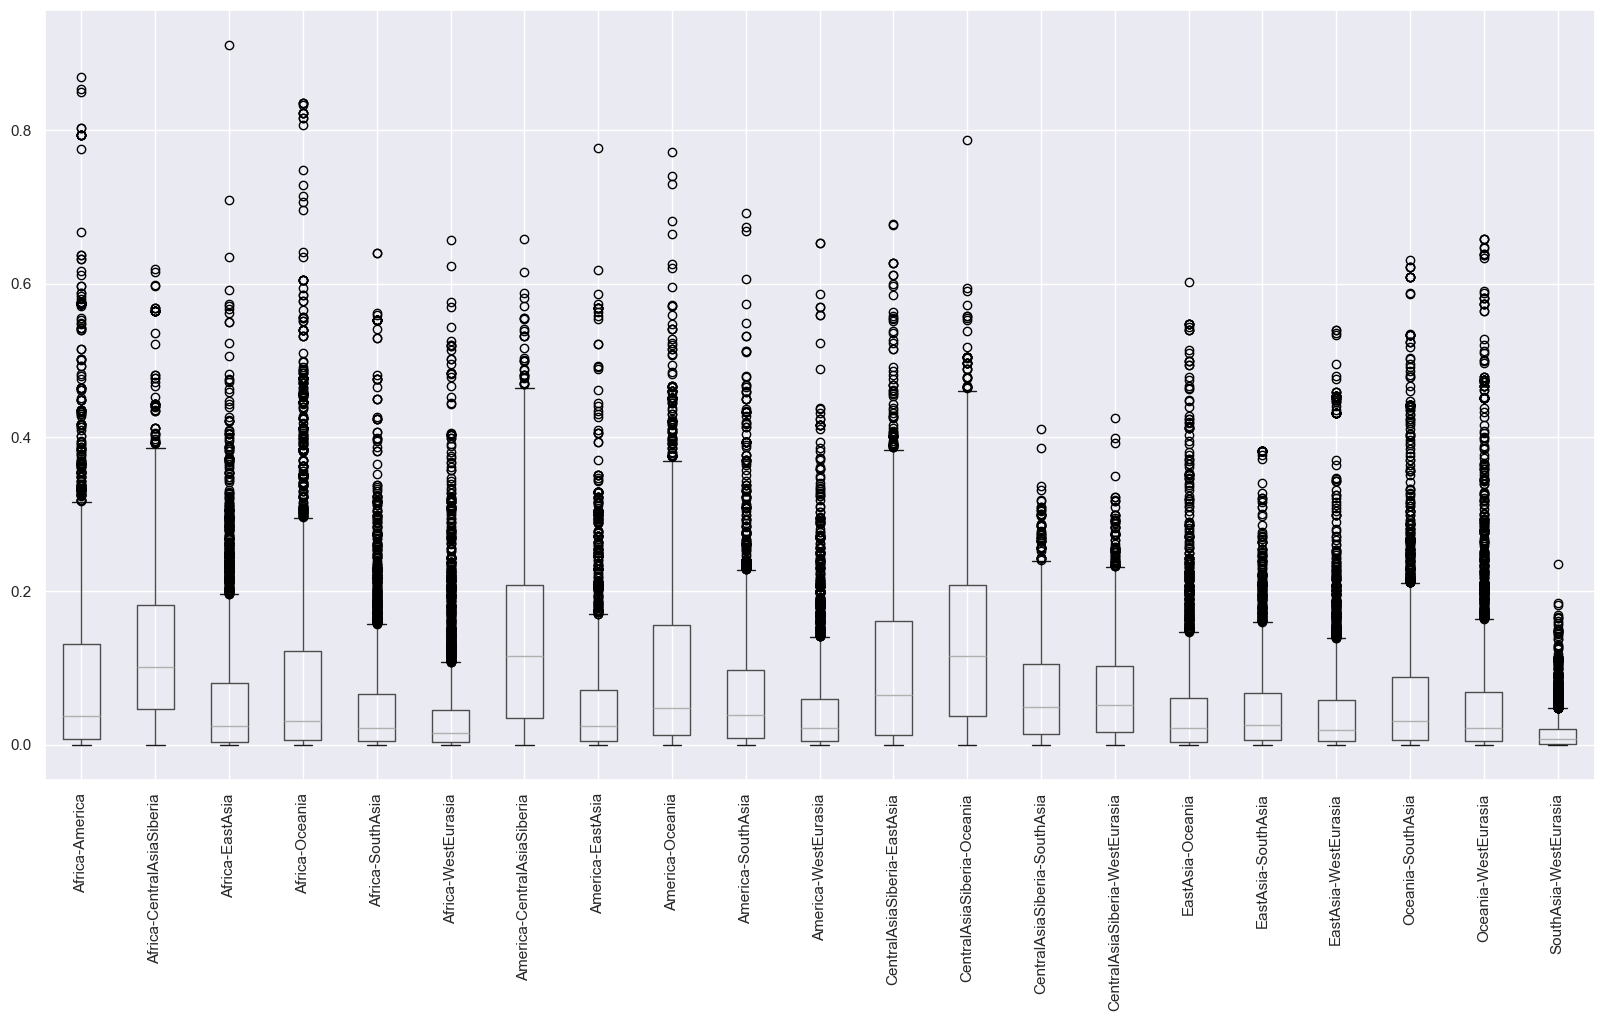

In [64]:
import seaborn as sns
from omniplot import plot as op

boxplot = vst_dt_filtered.iloc[:,3:24].boxplot(figsize=(20,10), rot=90)
#boxplot.set_facecolor('white')

In [67]:
#America 
d = {'Data': ['Significan differentiated CNVs', 'Differentiate CNVs in genes'],
     'Africa-America': [len(vst_dt_filtered[vst_dt_filtered['Africa-America']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Africa-America'] > 0.2])
                       ],
     'Africa-CentralAsiaSiberia': [len(vst_dt_filtered[vst_dt_filtered['Africa-CentralAsiaSiberia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Africa-CentralAsiaSiberia'] > 0.2])
                       ],
     'Africa-EastAsia': [len(vst_dt_filtered[vst_dt_filtered['Africa-EastAsia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Africa-EastAsia'] > 0.2])
                       ],
     'Africa-Oceania': [len(vst_dt_filtered[vst_dt_filtered['Africa-Oceania']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Africa-Oceania'] > 0.2])
                       ],
     'Africa-SouthAsia': [len(vst_dt_filtered[vst_dt_filtered['Africa-SouthAsia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Africa-SouthAsia'] > 0.2])
                       ],
     'Africa-WestEurasia': [len(vst_dt_filtered[vst_dt_filtered['Africa-WestEurasia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Africa-WestEurasia'] > 0.2])
                       ],
     'America-CentralAsiaSiberia': [len(vst_dt_filtered[vst_dt_filtered['America-CentralAsiaSiberia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['America-CentralAsiaSiberia'] > 0.2])
                       ],
     'America-EastAsia': [len(vst_dt_filtered[vst_dt_filtered['America-EastAsia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['America-EastAsia'] > 0.2])
                       ],
     'America-Oceania': [len(vst_dt_filtered[vst_dt_filtered['America-Oceania']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['America-Oceania'] > 0.2])
                       ],
     'America-SouthAsia': [len(vst_dt_filtered[vst_dt_filtered['America-SouthAsia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['America-SouthAsia'] > 0.2])
                       ],
     'America-WestEurasia': [len(vst_dt_filtered[vst_dt_filtered['America-WestEurasia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['America-WestEurasia'] > 0.2])
                       ],
     'CentralAsiaSiberia-EastAsia': [len(vst_dt_filtered[vst_dt_filtered['CentralAsiaSiberia-EastAsia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['CentralAsiaSiberia-EastAsia'] > 0.2])
                       ],
     'CentralAsiaSiberia-Oceania': [len(vst_dt_filtered[vst_dt_filtered['CentralAsiaSiberia-Oceania']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['CentralAsiaSiberia-Oceania'] > 0.2])
                       ],
     'CentralAsiaSiberia-SouthAsia': [len(vst_dt_filtered[vst_dt_filtered['CentralAsiaSiberia-SouthAsia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['CentralAsiaSiberia-SouthAsia'] > 0.2])
                       ],
     'CentralAsiaSiberia-WestEurasia': [len(vst_dt_filtered[vst_dt_filtered['CentralAsiaSiberia-WestEurasia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['CentralAsiaSiberia-WestEurasia'] > 0.2])
                       ],
     'EastAsia-Oceania': [len(vst_dt_filtered[vst_dt_filtered['EastAsia-Oceania']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['EastAsia-Oceania'] > 0.2])
                       ],
     'EastAsia-SouthAsia': [len(vst_dt_filtered[vst_dt_filtered['EastAsia-SouthAsia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['EastAsia-SouthAsia'] > 0.2])
                       ],
     'EastAsia-WestEurasia': [len(vst_dt_filtered[vst_dt_filtered['EastAsia-WestEurasia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['EastAsia-WestEurasia'] > 0.2])
                       ],
     'Oceania-SouthAsia': [len(vst_dt_filtered[vst_dt_filtered['Oceania-SouthAsia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Oceania-SouthAsia'] > 0.2])
                       ],
     'Oceania-WestEurasia': [len(vst_dt_filtered[vst_dt_filtered['Oceania-WestEurasia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['Oceania-WestEurasia'] > 0.2])
                       ],
     'SouthAsia-WestEurasia': [len(vst_dt_filtered[vst_dt_filtered['SouthAsia-WestEurasia']> 0.2])  ,len(grch37_coordinates_genes[grch37_coordinates_genes['SouthAsia-WestEurasia'] > 0.2])
                       ],
     
         }

In [68]:
df = pd.DataFrame(data=d)
df.T

0  \
Data                            Significan differentiated CNVs   
Africa-America                                             566   
Africa-CentralAsiaSiberia                                  644   
Africa-EastAsia                                            373   
Africa-Oceania                                             487   
Africa-SouthAsia                                           200   
Africa-WestEurasia                                         199   
America-CentralAsiaSiberia                                 884   
America-EastAsia                                           256   
America-Oceania                                            606   
America-SouthAsia                                          261   
America-WestEurasia                                        160   
CentralAsiaSiberia-EastAsia                                624   
CentralAsiaSiberia-Oceania                                 829   
CentralAsiaSiberia-SouthAsia                               158   
CentralAsiaSiberia-WestEurasia                             209   
EastAsia-Oceania                                           177   
EastAsia-SouthAsia                                         120   
EastAsia-WestEurasia                                       126   
Oceania-SouthAsia                                          313   
Oceania-WestEurasia                                        237   
SouthAsia-WestEurasia                                        1   

                                                          1  
Data                            Differentiate CNVs in genes  
Africa-America                                          301  
Africa-CentralAsiaSiberia                               361  
Africa-EastAsia                                         174  
Africa-Oceania                                          238  
Africa-SouthAsia                                        112  
Africa-WestEurasia                                      112  
America-CentralAsiaSiberia                              588  
America-EastAsia                                        129  
America-Oceania                                         333  
America-SouthAsia                                       126  
America-WestEurasia                                      77  
CentralAsiaSiberia-EastAsia                             399  
CentralAsiaSiberia-Oceania                              515  
CentralAsiaSiberia-SouthAsia                            114  
CentralAsiaSiberia-WestEurasia                          124  
EastAsia-Oceania                                         98  
EastAsia-SouthAsia                                       47  
EastAsia-WestEurasia                                     54  
Oceania-SouthAsia                                       165  
Oceania-WestEurasia                                     111  
SouthAsia-WestEurasia                                     1

In [66]:
df = pd.DataFrame(data=d)
df.T

0  \
Data                            Significan differentiated CNVs   
Africa-America                                             255   
Africa-CentralAsiaSiberia                                  162   
Africa-EastAsia                                            109   
Africa-Oceania                                             284   
Africa-SouthAsia                                            72   
Africa-WestEurasia                                          76   
America-CentralAsiaSiberia                                 211   
America-EastAsia                                           127   
America-Oceania                                            246   
America-SouthAsia                                           93   
America-WestEurasia                                         47   
CentralAsiaSiberia-EastAsia                                163   
CentralAsiaSiberia-Oceania                                 212   
CentralAsiaSiberia-SouthAsia                                11   
CentralAsiaSiberia-WestEurasia                              10   
EastAsia-Oceania                                            69   
EastAsia-SouthAsia                                          42   
EastAsia-WestEurasia                                        58   
Oceania-SouthAsia                                          114   
Oceania-WestEurasia                                        113   
SouthAsia-WestEurasia                                        0   

                                                          1  
Data                            Differentiate CNVs in genes  
Africa-America                                          134  
Africa-CentralAsiaSiberia                                81  
Africa-EastAsia                                          53  
Africa-Oceania                                          110  
Africa-SouthAsia                                         36  
Africa-WestEurasia                                       37  
America-CentralAsiaSiberia                              132  
America-EastAsia                                         60  
America-Oceania                                         114  
America-SouthAsia                                        34  
America-WestEurasia                                      25  
CentralAsiaSiberia-EastAsia                              99  
CentralAsiaSiberia-Oceania                              124  
CentralAsiaSiberia-SouthAsia                              7  
CentralAsiaSiberia-WestEurasia                            8  
EastAsia-Oceania                                         35  
EastAsia-SouthAsia                                        5  
EastAsia-WestEurasia                                     18  
Oceania-SouthAsia                                        43  
Oceania-WestEurasia                                      40  
SouthAsia-WestEurasia                                     0